In [1]:
%pylab
from landlab import RasterModelGrid
from landlab.plot.imshow import imshow_grid_at_node
from landlab.components import PresFlowNetwork, MeltCreep
import numpy as np
from matplotlib import colors,  cm
import matplotlib.animation as animation


Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


/home/mcoving/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/mcoving/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [7]:
mg = RasterModelGrid((25,30),500)
junc_elev = mg.add_zeros('node', 'junction__elevation')
R = mg.add_zeros('node', 'input__discharge')
#d_h = mg.add_ones('link', 'hydraulic__diameter')
thickness = 500.*np.ones(mg.number_of_nodes)
Z = mg.add_field('node', 'ice__thickness', thickness)
#a = mg.add_ones('link', 'head_loss__exponent')
#f = mg.add_ones('link', 'friction__factor')
#h = np.random.rand(mg.number_of_nodes)
h = mg.add_zeros('node', 'hydraulic__head')
Q = mg.add_zeros('link', 'conduit__discharge')
#net_node_flux = mg.add_ones('node', 'net_node_flux', noclobber=False)
#set boundary node head

#add input to node 310
moulin_Q=1.
mg.at_node['input__discharge'][305]=moulin_Q
#set heads at edges
h[mg.nodes_at_left_edge] = 400.
h[mg.nodes_at_right_edge] = 300.
h[mg.nodes_at_top_edge] = 0.
h[mg.nodes_at_bottom_edge] = 0.
mg.set_closed_boundaries_at_grid_edges(False,True,True,True)
Q[mg.active_links] = 1.*0.1
n_core = mg.number_of_core_nodes
links = mg.links_at_node
print("Number of links = ", mg.number_of_links)
print("Number of nodes = ", mg.number_of_nodes)
print("Number of active links = ", mg.number_of_active_links)
print("Number of core nodes = ", mg.number_of_core_nodes)

d_h = mg.add_zeros('link','hydraulic__diameter')
mg.at_link['hydraulic__diameter'][mg.active_links]= 0.5*np.random.rand(mg.number_of_active_links)




#code added for fsolve algorithm
#dhdx = mg.add_zeros('link', 'hydraulic_head_gradient', noclobber=False)
#net_node_flux = mg.add_ones('node', 'net_node_flux', noclobber=False)


pfn = PresFlowNetwork(mg)
pfn.run_one_step()
mc = MeltCreep(mg, dt=500.)

Number of links =  1445
Number of nodes =  750
Number of active links =  1260
Number of core nodes =  644
Number of iterations = 1 tolerance = 0.15186465442748248
Number of iterations = 2 tolerance = 0.21218834711069634
Number of iterations = 3 tolerance = 0.18522081689871808
Number of iterations = 4 tolerance = 0.1093341380526096
Number of iterations = 5 tolerance = 0.042084164625573295
Number of iterations = 6 tolerance = 0.02033283233840703
Number of iterations = 7 tolerance = 0.009998175715624997
Number of iterations = 8 tolerance = 0.006682335724759847
Number of iterations = 9 tolerance = 0.016070271770872488
Number of iterations = 10 tolerance = 0.008542534029997197
Number of iterations = 11 tolerance = 0.00495323010673393
Number of iterations = 12 tolerance = 0.0045427210987144615
Number of iterations = 13 tolerance = 0.002270085929693633
Number of iterations = 14 tolerance = 0.0011324947386039815
Number of iterations = 15 tolerance = 0.0005611915212865083
Number of iterations =

In [8]:
from PIL import Image
from PIL import ImageDraw

def plot_links(grid, value_name, autoscale=True, vmin=0., vmax=0., cmap_name='jet', magnitude= False, lw=5, pixels_per_node=15):#, logvalues=False ):
    pixel_xscaling_factor = pixels_per_node/grid.dx
    pixel_yscaling_factor = pixels_per_node/grid.dy
    im = Image.new('RGBA', (round(grid.grid_xdimension*pixel_xscaling_factor), round(grid.grid_ydimension*pixel_yscaling_factor)), (255,255,255,255))
    draw = ImageDraw.Draw(im)

    link_head_x = grid.node_x[grid.node_at_link_head]
    link_head_y = grid.node_y[grid.node_at_link_head]
    link_tail_x = grid.node_x[grid.node_at_link_tail]
    link_tail_y = grid.node_y[grid.node_at_link_tail]       
    if magnitude:
        values = abs(grid.at_link[value_name])
    else:
        values = grid.at_link[value_name]
    #if logvalues:
    #    values = np.log10(abs(grid.at_link[value_name]))
    
    
    #Normalize color values
    if autoscale:
        cnorm = colors.Normalize()
        cnorm.autoscale(values)
    else:
        cnorm = colors.Normalize(vmin,vmax)
    scalarMap = cm.ScalarMappable(norm=cnorm, cmap = get_cmap(cmap_name))
    scalarMap.set_array(values)
    #set_cmap()
    for i, value in enumerate(values):
        draw.line( ((link_head_x[i]*pixel_xscaling_factor,link_head_y[i]*pixel_yscaling_factor),(link_tail_x[i]*pixel_xscaling_factor,link_tail_y[i]*pixel_yscaling_factor)),fill=scalarMap.to_rgba(value,bytes=True),width=lw) 
        #xs = [link_head_x[i],link_tail_x[i]]
        #ys = [link_head_y[i],link_tail_y[i]]
        #img = plot(xs,ys,lw=lw,color=scalarMap.to_rgba(value))
    
    imshow(np.asarray(im), origin='lower', extent=(0,grid.grid_xdimension,0,grid.grid_ydimension))
    colorbar(scalarMap)


In [ ]:
nsteps = 50000
step_start = 1
fig1, axs = subplots(2,2,figsize=(9,6))
every = 50
for step in arange(nsteps)+step_start:
    print("step =",step, " avg d_h=",mg.at_link['hydraulic__diameter'].mean())
    pfn.run_one_step()    
    #mg.calc_grad_at_link(h, out=dhdx)
    #h = fsolve(network_residuals, h[mg.core_nodes])
    #Q = np.sign(dhdx)*np.sqrt(np.fabs(dhdx))
    mc.run_one_step()
    if (step % every)==0: #make an animation frame
        subplot(2,2,1)
        imshow_grid_at_node(mg, h)
        #plot(mg.at_node['hydraulic__head'][mg.core_nodes])
        #ylim([300,400])
        subplot(2,2,2)
        plot_links(mg, 'conduit__discharge', magnitude=True)#, vmin=0., vmax=1.m autoscale=False)
        #plot(mg.at_link['conduit__discharge'][mg.active_links])
        #ylabel('')
        #ylim([0,1.5])
        subplot(2,2,3)
        plot_links(mg, 'hydraulic__diameter')#, autoscale=False, vmin=0, vmax=1.)
        subplot(2,2,4)
        plot(mg.at_link['hydraulic__diameter'][mg.active_links])
        #ylim([0.5,1.5])
        image_name = 'heads_and_discharge'+str(step).zfill(6)+'.png'
        tight_layout()
        savefig(image_name)
        fig1.clf()

#im_ani = animation.ArtistAnimation(fig1,ims)

step = 1  avg d_h= 0.21691603746082222
Number of iterations = 1 tolerance = 4.9125217782552966e-11
max ddh =  0.008041198989872022
step = 2  avg d_h= 0.21721894193089986
Number of iterations = 1 tolerance = 0.0013467367797617147
Number of iterations = 2 tolerance = 5.872765780502839e-06
max ddh =  0.007442795267315508
step = 3  avg d_h= 0.21750943756350716
Number of iterations = 1 tolerance = 0.0012039820236323384
Number of iterations = 2 tolerance = 9.392534924400342e-06
max ddh =  0.006929316276707428
step = 4  avg d_h= 0.21778853871527884
Number of iterations = 1 tolerance = 0.0010865502070066119
Number of iterations = 2 tolerance = 6.109693367020719e-06
max ddh =  0.006483073596650884
step = 5  avg d_h= 0.21805711871040487
Number of iterations = 1 tolerance = 0.0009885554318212336
Number of iterations = 2 tolerance = 4.364279422741646e-06
max ddh =  0.006091087346014296
step = 6  avg d_h= 0.21831593799081558
Number of iterations = 1 tolerance = 0.0009057564832724713
Number of itera

Number of iterations = 1 tolerance = 0.00037117545962547793
Number of iterations = 2 tolerance = 1.3192032299342432e-06
max ddh =  0.0016558012401630096
step = 45  avg d_h= 0.22436544302058045
Number of iterations = 1 tolerance = 0.00037143914899188946
Number of iterations = 2 tolerance = 1.9245048029696183e-06
max ddh =  0.0016203025605088278
step = 46  avg d_h= 0.22446154330957502
Number of iterations = 1 tolerance = 0.00037166857024615793
Number of iterations = 2 tolerance = 4.1953008473108455e-06
max ddh =  0.0015860115081237402
step = 47  avg d_h= 0.22455588065467721
Number of iterations = 1 tolerance = 0.0003718436633037177
Number of iterations = 2 tolerance = 1.247119098693808e-06
max ddh =  0.0015528695687444588
step = 48  avg d_h= 0.22464850440736622
Number of iterations = 1 tolerance = 0.0003719889746097542
Number of iterations = 2 tolerance = 1.2234405418806021e-06
max ddh =  0.0015208219746634742
step = 49  avg d_h= 0.2247394620367188
Number of iterations = 1 tolerance = 0.

Number of iterations = 2 tolerance = 1.2542749958984606e-06
max ddh =  0.0007927874468320786
step = 87  avg d_h= 0.22729657212361185
Number of iterations = 1 tolerance = 0.000354992711465104
Number of iterations = 2 tolerance = 1.363741224009573e-06
max ddh =  0.0007814605021439544
step = 88  avg d_h= 0.22734654717818215
Number of iterations = 1 tolerance = 0.0003534430999376434
Number of iterations = 2 tolerance = 1.521933943709683e-06
max ddh =  0.0007703793101747221
step = 89  avg d_h= 0.2273958700451962
Number of iterations = 1 tolerance = 0.00035193428549611105
Number of iterations = 2 tolerance = 1.750975907576554e-06
max ddh =  0.0007595367189062188
step = 90  avg d_h= 0.22744455367401134
Number of iterations = 1 tolerance = 0.0003504824325587519
Number of iterations = 2 tolerance = 2.090862704185164e-06
max ddh =  0.0007489258322384202
step = 91  avg d_h= 0.22749261067947474
Number of iterations = 1 tolerance = 0.00034911411418312235
Number of iterations = 2 tolerance = 2.61971

Number of iterations = 1 tolerance = 0.0002667521662071126
Number of iterations = 2 tolerance = 5.848855743617598e-07
max ddh =  0.0005463475693702647
step = 130  avg d_h= 0.22898319177018714
Number of iterations = 1 tolerance = 0.00026454391845076586
Number of iterations = 2 tolerance = 4.853228948928368e-07
max ddh =  0.0005434927736659839
step = 131  avg d_h= 0.2290136872962588
Number of iterations = 1 tolerance = 0.00026235212886260156
Number of iterations = 2 tolerance = 4.032307273707514e-07
max ddh =  0.0005406463771131956
step = 132  avg d_h= 0.22904387935613635
Number of iterations = 1 tolerance = 0.0002601774361032719
Number of iterations = 2 tolerance = 3.948389406625147e-07
max ddh =  0.0005378090011269902
step = 133  avg d_h= 0.22907377268759488
Number of iterations = 1 tolerance = 0.00025801997000642757
Number of iterations = 2 tolerance = 4.0494730164637813e-07
max ddh =  0.0005349812334051662
step = 134  avg d_h= 0.2291033719298878
Number of iterations = 1 tolerance = 0

Number of iterations = 2 tolerance = 4.963670353803906e-07
max ddh =  0.00043634528765086313
step = 173  avg d_h= 0.23006876783797078
Number of iterations = 1 tolerance = 0.00018598049781068382
Number of iterations = 2 tolerance = 4.524031388085381e-07
max ddh =  0.0004340976422929444
step = 174  avg d_h= 0.23008952259273885
Number of iterations = 1 tolerance = 0.0001842915416966906
Number of iterations = 2 tolerance = 4.2857437374931723e-07
max ddh =  0.0004318628082626072
step = 175  avg d_h= 0.23011011198678719
Number of iterations = 1 tolerance = 0.00018264637352560786
Number of iterations = 2 tolerance = 4.4106993766840005e-07
max ddh =  0.00042964134852877065
step = 176  avg d_h= 0.23013053809235873
Number of iterations = 1 tolerance = 0.00018104333958738478
Number of iterations = 2 tolerance = 4.537227594839663e-07
max ddh =  0.00042743376726704077
step = 177  avg d_h= 0.2301508029459446
Number of iterations = 1 tolerance = 0.0001794800905328131
Number of iterations = 2 toleranc

Number of iterations = 1 tolerance = 0.00013061238787873825
Number of iterations = 2 tolerance = 2.0673697858492046e-07
max ddh =  0.00035448485338255415
step = 216  avg d_h= 0.23083366819033208
Number of iterations = 1 tolerance = 0.0001290601826365867
Number of iterations = 2 tolerance = 2.0872018201994504e-07
max ddh =  0.00035276893828709884
step = 217  avg d_h= 0.23084881814306982
Number of iterations = 1 tolerance = 0.0001275524512444684
Number of iterations = 2 tolerance = 2.1629196339241312e-07
max ddh =  0.0003510599013143624
step = 218  avg d_h= 0.2308638668921759
Number of iterations = 1 tolerance = 0.0001260847370037066
Number of iterations = 2 tolerance = 2.2369861537793745e-07
max ddh =  0.00034935817506852844
step = 219  avg d_h= 0.2308788154805375
Number of iterations = 1 tolerance = 0.0001246534013234074
Number of iterations = 2 tolerance = 2.3102205159129807e-07
max ddh =  0.0003476641320218385
step = 220  avg d_h= 0.23089366493598118
Number of iterations = 1 toleranc

Number of iterations = 2 tolerance = 1.2480011726849949e-06
max ddh =  0.00028896328532553424
step = 259  avg d_h= 0.2314049617117889
Number of iterations = 1 tolerance = 9.129600612521604e-05
Number of iterations = 2 tolerance = 1.3669988768092828e-06
max ddh =  0.00028765679042260975
step = 260  avg d_h= 0.23141654346225354
Number of iterations = 1 tolerance = 9.104438070346721e-05
Number of iterations = 2 tolerance = 1.5074093274114952e-06
max ddh =  0.00028636047940844734
step = 261  avg d_h= 0.2314280579307192
Number of iterations = 1 tolerance = 9.079425891489468e-05
Number of iterations = 2 tolerance = 1.6750757202862085e-06
max ddh =  0.0002850744524128745
step = 262  avg d_h= 0.23143950569757002
Number of iterations = 1 tolerance = 9.054552904032287e-05
Number of iterations = 2 tolerance = 1.7615354896450684e-06
max ddh =  0.00028379877732353267
step = 263  avg d_h= 0.23145088733597116
Number of iterations = 1 tolerance = 9.030091002346086e-05
Number of iterations = 2 toleranc

Number of iterations = 2 tolerance = 1.192852998321836e-07
max ddh =  0.00023958500924863444
step = 302  avg d_h= 0.23184855618550673
Number of iterations = 1 tolerance = 8.225483156674984e-05
Number of iterations = 2 tolerance = 1.1454650604078576e-07
max ddh =  0.0002385893170332898
step = 303  avg d_h= 0.2318576894672874
Number of iterations = 1 tolerance = 8.207397015087825e-05
Number of iterations = 2 tolerance = 1.1005801530197812e-07
max ddh =  0.00023760001630144875
step = 304  avg d_h= 0.2318667749590186
Number of iterations = 1 tolerance = 8.195384677692208e-05
Number of iterations = 2 tolerance = 1.058015665668377e-07
max ddh =  0.0002366170671140124
step = 305  avg d_h= 0.23187581300882731
Number of iterations = 1 tolerance = 8.185088114024026e-05
Number of iterations = 2 tolerance = 3.9807672443971376e-07
max ddh =  0.0002356404304128034
step = 306  avg d_h= 0.2318848039612698
Number of iterations = 1 tolerance = 8.174897189710921e-05
Number of iterations = 2 tolerance = 9

Number of iterations = 2 tolerance = 5.005683952584439e-08
max ddh =  0.0002020345097682284
step = 345  avg d_h= 0.23220200575896055
Number of iterations = 1 tolerance = 7.86656326013475e-05
Number of iterations = 2 tolerance = 5.019915355316054e-08
max ddh =  0.00020127687285551824
step = 346  avg d_h= 0.23220935726632033
Number of iterations = 1 tolerance = 7.861232998118695e-05
Number of iterations = 2 tolerance = 5.03450183898628e-08
max ddh =  0.00020052393223282894
step = 347  avg d_h= 0.23221667307797397
Number of iterations = 1 tolerance = 7.856053074787629e-05
Number of iterations = 2 tolerance = 5.0494965805891745e-08
max ddh =  0.00019977565500454457
step = 348  avg d_h= 0.2322239534172689
Number of iterations = 1 tolerance = 7.851025726044857e-05
Number of iterations = 2 tolerance = 5.064995123489624e-08
max ddh =  0.00019903200887764528
step = 349  avg d_h= 0.23223119850540283
Number of iterations = 1 tolerance = 7.846153330666244e-05
Number of iterations = 2 tolerance = 5

Number of iterations = 2 tolerance = 1.2868108346914637e-07
max ddh =  0.00017338573765700565
step = 388  avg d_h= 0.2324884013654487
Number of iterations = 1 tolerance = 7.582997230012162e-05
Number of iterations = 2 tolerance = 1.2654306365733527e-07
max ddh =  0.00017279780302315086
step = 389  avg d_h= 0.23249439603156974
Number of iterations = 1 tolerance = 7.565233565819986e-05
Number of iterations = 2 tolerance = 1.244514250953307e-07
max ddh =  0.00017221300926583465
step = 390  avg d_h= 0.23250036295272
Number of iterations = 1 tolerance = 7.547551712236791e-05
Number of iterations = 2 tolerance = 1.2240093259395166e-07
max ddh =  0.00017163135170729732
step = 391  avg d_h= 0.23250630228001393
Number of iterations = 1 tolerance = 7.529950424707945e-05
Number of iterations = 2 tolerance = 1.203914360232896e-07
max ddh =  0.00017105282163310637
step = 392  avg d_h= 0.23251221416329174
Number of iterations = 1 tolerance = 7.512428599328893e-05
Number of iterations = 2 tolerance =

Number of iterations = 2 tolerance = 1.38281654133072e-07
max ddh =  0.00016681451054783035
step = 431  avg d_h= 0.2327228386957759
Number of iterations = 1 tolerance = 7.637589125387978e-05
Number of iterations = 2 tolerance = 1.4257225245149297e-07
max ddh =  0.0001667400342348928
step = 432  avg d_h= 0.23272776266091222
Number of iterations = 1 tolerance = 7.640411077715001e-05
Number of iterations = 2 tolerance = 1.4711877255422102e-07
max ddh =  0.00016666554363690416
step = 433  avg d_h= 0.23273266438393633
Number of iterations = 1 tolerance = 7.643209161255216e-05
Number of iterations = 2 tolerance = 1.5194252322563726e-07
max ddh =  0.00016659103720202096
step = 434  avg d_h= 0.23273754397203011
Number of iterations = 1 tolerance = 7.645983606598128e-05
Number of iterations = 2 tolerance = 1.5706708883592982e-07
max ddh =  0.00016651651340097645
step = 435  avg d_h= 0.23274240153157263
Number of iterations = 1 tolerance = 7.648734312088595e-05
Number of iterations = 2 tolerance

Number of iterations = 2 tolerance = 1.8035742779170052e-06
max ddh =  0.00016358145125214485
step = 474  avg d_h= 0.23291571551614634
Number of iterations = 1 tolerance = 7.734037390872903e-05
Number of iterations = 2 tolerance = 1.189324075636381e-06
max ddh =  0.000163504734967065
step = 475  avg d_h= 0.2329197708230508
Number of iterations = 1 tolerance = 7.735829632061694e-05
Number of iterations = 2 tolerance = 8.570917428301183e-07
max ddh =  0.0001634279556354841
step = 476  avg d_h= 0.23292380785382394
Number of iterations = 1 tolerance = 7.737550544539146e-05
Number of iterations = 2 tolerance = 6.54288761251385e-07
max ddh =  0.00016335110716491412
step = 477  avg d_h= 0.23292782668719678
Number of iterations = 1 tolerance = 7.73921743574997e-05
Number of iterations = 2 tolerance = 5.199727949046747e-07
max ddh =  0.0001632741853265576
step = 478  avg d_h= 0.2329318274013677
Number of iterations = 1 tolerance = 7.740839221782522e-05
Number of iterations = 2 tolerance = 4.256

Number of iterations = 2 tolerance = 9.951022261777044e-08
max ddh =  0.00016019901599536525
step = 517  avg d_h= 0.2330745018412065
Number of iterations = 1 tolerance = 7.779271060859294e-05
Number of iterations = 2 tolerance = 9.630694141056186e-08
max ddh =  0.0001601179608366715
step = 518  avg d_h= 0.23307783647185637
Number of iterations = 1 tolerance = 7.779702386520593e-05
Number of iterations = 2 tolerance = 9.325887650986293e-08
max ddh =  0.00016003678931056934
step = 519  avg d_h= 0.23308115579466546
Number of iterations = 1 tolerance = 7.780104436628729e-05
Number of iterations = 2 tolerance = 9.03558147541736e-08
max ddh =  0.00015995550075754362
step = 520  avg d_h= 0.23308445986988066
Number of iterations = 1 tolerance = 7.780476944159453e-05
Number of iterations = 2 tolerance = 8.758825026570593e-08
max ddh =  0.00015987409444698757
step = 521  avg d_h= 0.2330877487573883
Number of iterations = 1 tolerance = 7.780820317176279e-05
Number of iterations = 2 tolerance = 8.

Number of iterations = 2 tolerance = 2.369662470817519e-07
max ddh =  0.00015660089741770288
step = 560  avg d_h= 0.23320477027298675
Number of iterations = 1 tolerance = 7.770898745273688e-05
Number of iterations = 2 tolerance = 2.580709007615631e-07
max ddh =  0.00015651429881700265
step = 561  avg d_h= 0.23320749702194607
Number of iterations = 1 tolerance = 7.770041881228693e-05
Number of iterations = 2 tolerance = 2.828349963834598e-07
max ddh =  0.00015642756071690653
step = 562  avg d_h= 0.23321021076623355
Number of iterations = 1 tolerance = 7.76915479128136e-05
Number of iterations = 2 tolerance = 3.122699550247172e-07
max ddh =  0.0001563406827452694
step = 563  avg d_h= 0.2332129115532126
Number of iterations = 1 tolerance = 7.768237340106607e-05
Number of iterations = 2 tolerance = 3.478293532511431e-07
max ddh =  0.0001562536645344387
step = 564  avg d_h= 0.23321559943002393
Number of iterations = 1 tolerance = 7.767289542744138e-05
Number of iterations = 2 tolerance = 3.

Number of iterations = 2 tolerance = 3.771540774708069e-08
max ddh =  0.00015274843846656104
step = 603  avg d_h= 0.2333108315272757
Number of iterations = 1 tolerance = 7.707324982832858e-05
Number of iterations = 2 tolerance = 3.612243360787311e-08
max ddh =  0.00015265566008462996
step = 604  avg d_h= 0.2333130388691349
Number of iterations = 1 tolerance = 7.705195635952442e-05
Number of iterations = 2 tolerance = 3.463771105539654e-08
max ddh =  0.0001525627350853034
step = 605  avg d_h= 0.23331523503319704
Number of iterations = 1 tolerance = 7.703033037724516e-05
Number of iterations = 2 tolerance = 3.3255167524457244e-08
max ddh =  0.00015246966259697525
step = 606  avg d_h= 0.2333174200575392
Number of iterations = 1 tolerance = 7.700834630372522e-05
Number of iterations = 2 tolerance = 3.195933316710482e-08
max ddh =  0.0001523764423631447
step = 607  avg d_h= 0.23331959398005805
Number of iterations = 1 tolerance = 7.698606941567918e-05
Number of iterations = 2 tolerance = 3.

Number of iterations = 2 tolerance = 2.7331654738060873e-08
max ddh =  0.0001486259717235439
step = 646  avg d_h= 0.23339610263683921
Number of iterations = 1 tolerance = 7.589141206578234e-05
Number of iterations = 2 tolerance = 2.7276986391822078e-08
max ddh =  0.0001485268844429842
step = 647  avg d_h= 0.23339786165328
Number of iterations = 1 tolerance = 7.585765028597646e-05
Number of iterations = 2 tolerance = 2.7222761697642817e-08
max ddh =  0.00014842765302110049
step = 648  avg d_h= 0.23339961098192935
Number of iterations = 1 tolerance = 7.582361072534793e-05
Number of iterations = 2 tolerance = 2.716808304541185e-08
max ddh =  0.0001483282776725071
step = 649  avg d_h= 0.23340135065418932
Number of iterations = 1 tolerance = 7.578929175746513e-05
Number of iterations = 2 tolerance = 2.7113178972804075e-08
max ddh =  0.000148228758589615
step = 650  avg d_h= 0.23340308070132876
Number of iterations = 1 tolerance = 7.575469302770199e-05
Number of iterations = 2 tolerance = 2.

Number of iterations = 2 tolerance = 2.499079505488555e-08
max ddh =  0.00014423798492902988
step = 689  avg d_h= 0.23346336418567143
Number of iterations = 1 tolerance = 7.41940733848638e-05
Number of iterations = 2 tolerance = 2.4937708467676067e-08
max ddh =  0.00014413292704107243
step = 690  avg d_h= 0.23346473344343444
Number of iterations = 1 tolerance = 7.414879524633711e-05
Number of iterations = 2 tolerance = 2.4883804797953823e-08
max ddh =  0.00014402773711132542
step = 691  avg d_h= 0.23346609425362302
Number of iterations = 1 tolerance = 7.410326029813966e-05
Number of iterations = 2 tolerance = 2.4997008762155082e-08
max ddh =  0.00014392241548345214
step = 692  avg d_h= 0.23346744664263472
Number of iterations = 1 tolerance = 7.405747218598366e-05
Number of iterations = 2 tolerance = 2.5989219680603052e-08
max ddh =  0.000143816962522988
step = 693  avg d_h= 0.23346879063676618
Number of iterations = 1 tolerance = 7.401143054749926e-05
Number of iterations = 2 tolerance

Number of iterations = 2 tolerance = 3.503895118911471e-07
max ddh =  0.0001396057913589417
step = 732  avg d_h= 0.23351492804382457
Number of iterations = 1 tolerance = 7.202392989966167e-05
Number of iterations = 2 tolerance = 2.738381341290102e-07
max ddh =  0.00013949541017621868
step = 733  avg d_h= 0.23351595672596215
Number of iterations = 1 tolerance = 7.196840456420717e-05
Number of iterations = 2 tolerance = 2.2143293711162672e-07
max ddh =  0.0001393849160307788
step = 734  avg d_h= 0.23351697801123328
Number of iterations = 1 tolerance = 7.191264070589148e-05
Number of iterations = 2 tolerance = 1.83719787511449e-07
max ddh =  0.0001392743092634218
step = 735  avg d_h= 0.23351799192211728
Number of iterations = 1 tolerance = 7.185664398477037e-05
Number of iterations = 2 tolerance = 1.5552183887002254e-07
max ddh =  0.00013916359030135474
step = 736  avg d_h= 0.23351899848102875
Number of iterations = 1 tolerance = 7.180041485494587e-05
Number of iterations = 2 tolerance = 

Number of iterations = 2 tolerance = 2.036496212637351e-08
max ddh =  0.00013476334560892845
step = 775  avg d_h= 0.23355275063339734
Number of iterations = 1 tolerance = 6.94432561742786e-05
Number of iterations = 2 tolerance = 2.0313743756550373e-08
max ddh =  0.00013464855663990595
step = 776  avg d_h= 0.23355348067259102
Number of iterations = 1 tolerance = 6.93788623829586e-05
Number of iterations = 2 tolerance = 2.0263239485646123e-08
max ddh =  0.00013453367714452924
step = 777  avg d_h= 0.2335542042179599
Number of iterations = 1 tolerance = 6.931428558198949e-05
Number of iterations = 2 tolerance = 2.0211491078003796e-08
max ddh =  0.0001344187077363077
step = 778  avg d_h= 0.23355492128903396
Number of iterations = 1 tolerance = 6.924952117545041e-05
Number of iterations = 2 tolerance = 2.016077523675497e-08
max ddh =  0.0001343036489437752
step = 779  avg d_h= 0.23355563190527703
Number of iterations = 1 tolerance = 6.91845768237831e-05
Number of iterations = 2 tolerance = 2

Number of iterations = 2 tolerance = 1.821726011708158e-08
max ddh =  0.00012975293124041108
step = 818  avg d_h= 0.23357851197867066
Number of iterations = 1 tolerance = 6.651885757436721e-05
Number of iterations = 2 tolerance = 1.816862077105852e-08
max ddh =  0.00012963478383129867
step = 819  avg d_h= 0.23357897968359112
Number of iterations = 1 tolerance = 6.644735850079575e-05
Number of iterations = 2 tolerance = 1.811917295715948e-08
max ddh =  0.00012951657163404567
step = 820  avg d_h= 0.23357944168161465
Number of iterations = 1 tolerance = 6.637571505526546e-05
Number of iterations = 2 tolerance = 1.807098374412286e-08
max ddh =  0.00012939829524475082
step = 821  avg d_h= 0.23357989798983844
Number of iterations = 1 tolerance = 6.630392952268471e-05
Number of iterations = 2 tolerance = 1.802254401273018e-08
max ddh =  0.00012927995529421382
step = 822  avg d_h= 0.23358034862530969
Number of iterations = 1 tolerance = 6.623200093543863e-05
Number of iterations = 2 tolerance 

Number of iterations = 2 tolerance = 1.6184443830252748e-08
max ddh =  0.00012462173190893688
step = 861  avg d_h= 0.2335936748760322
Number of iterations = 1 tolerance = 6.332624922300578e-05
Number of iterations = 2 tolerance = 1.614027790586281e-08
max ddh =  0.0001245013592099115
step = 862  avg d_h= 0.23359391202022756
Number of iterations = 1 tolerance = 6.324942762715724e-05
Number of iterations = 2 tolerance = 1.6097105277196322e-08
max ddh =  0.0001243809484266017
step = 863  avg d_h= 0.2335941441492397
Number of iterations = 1 tolerance = 6.317249926478946e-05
Number of iterations = 2 tolerance = 1.6050755623914226e-08
max ddh =  0.00012426050018723737
step = 864  avg d_h= 0.2335943712781573
Number of iterations = 1 tolerance = 6.309547294938711e-05
Number of iterations = 2 tolerance = 1.6004981964745646e-08
max ddh =  0.00012414001513347202
step = 865  avg d_h= 0.233594593422026
Number of iterations = 1 tolerance = 6.301834842023513e-05
Number of iterations = 2 tolerance = 1

Number of iterations = 2 tolerance = 1.4337352534365966e-08
max ddh =  0.0001194191694167216
step = 904  avg d_h= 0.23359952449150162
Number of iterations = 1 tolerance = 5.994006873100144e-05
Number of iterations = 2 tolerance = 1.4295962105087545e-08
max ddh =  0.00011929770048154417
step = 905  avg d_h= 0.2335995591014093
Number of iterations = 1 tolerance = 5.985957398798453e-05
Number of iterations = 2 tolerance = 1.425218955700136e-08
max ddh =  0.00011917621908132873
step = 906  avg d_h= 0.2335995893082207
Number of iterations = 1 tolerance = 5.977901377839101e-05
Number of iterations = 2 tolerance = 1.4209369274958972e-08
max ddh =  0.00011905472578462862
step = 907  avg d_h= 0.23359961512532104
Number of iterations = 1 tolerance = 5.9698395078612576e-05
Number of iterations = 2 tolerance = 1.4168139661485668e-08
max ddh =  0.00011893322119429198
step = 908  avg d_h= 0.23359963656605912
Number of iterations = 1 tolerance = 5.961771723378417e-05
Number of iterations = 2 toleranc

Number of iterations = 2 tolerance = 7.294588973977453e-08
max ddh =  0.00011419163664817217
step = 947  avg d_h= 0.23359719758495007
Number of iterations = 1 tolerance = 5.643626101724253e-05
Number of iterations = 2 tolerance = 6.500011369340753e-08
max ddh =  0.00011407018415742985
step = 948  avg d_h= 0.23359705451839802
Number of iterations = 1 tolerance = 5.635383924823545e-05
Number of iterations = 2 tolerance = 5.837679474970509e-08
max ddh =  0.00011394874366355477
step = 949  avg d_h= 0.23359690759277094
Number of iterations = 1 tolerance = 5.6271390679943356e-05
Number of iterations = 2 tolerance = 5.278773350463006e-08
max ddh =  0.0001138273157265524
step = 950  avg d_h= 0.23359675681996517
Number of iterations = 1 tolerance = 5.6188916156288404e-05
Number of iterations = 2 tolerance = 4.80206601508195e-08
max ddh =  0.0001137059009008572
step = 951  avg d_h= 0.23359660221184755
Number of iterations = 1 tolerance = 5.6106415356999007e-05
Number of iterations = 2 tolerance 

Number of iterations = 2 tolerance = 1.3311889167800378e-08
max ddh =  0.00010898708874618696
step = 990  avg d_h= 0.233587704091024
Number of iterations = 1 tolerance = 5.288447089197429e-05
Number of iterations = 2 tolerance = 1.806672044824334e-08
max ddh =  0.00010886667215548586
step = 991  avg d_h= 0.23358740545752976
Number of iterations = 1 tolerance = 5.280211176832139e-05
Number of iterations = 2 tolerance = 2.6474815686960973e-08
max ddh =  0.00010874629298642476
step = 992  avg d_h= 0.23358710344965503
Number of iterations = 1 tolerance = 5.271981397732273e-05
Number of iterations = 2 tolerance = 4.42120316702585e-08
max ddh =  0.00010862595216489513
step = 993  avg d_h= 0.2335867980780372
Number of iterations = 1 tolerance = 5.263761932918637e-05
Number of iterations = 2 tolerance = 9.713448400174365e-08
max ddh =  0.00010850565110508318
step = 994  avg d_h= 0.23358648935328688
Number of iterations = 1 tolerance = 5.255568098429947e-05
Number of iterations = 2 tolerance = 

Number of iterations = 2 tolerance = 2.4732010175942953e-08
max ddh =  0.00010385377235320516
step = 1033  avg d_h= 0.23357194408818693
Number of iterations = 1 tolerance = 4.935320193028003e-05
Number of iterations = 2 tolerance = 2.2024901513706396e-08
max ddh =  0.00010373529499224132
step = 1034  avg d_h= 0.23357150965206944
Number of iterations = 1 tolerance = 4.926928927654478e-05
Number of iterations = 2 tolerance = 1.9792854355493716e-08
max ddh =  0.00010361685920971393
step = 1035  avg d_h= 0.2335710722739303
Number of iterations = 1 tolerance = 4.918559444209991e-05
Number of iterations = 2 tolerance = 1.7910254973552142e-08
max ddh =  0.00010349846650913143
step = 1036  avg d_h= 0.2335706319631821
Number of iterations = 1 tolerance = 4.9102092050924695e-05
Number of iterations = 2 tolerance = 1.6320577361783606e-08
max ddh =  0.0001033801183096147
step = 1037  avg d_h= 0.23357018872922092
Number of iterations = 1 tolerance = 4.901875115331106e-05
Number of iterations = 2 to

Number of iterations = 2 tolerance = 8.520438868342417e-09
max ddh =  9.880735889996726e-05
step = 1076  avg d_h= 0.23355072016451378
Number of iterations = 1 tolerance = 4.583340619547516e-05
Number of iterations = 2 tolerance = 8.494695589306156e-09
max ddh =  9.86913516202862e-05
step = 1077  avg d_h= 0.2335501674490944
Number of iterations = 1 tolerance = 4.575299272559924e-05
Number of iterations = 2 tolerance = 8.46624640532534e-09
max ddh =  9.857541235069558e-05
step = 1078  avg d_h= 0.23354961217621958
Number of iterations = 1 tolerance = 4.5672635560191355e-05
Number of iterations = 2 tolerance = 8.437264949201495e-09
max ddh =  9.845954144557299e-05
step = 1079  avg d_h= 0.23354905435432724
Number of iterations = 1 tolerance = 4.5592343795225476e-05
Number of iterations = 2 tolerance = 8.41007471649724e-09
max ddh =  9.834373928132049e-05
step = 1080  avg d_h= 0.23354849399183303
Number of iterations = 1 tolerance = 4.551211219878254e-05
Number of iterations = 2 tolerance = 

Number of iterations = 2 tolerance = 8.44209346873015e-09
max ddh =  9.388471692135156e-05
step = 1119  avg d_h= 0.23352474541366816
Number of iterations = 1 tolerance = 4.24343177772013e-05
Number of iterations = 2 tolerance = 8.570698303844715e-09
max ddh =  9.37719376897433e-05
step = 1120  avg d_h= 0.23352409007431615
Number of iterations = 1 tolerance = 4.2356801074727723e-05
Number of iterations = 2 tolerance = 8.69375901824121e-09
max ddh =  9.365924016431452e-05
step = 1121  avg d_h= 0.23352343252050994
Number of iterations = 1 tolerance = 4.2279363535145664e-05
Number of iterations = 2 tolerance = 8.824230519899334e-09
max ddh =  9.35466246648754e-05
step = 1122  avg d_h= 0.23352277275975838
Number of iterations = 1 tolerance = 4.2201996770706296e-05
Number of iterations = 2 tolerance = 8.960421939152585e-09
max ddh =  9.343409145030542e-05
step = 1123  avg d_h= 0.23352211079954815
Number of iterations = 1 tolerance = 4.21247052714846e-05
Number of iterations = 2 tolerance = 9

Number of iterations = 2 tolerance = 1.939590896921084e-08
max ddh =  8.911223349217558e-05
step = 1162  avg d_h= 0.23349465629519453
Number of iterations = 1 tolerance = 3.9173745521974e-05
Number of iterations = 2 tolerance = 1.9965345203487583e-08
max ddh =  8.900319985764195e-05
step = 1163  avg d_h= 0.23349391226212915
Number of iterations = 1 tolerance = 3.909977626968819e-05
Number of iterations = 2 tolerance = 2.0559085808780075e-08
max ddh =  8.889425836754686e-05
step = 1164  avg d_h= 0.23349316631917835
Number of iterations = 1 tolerance = 3.902589746047208e-05
Number of iterations = 2 tolerance = 2.1183108205036216e-08
max ddh =  8.87854092353614e-05
step = 1165  avg d_h= 0.2334924184729972
Number of iterations = 1 tolerance = 3.895210180597519e-05
Number of iterations = 2 tolerance = 2.1842650105297068e-08
max ddh =  8.867665264846762e-05
step = 1166  avg d_h= 0.23349166873022098
Number of iterations = 1 tolerance = 3.887839247330299e-05
Number of iterations = 2 tolerance 

Number of iterations = 2 tolerance = 2.432478348210292e-08
max ddh =  8.450928785599475e-05
step = 1205  avg d_h= 0.23346101808120862
Number of iterations = 1 tolerance = 3.6075190541218216e-05
Number of iterations = 2 tolerance = 2.3659647345938557e-08
max ddh =  8.440437993163512e-05
step = 1206  avg d_h= 0.23346019770467996
Number of iterations = 1 tolerance = 3.600519654415463e-05
Number of iterations = 2 tolerance = 2.302405335343502e-08
max ddh =  8.429957144863422e-05
step = 1207  avg d_h= 0.2334593756879268
Number of iterations = 1 tolerance = 3.593530093343872e-05
Number of iterations = 2 tolerance = 2.241456156050264e-08
max ddh =  8.419486257676526e-05
step = 1208  avg d_h= 0.2334585520368334
Number of iterations = 1 tolerance = 3.586549805591199e-05
Number of iterations = 2 tolerance = 2.1831388630281752e-08
max ddh =  8.409025341113695e-05
step = 1209  avg d_h= 0.23345772675726278
Number of iterations = 1 tolerance = 3.57957968865133e-05
Number of iterations = 2 tolerance 

Number of iterations = 2 tolerance = 4.0508374460346275e-08
max ddh =  8.008971647468246e-05
step = 1248  avg d_h= 0.23342433128829115
Number of iterations = 1 tolerance = 3.31591490739247e-05
Number of iterations = 2 tolerance = 5.958510392554961e-08
max ddh =  7.998922042683532e-05
step = 1249  avg d_h= 0.2334234454881615
Number of iterations = 1 tolerance = 3.309503413233966e-05
Number of iterations = 2 tolerance = 1.0206572223329935e-07
max ddh =  7.988883934744199e-05
step = 1250  avg d_h= 0.23342255828607908
Number of iterations = 1 tolerance = 3.3032412046711535e-05
Number of iterations = 2 tolerance = 2.4554822789825403e-07
max ddh =  7.978858697185165e-05
step = 1251  avg d_h= 0.233421669687468
Number of iterations = 1 tolerance = 3.297578999889722e-05
Number of iterations = 2 tolerance = 9.240612976272591e-09
max ddh =  7.968846716609674e-05
step = 1252  avg d_h= 0.2334207796977633
Number of iterations = 1 tolerance = 3.29043056873507e-05
Number of iterations = 2 tolerance = 

Number of iterations = 2 tolerance = 6.486582528487245e-09
max ddh =  7.586205711739775e-05
step = 1291  avg d_h= 0.23338503761679316
Number of iterations = 1 tolerance = 3.041563706896594e-05
Number of iterations = 2 tolerance = 6.506830514717635e-09
max ddh =  7.57660494370423e-05
step = 1292  avg d_h= 0.23338409599893076
Number of iterations = 1 tolerance = 3.035421267127275e-05
Number of iterations = 2 tolerance = 6.5271618559289285e-09
max ddh =  7.567014803500625e-05
step = 1293  avg d_h= 0.23338315318729064
Number of iterations = 1 tolerance = 3.029289487166409e-05
Number of iterations = 2 tolerance = 6.547140330532761e-09
max ddh =  7.557435294428552e-05
step = 1294  avg d_h= 0.23338220918639863
Number of iterations = 1 tolerance = 3.023168078003513e-05
Number of iterations = 2 tolerance = 6.568609567294409e-09
max ddh =  7.547866424049756e-05
step = 1295  avg d_h= 0.23338126400076975
Number of iterations = 1 tolerance = 3.017056607831914e-05
Number of iterations = 2 tolerance 

Number of iterations = 2 tolerance = 7.507761469807694e-09
max ddh =  7.183006931774877e-05
step = 1334  avg d_h= 0.23334352420689478
Number of iterations = 1 tolerance = 2.801494781087821e-05
Number of iterations = 2 tolerance = 7.535952423068717e-09
max ddh =  7.173865592485901e-05
step = 1335  avg d_h= 0.23334253517251125
Number of iterations = 1 tolerance = 2.7993409953491755e-05
Number of iterations = 2 tolerance = 7.564165400812672e-09
max ddh =  7.164734971100977e-05
step = 1336  avg d_h= 0.23334154512652822
Number of iterations = 1 tolerance = 2.7971898964695985e-05
Number of iterations = 2 tolerance = 7.59338366750767e-09
max ddh =  7.155615072079394e-05
step = 1337  avg d_h= 0.23334055407289078
Number of iterations = 1 tolerance = 2.795041008592236e-05
Number of iterations = 2 tolerance = 7.62223668318747e-09
max ddh =  7.146505891468694e-05
step = 1338  avg d_h= 0.23333956201552622
Number of iterations = 1 tolerance = 2.792894463879425e-05
Number of iterations = 2 tolerance 

Number of iterations = 2 tolerance = 7.802224714177283e-09
max ddh =  6.799606740471902e-05
step = 1377  avg d_h= 0.23330012933867944
Number of iterations = 1 tolerance = 2.7107414641250327e-05
Number of iterations = 2 tolerance = 7.836154927850711e-09
max ddh =  6.790925951923853e-05
step = 1378  avg d_h= 0.23329910021001635
Number of iterations = 1 tolerance = 2.708670157039461e-05
Number of iterations = 2 tolerance = 7.870333389560849e-09
max ddh =  6.78225584553065e-05
step = 1379  avg d_h= 0.23329807022805524
Number of iterations = 1 tolerance = 2.7066010891696468e-05
Number of iterations = 2 tolerance = 7.904912373117579e-09
max ddh =  6.775295877440451e-05
step = 1380  avg d_h= 0.23329703939621585
Number of iterations = 1 tolerance = 2.704534266234626e-05
Number of iterations = 2 tolerance = 7.939814653619079e-09
max ddh =  6.771705721792493e-05
step = 1381  avg d_h= 0.23329600771790548
Number of iterations = 1 tolerance = 2.7029911320364253e-05
Number of iterations = 2 toleranc

Number of iterations = 2 tolerance = 9.568211410682093e-09
max ddh =  6.634471297348123e-05
step = 1420  avg d_h= 0.2332551470592661
Number of iterations = 1 tolerance = 2.64823801902625e-05
Number of iterations = 2 tolerance = 9.618423888195678e-09
max ddh =  6.63102243481557e-05
step = 1421  avg d_h= 0.23325408418558377
Number of iterations = 1 tolerance = 2.6468624917369565e-05
Number of iterations = 2 tolerance = 9.669040686925527e-09
max ddh =  6.62757700399144e-05
step = 1422  avg d_h= 0.2332530205954245
Number of iterations = 1 tolerance = 2.6454884010207458e-05
Number of iterations = 2 tolerance = 9.719805452905808e-09
max ddh =  6.624135000018583e-05
step = 1423  avg d_h= 0.23325195629173057
Number of iterations = 1 tolerance = 2.644115736843977e-05
Number of iterations = 2 tolerance = 9.771604569659524e-09
max ddh =  6.620696418390952e-05
step = 1424  avg d_h= 0.2332508912774341
Number of iterations = 1 tolerance = 2.642744317415957e-05
Number of iterations = 2 tolerance = 9.

Number of iterations = 2 tolerance = 1.2289896835458725e-08
max ddh =  6.489210542808448e-05
step = 1463  avg d_h= 0.23320883155950978
Number of iterations = 1 tolerance = 2.5903301657692612e-05
Number of iterations = 2 tolerance = 1.2370976300215414e-08
max ddh =  6.48590498707933e-05
step = 1464  avg d_h= 0.23320774040868067
Number of iterations = 1 tolerance = 2.589012982318062e-05
Number of iterations = 2 tolerance = 1.2452901749929537e-08
max ddh =  6.482602662579982e-05
step = 1465  avg d_h= 0.2332066486588037
Number of iterations = 1 tolerance = 2.587697407155365e-05
Number of iterations = 2 tolerance = 1.2535907383871316e-08
max ddh =  6.479303564989008e-05
step = 1466  avg d_h= 0.23320555631239814
Number of iterations = 1 tolerance = 2.5863828863770255e-05
Number of iterations = 2 tolerance = 1.2620028614468946e-08
max ddh =  6.47600768969565e-05
step = 1467  avg d_h= 0.23320446337197107
Number of iterations = 1 tolerance = 2.5850698297441577e-05
Number of iterations = 2 toler

Number of iterations = 2 tolerance = 1.698369452951369e-08
max ddh =  6.349934662893088e-05
step = 1506  avg d_h= 0.2331614010925394
Number of iterations = 1 tolerance = 2.5348816994119616e-05
Number of iterations = 2 tolerance = 1.7132310924637163e-08
max ddh =  6.3467640577973e-05
step = 1507  avg d_h= 0.2331602863455126
Number of iterations = 1 tolerance = 2.5336207301579483e-05
Number of iterations = 2 tolerance = 1.7283850063730226e-08
max ddh =  6.343596495565915e-05
step = 1508  avg d_h= 0.233159171099685
Number of iterations = 1 tolerance = 2.532360926374433e-05
Number of iterations = 2 tolerance = 1.7437756896104308e-08
max ddh =  6.340431971782187e-05
step = 1509  avg d_h= 0.23315805535720083
Number of iterations = 1 tolerance = 2.5311025082463967e-05
Number of iterations = 2 tolerance = 1.7594334161905728e-08
max ddh =  6.337270482215684e-05
step = 1510  avg d_h= 0.23315693912019592
Number of iterations = 1 tolerance = 2.5298452788619086e-05
Number of iterations = 2 toleranc

Number of iterations = 2 tolerance = 2.6400431920616235e-08
max ddh =  6.359774044056369e-05
step = 1549  avg d_h= 0.23311304202115093
Number of iterations = 1 tolerance = 2.4818284714789307e-05
Number of iterations = 2 tolerance = 2.6744227533118852e-08
max ddh =  6.362798782775761e-05
step = 1550  avg d_h= 0.23311190766534667
Number of iterations = 1 tolerance = 2.480657186426649e-05
Number of iterations = 2 tolerance = 2.709083427707604e-08
max ddh =  6.365820146655209e-05
step = 1551  avg d_h= 0.2331107728962742
Number of iterations = 1 tolerance = 2.479487232173727e-05
Number of iterations = 2 tolerance = 2.738117313522896e-08
max ddh =  6.368838091185569e-05
step = 1552  avg d_h= 0.233109637715773
Number of iterations = 1 tolerance = 2.4783182885623756e-05
Number of iterations = 2 tolerance = 2.7577740073844855e-08
max ddh =  6.371852411621483e-05
step = 1553  avg d_h= 0.23310850212564665
Number of iterations = 1 tolerance = 2.4771504144482925e-05
Number of iterations = 2 toleran

Number of iterations = 2 tolerance = 2.067899781965643e-08
max ddh =  6.486473919447812e-05
step = 1592  avg d_h= 0.23306391302366575
Number of iterations = 1 tolerance = 2.432210762043363e-05
Number of iterations = 2 tolerance = 2.1095610111196428e-08
max ddh =  6.489335383814841e-05
step = 1593  avg d_h= 0.2330627624422721
Number of iterations = 1 tolerance = 2.4310655027948158e-05
Number of iterations = 2 tolerance = 2.152886126836895e-08
max ddh =  6.492192779741837e-05
step = 1594  avg d_h= 0.2330616115184755
Number of iterations = 1 tolerance = 2.429921616164954e-05
Number of iterations = 2 tolerance = 2.198064493613705e-08
max ddh =  6.4950460917304e-05
step = 1595  avg d_h= 0.2330604602537533
Number of iterations = 1 tolerance = 2.4287791297677996e-05
Number of iterations = 2 tolerance = 2.2451244356680444e-08
max ddh =  6.497895304903197e-05
step = 1596  avg d_h= 0.23305930864957833
Number of iterations = 1 tolerance = 2.4276378983140168e-05
Number of iterations = 2 tolerance 

Number of iterations = 2 tolerance = 3.705330126163825e-08
max ddh =  6.604892087759946e-05
step = 1635  avg d_h= 0.23301414510025048
Number of iterations = 1 tolerance = 2.384017722964482e-05
Number of iterations = 2 tolerance = 3.6048338328454775e-08
max ddh =  6.60751690280363e-05
step = 1636  avg d_h= 0.23301298094067532
Number of iterations = 1 tolerance = 2.3829221712790005e-05
Number of iterations = 2 tolerance = 3.508639974167242e-08
max ddh =  6.610135629506833e-05
step = 1637  avg d_h= 0.233011816490434
Number of iterations = 1 tolerance = 2.381828269432118e-05
Number of iterations = 2 tolerance = 3.416501312370965e-08
max ddh =  6.612748255340911e-05
step = 1638  avg d_h= 0.2330106517506331
Number of iterations = 1 tolerance = 2.3807352747012844e-05
Number of iterations = 2 tolerance = 3.328178111220142e-08
max ddh =  6.615354765470544e-05
step = 1639  avg d_h= 0.23300948672237545
Number of iterations = 1 tolerance = 2.3796431283390485e-05
Number of iterations = 2 tolerance 

Number of iterations = 2 tolerance = 1.5029743164927337e-08
max ddh =  6.712050420806885e-05
step = 1678  avg d_h= 0.23296383703642906
Number of iterations = 1 tolerance = 2.3379053808891825e-05
Number of iterations = 2 tolerance = 1.478682635575523e-08
max ddh =  6.714397226907821e-05
step = 1679  avg d_h= 0.2329626613379906
Number of iterations = 1 tolerance = 2.3368563443149082e-05
Number of iterations = 2 tolerance = 1.4549993393876259e-08
max ddh =  6.716737112075987e-05
step = 1680  avg d_h= 0.23296148539348988
Number of iterations = 1 tolerance = 2.3358084376173815e-05
Number of iterations = 2 tolerance = 1.4319016415501387e-08
max ddh =  6.719070054513233e-05
step = 1681  avg d_h= 0.23296030920388475
Number of iterations = 1 tolerance = 2.3347614179325404e-05
Number of iterations = 2 tolerance = 1.4093672536636369e-08
max ddh =  6.721396031552507e-05
step = 1682  avg d_h= 0.23295913277012872
Number of iterations = 1 tolerance = 2.3337152327052024e-05
Number of iterations = 2 to

Number of iterations = 2 tolerance = 8.284607885616305e-09
max ddh =  6.806432877214664e-05
step = 1721  avg d_h= 0.2329130711541835
Number of iterations = 1 tolerance = 2.2937038034354096e-05
Number of iterations = 2 tolerance = 8.187131550886715e-09
max ddh =  6.808461465240557e-05
step = 1722  avg d_h= 0.23291188569263965
Number of iterations = 1 tolerance = 2.2926975157100404e-05
Number of iterations = 2 tolerance = 8.091352403307057e-09
max ddh =  6.810482145324463e-05
step = 1723  avg d_h= 0.23291070002277955
Number of iterations = 1 tolerance = 2.2916921186943995e-05
Number of iterations = 2 tolerance = 7.99729767559645e-09
max ddh =  6.812494893520445e-05
step = 1724  avg d_h= 0.23290951414539865
Number of iterations = 1 tolerance = 2.2906878055645175e-05
Number of iterations = 2 tolerance = 7.90487136626038e-09
max ddh =  6.814499687265944e-05
step = 1725  avg d_h= 0.23290832806128944
Number of iterations = 1 tolerance = 2.2896841734953988e-05
Number of iterations = 2 toleranc

Number of iterations = 2 tolerance = 6.355471343644226e-09
max ddh =  6.886238208177666e-05
step = 1764  avg d_h= 0.23286191758661093
Number of iterations = 1 tolerance = 2.2512833975391056e-05
Number of iterations = 2 tolerance = 6.365096116844882e-09
max ddh =  6.887906136840588e-05
step = 1765  avg d_h= 0.2328607238430299
Number of iterations = 1 tolerance = 2.2503172244336955e-05
Number of iterations = 2 tolerance = 6.369175339915323e-09
max ddh =  6.889565184990281e-05
step = 1766  avg d_h= 0.23285952992223094
Number of iterations = 1 tolerance = 2.2493519939992268e-05
Number of iterations = 2 tolerance = 6.379117734045536e-09
max ddh =  6.891215331979835e-05
step = 1767  avg d_h= 0.23285833582486556
Number of iterations = 1 tolerance = 2.2483873875878135e-05
Number of iterations = 2 tolerance = 6.385060806468612e-09
max ddh =  6.892856554711065e-05
step = 1768  avg d_h= 0.2328571415515798
Number of iterations = 1 tolerance = 2.2474239778108585e-05
Number of iterations = 2 toleran

Number of iterations = 2 tolerance = 6.622047771243089e-09
max ddh =  6.949677353348293e-05
step = 1807  avg d_h= 0.23281043423265663
Number of iterations = 1 tolerance = 2.210546228276211e-05
Number of iterations = 2 tolerance = 6.627177882856383e-09
max ddh =  6.950944371638797e-05
step = 1808  avg d_h= 0.23280923341844786
Number of iterations = 1 tolerance = 2.2096195961190945e-05
Number of iterations = 2 tolerance = 6.632619523050387e-09
max ddh =  6.952201620414737e-05
step = 1809  avg d_h= 0.23280803245227666
Number of iterations = 1 tolerance = 2.2086936169285476e-05
Number of iterations = 2 tolerance = 6.634988454490287e-09
max ddh =  6.953449079183622e-05
step = 1810  avg d_h= 0.23280683133466623
Number of iterations = 1 tolerance = 2.207768657469522e-05
Number of iterations = 2 tolerance = 6.643137415163203e-09
max ddh =  6.954686730749472e-05
step = 1811  avg d_h= 0.2328056300661402
Number of iterations = 1 tolerance = 2.2068444483325234e-05
Number of iterations = 2 toleranc

Number of iterations = 2 tolerance = 6.837004754012277e-09
max ddh =  6.995108329992823e-05
step = 1850  avg d_h= 0.23275866815304513
Number of iterations = 1 tolerance = 2.1714572728287473e-05
Number of iterations = 2 tolerance = 6.842258849781846e-09
max ddh =  6.995938791624491e-05
step = 1851  avg d_h= 0.23275746124637497
Number of iterations = 1 tolerance = 2.1705662052312613e-05
Number of iterations = 2 tolerance = 6.846886273226271e-09
max ddh =  6.996758727648809e-05
step = 1852  avg d_h= 0.23275625420800386
Number of iterations = 1 tolerance = 2.169675859392539e-05
Number of iterations = 2 tolerance = 6.8533405686577176e-09
max ddh =  6.997568123773036e-05
step = 1853  avg d_h= 0.23275504703835062
Number of iterations = 1 tolerance = 2.1687862474084607e-05
Number of iterations = 2 tolerance = 6.858472546833472e-09
max ddh =  6.998366963850735e-05
step = 1854  avg d_h= 0.2327538397378301
Number of iterations = 1 tolerance = 2.1678976175665277e-05
Number of iterations = 2 tolera

Number of iterations = 2 tolerance = 5.1903211992221365e-08
max ddh =  7.021143026026643e-05
step = 1893  avg d_h= 0.23270665710432323
Number of iterations = 1 tolerance = 2.1338598237968798e-05
Number of iterations = 2 tolerance = 5.999052396510329e-08
max ddh =  7.021509398812896e-05
step = 1894  avg d_h= 0.23270544488192238
Number of iterations = 1 tolerance = 2.1330029724070387e-05
Number of iterations = 2 tolerance = 7.051278104464043e-08
max ddh =  7.021864894524892e-05
step = 1895  avg d_h= 0.23270423254344114
Number of iterations = 1 tolerance = 2.1321473566676685e-05
Number of iterations = 2 tolerance = 8.463661458485428e-08
max ddh =  7.022209556514092e-05
step = 1896  avg d_h= 0.2327030200891441
Number of iterations = 1 tolerance = 2.1312923831784403e-05
Number of iterations = 2 tolerance = 1.0436480352149502e-07
max ddh =  7.022543448256112e-05
step = 1897  avg d_h= 0.23270180751927702
Number of iterations = 1 tolerance = 2.1304382968462265e-05
Number of iterations = 2 tole

Number of iterations = 2 tolerance = 1.4019571660993325e-08
max ddh =  7.026695997736281e-05
step = 1936  avg d_h= 0.2326544302379009
Number of iterations = 1 tolerance = 2.0976837424080408e-05
Number of iterations = 2 tolerance = 1.3388163665640097e-08
max ddh =  7.026570790634714e-05
step = 1937  avg d_h= 0.23265321329531302
Number of iterations = 1 tolerance = 2.096858996100681e-05
Number of iterations = 2 tolerance = 1.2801267677607457e-08
max ddh =  7.02643399785393e-05
step = 1938  avg d_h= 0.23265199624983973
Number of iterations = 1 tolerance = 2.096034820819881e-05
Number of iterations = 2 tolerance = 1.2254729713396e-08
max ddh =  7.02628561399394e-05
step = 1939  avg d_h= 0.23265077910176143
Number of iterations = 1 tolerance = 2.0952113938266237e-05
Number of iterations = 2 tolerance = 1.1744744959465482e-08
max ddh =  7.026125634339794e-05
step = 1940  avg d_h= 0.23264956185135782
Number of iterations = 1 tolerance = 2.0943885144703023e-05
Number of iterations = 2 toleranc

Number of iterations = 2 tolerance = 7.3564940805681545e-09
max ddh =  7.010793667006517e-05
step = 1979  avg d_h= 0.23260201209468748
Number of iterations = 1 tolerance = 2.0806880238977143e-05
Number of iterations = 2 tolerance = 7.364438774082327e-09
max ddh =  7.0101664120005e-05
step = 1980  avg d_h= 0.2326007909649995
Number of iterations = 1 tolerance = 2.0808120399919833e-05
Number of iterations = 2 tolerance = 7.37229404607076e-09
max ddh =  7.009527416715987e-05
step = 1981  avg d_h= 0.2325995697433552
Number of iterations = 1 tolerance = 2.0809298805364237e-05
Number of iterations = 2 tolerance = 7.3805360156775635e-09
max ddh =  7.008876679690621e-05
step = 1982  avg d_h= 0.2325983484299854
Number of iterations = 1 tolerance = 2.0810415501304816e-05
Number of iterations = 2 tolerance = 7.389857323292226e-09
max ddh =  7.00821419994045e-05
step = 1983  avg d_h= 0.2325971270251202
Number of iterations = 1 tolerance = 2.0811470719148475e-05
Number of iterations = 2 tolerance =

Number of iterations = 2 tolerance = 7.775709812141152e-09
max ddh =  6.973219586522306e-05
step = 2022  avg d_h= 0.23254942320734293
Number of iterations = 1 tolerance = 2.0804277568588908e-05
Number of iterations = 2 tolerance = 7.789546042913376e-09
max ddh =  6.972087863102101e-05
step = 2023  avg d_h= 0.23254819831978862
Number of iterations = 1 tolerance = 2.0802849705802567e-05
Number of iterations = 2 tolerance = 7.799411443076831e-09
max ddh =  6.970944455695195e-05
step = 2024  avg d_h= 0.23254697334932609
Number of iterations = 1 tolerance = 2.080135904966411e-05
Number of iterations = 2 tolerance = 7.811430183246593e-09
max ddh =  6.969789368169117e-05
step = 2025  avg d_h= 0.2325457482961449
Number of iterations = 1 tolerance = 2.0799806652474148e-05
Number of iterations = 2 tolerance = 7.824250865262616e-09
max ddh =  6.968622605679272e-05
step = 2026  avg d_h= 0.23254452316043575
Number of iterations = 1 tolerance = 2.0798191375306918e-05
Number of iterations = 2 toleran

Number of iterations = 2 tolerance = 8.466700188169973e-09
max ddh =  6.914070304382837e-05
step = 2065  avg d_h= 0.2324966804243303
Number of iterations = 1 tolerance = 2.0686797237087773e-05
Number of iterations = 2 tolerance = 8.486197182466793e-09
max ddh =  6.91244136493033e-05
step = 2066  avg d_h= 0.2324954521335536
Number of iterations = 1 tolerance = 2.068270617632678e-05
Number of iterations = 2 tolerance = 8.50831603088631e-09
max ddh =  6.910801027667039e-05
step = 2067  avg d_h= 0.2324942237673255
Number of iterations = 1 tolerance = 2.0678554057455834e-05
Number of iterations = 2 tolerance = 8.529588521599685e-09
max ddh =  6.90914930191106e-05
step = 2068  avg d_h= 0.23249299532580267
Number of iterations = 1 tolerance = 2.0674340275294092e-05
Number of iterations = 2 tolerance = 8.551717355087529e-09
max ddh =  6.907486196682162e-05
step = 2069  avg d_h= 0.23249176680914027
Number of iterations = 1 tolerance = 2.0670065633712417e-05
Number of iterations = 2 tolerance = 

Number of iterations = 2 tolerance = 1.1863487655886461e-08
max ddh =  6.833864256930913e-05
step = 2108  avg d_h= 0.2324437976264006
Number of iterations = 1 tolerance = 2.04568606859655e-05
Number of iterations = 2 tolerance = 1.1786906952912252e-08
max ddh =  6.83175574656918e-05
step = 2109  avg d_h= 0.23244256622394002
Number of iterations = 1 tolerance = 2.0450348547475586e-05
Number of iterations = 2 tolerance = 1.1711041337662863e-08
max ddh =  6.82963648781054e-05
step = 2110  avg d_h= 0.2324413347523909
Number of iterations = 1 tolerance = 2.044377914223877e-05
Number of iterations = 2 tolerance = 1.1635763145346036e-08
max ddh =  6.82750649475924e-05
step = 2111  avg d_h= 0.23244010321192932
Number of iterations = 1 tolerance = 2.0437154082286746e-05
Number of iterations = 2 tolerance = 1.1561208449798973e-08
max ddh =  6.825365783349803e-05
step = 2112  avg d_h= 0.2324388716027309
Number of iterations = 1 tolerance = 2.0430474389361228e-05
Number of iterations = 2 tolerance

Number of iterations = 2 tolerance = 9.091253420434944e-09
max ddh =  6.733702519040049e-05
step = 2151  avg d_h= 0.23239078709656508
Number of iterations = 1 tolerance = 2.012734898649074e-05
Number of iterations = 2 tolerance = 9.03771098031362e-09
max ddh =  6.731147555632273e-05
step = 2152  avg d_h= 0.23238955288081065
Number of iterations = 1 tolerance = 2.0118515696736575e-05
Number of iterations = 2 tolerance = 8.984382063239194e-09
max ddh =  6.728582626041503e-05
step = 2153  avg d_h= 0.23238831860339634
Number of iterations = 1 tolerance = 2.010963066405476e-05
Number of iterations = 2 tolerance = 8.931718452679076e-09
max ddh =  6.726007750249051e-05
step = 2154  avg d_h= 0.2323870842644897
Number of iterations = 1 tolerance = 2.0100694889783194e-05
Number of iterations = 2 tolerance = 8.879272645433405e-09
max ddh =  6.723422949031717e-05
step = 2155  avg d_h= 0.23238584986425845
Number of iterations = 1 tolerance = 2.0091707859038604e-05
Number of iterations = 2 tolerance

Number of iterations = 2 tolerance = 7.4472889313725865e-09
max ddh =  6.615101417587548e-05
step = 2194  avg d_h= 0.23233766218696217
Number of iterations = 1 tolerance = 1.970266881544218e-05
Number of iterations = 2 tolerance = 7.413761431152022e-09
max ddh =  6.612137303174118e-05
step = 2195  avg d_h= 0.23233642546897232
Number of iterations = 1 tolerance = 1.9691743593844985e-05
Number of iterations = 2 tolerance = 7.382182851123353e-09
max ddh =  6.609164172340116e-05
step = 2196  avg d_h= 0.232335188696367
Number of iterations = 1 tolerance = 1.968077250929373e-05
Number of iterations = 2 tolerance = 7.3507791312210635e-09
max ddh =  6.60618204842678e-05
step = 2197  avg d_h= 0.23233395186930564
Number of iterations = 1 tolerance = 1.9669756742116823e-05
Number of iterations = 2 tolerance = 7.320909795049957e-09
max ddh =  6.603190956524249e-05
step = 2198  avg d_h= 0.23233271498794883
Number of iterations = 1 tolerance = 1.965869559088923e-05
Number of iterations = 2 tolerance

Number of iterations = 1 tolerance = 1.9206702202310966e-05
Number of iterations = 2 tolerance = 7.670455117207362e-09
max ddh =  6.479808567333714e-05
step = 2237  avg d_h= 0.23228443594425174
Number of iterations = 1 tolerance = 1.9194017779267797e-05
Number of iterations = 2 tolerance = 7.722092312161324e-09
max ddh =  6.476479375750581e-05
step = 2238  avg d_h= 0.23228319701974592
Number of iterations = 1 tolerance = 1.9181295996211975e-05
Number of iterations = 2 tolerance = 7.774404130016233e-09
max ddh =  6.47314226855179e-05
step = 2239  avg d_h= 0.23228195804732427
Number of iterations = 1 tolerance = 1.9168537234562355e-05
Number of iterations = 2 tolerance = 7.827512913988373e-09
max ddh =  6.469797270665143e-05
step = 2240  avg d_h= 0.23228071902713582
Number of iterations = 1 tolerance = 1.9155739884257894e-05
Number of iterations = 2 tolerance = 7.881200568570813e-09
max ddh =  6.466444411823266e-05
step = 2241  avg d_h= 0.23227947995933396
Number of iterations = 1 tolera

Number of iterations = 2 tolerance = 1.0721613244739272e-08
max ddh =  6.32984605602693e-05
step = 2280  avg d_h= 0.23223112075732397
Number of iterations = 1 tolerance = 1.8615157008404146e-05
Number of iterations = 2 tolerance = 1.0819865425490405e-08
max ddh =  6.326201643088267e-05
step = 2281  avg d_h= 0.23222987990590394
Number of iterations = 1 tolerance = 1.860098148062997e-05
Number of iterations = 2 tolerance = 1.0920070942172042e-08
max ddh =  6.32255052403175e-05
step = 2282  avg d_h= 0.23222863901283897
Number of iterations = 1 tolerance = 1.858678309153705e-05
Number of iterations = 2 tolerance = 1.1021737028583077e-08
max ddh =  6.318892747727383e-05
step = 2283  avg d_h= 0.23222739807828657
Number of iterations = 1 tolerance = 1.8572548105270925e-05
Number of iterations = 2 tolerance = 1.1125411247911877e-08
max ddh =  6.31522832610208e-05
step = 2284  avg d_h= 0.23222615710237482
Number of iterations = 1 tolerance = 1.8558288912765356e-05
Number of iterations = 2 toler

Number of iterations = 2 tolerance = 1.7260412773752523e-08
max ddh =  6.16746476921505e-05
step = 2323  avg d_h= 0.23217772825627314
Number of iterations = 1 tolerance = 1.8281755112287135e-05
Number of iterations = 2 tolerance = 1.7497897038807383e-08
max ddh =  6.163560173354625e-05
step = 2324  avg d_h= 0.23217648573854652
Number of iterations = 1 tolerance = 1.8275911987025717e-05
Number of iterations = 2 tolerance = 1.774132900821384e-08
max ddh =  6.159650233049843e-05
step = 2325  avg d_h= 0.23217524318500224
Number of iterations = 1 tolerance = 1.8270079799931338e-05
Number of iterations = 2 tolerance = 1.7990963577523174e-08
max ddh =  6.155734980889132e-05
step = 2326  avg d_h= 0.23217400059576737
Number of iterations = 1 tolerance = 1.8264265150474968e-05
Number of iterations = 2 tolerance = 1.824703303135878e-08
max ddh =  6.151814453312856e-05
step = 2327  avg d_h= 0.23217275797097242
Number of iterations = 1 tolerance = 1.825843824287965e-05
Number of iterations = 2 tole

Number of iterations = 2 tolerance = 3.7693667253885926e-08
max ddh =  5.9951887415922764e-05
step = 2366  avg d_h= 0.23212426919811271
Number of iterations = 1 tolerance = 1.8035429672658143e-05
Number of iterations = 2 tolerance = 3.86500463738003e-08
max ddh =  5.991088357234839e-05
step = 2367  avg d_h= 0.2321230252522306
Number of iterations = 1 tolerance = 1.8029804265184968e-05
Number of iterations = 2 tolerance = 3.964941788442227e-08
max ddh =  5.986984384792295e-05
step = 2368  avg d_h= 0.23212178127574187
Number of iterations = 1 tolerance = 1.8024191088233943e-05
Number of iterations = 2 tolerance = 4.069453119883511e-08
max ddh =  5.982876878601475e-05
step = 2369  avg d_h= 0.23212053726875917
Number of iterations = 1 tolerance = 1.80185818525469e-05
Number of iterations = 2 tolerance = 4.178837273606647e-08
max ddh =  5.9787658937065545e-05
step = 2370  avg d_h= 0.23211929323139577
Number of iterations = 1 tolerance = 1.8012972655495618e-05
Number of iterations = 2 tolera

Number of iterations = 2 tolerance = 2.2436396567016015e-08
max ddh =  5.816138252105599e-05
step = 2409  avg d_h= 0.23207075320321477
Number of iterations = 1 tolerance = 1.7815150848483896e-05
Number of iterations = 2 tolerance = 2.1578463314797514e-08
max ddh =  5.811887063193274e-05
step = 2410  avg d_h= 0.23206950803207338
Number of iterations = 1 tolerance = 1.781063745021766e-05
Number of iterations = 2 tolerance = 2.0774519070287933e-08
max ddh =  5.807630713858366e-05
step = 2411  avg d_h= 0.23206826283396798
Number of iterations = 1 tolerance = 1.7806199238461218e-05
Number of iterations = 2 tolerance = 2.0017529897553565e-08
max ddh =  5.8033692939954045e-05
step = 2412  avg d_h= 0.2320670176089517
Number of iterations = 1 tolerance = 1.7801836268475923e-05
Number of iterations = 2 tolerance = 1.930469520350364e-08
max ddh =  5.799102892215223e-05
step = 2413  avg d_h= 0.2320657723570809
Number of iterations = 1 tolerance = 1.779753919356475e-05
Number of iterations = 2 tole

step = 2451  avg d_h= 0.23201843356610635
Number of iterations = 1 tolerance = 1.7657305102510013e-05
Number of iterations = 2 tolerance = 7.143926387953581e-09
max ddh =  5.6295161803175807e-05
step = 2452  avg d_h= 0.23201718732277066
Number of iterations = 1 tolerance = 1.7653842405873643e-05
Number of iterations = 2 tolerance = 7.011371087883855e-09
max ddh =  5.625099692814311e-05
step = 2453  avg d_h= 0.23201594105563556
Number of iterations = 1 tolerance = 1.7650382781543572e-05
Number of iterations = 2 tolerance = 6.88248305569239e-09
max ddh =  5.6206803743634e-05
step = 2454  avg d_h= 0.2320146947647875
Number of iterations = 1 tolerance = 1.764692471274698e-05
Number of iterations = 2 tolerance = 6.7592608177236e-09
max ddh =  5.616258262534637e-05
step = 2455  avg d_h= 0.23201344845031507
Number of iterations = 1 tolerance = 1.7643464263299158e-05
Number of iterations = 2 tolerance = 6.637814249643714e-09
max ddh =  5.6118333915982816e-05
step = 2456  avg d_h= 0.23201220211

Number of iterations = 2 tolerance = 3.789478390803236e-09
max ddh =  5.441971966575932e-05
step = 2494  avg d_h= 0.23196482469714635
Number of iterations = 1 tolerance = 1.7505876056776726e-05
Number of iterations = 2 tolerance = 3.744682876283267e-09
max ddh =  5.4374647750877016e-05
step = 2495  avg d_h= 0.23196357750996974
Number of iterations = 1 tolerance = 1.7502229229936217e-05
Number of iterations = 2 tolerance = 3.6991671531483306e-09
max ddh =  5.432956063558175e-05
step = 2496  avg d_h= 0.23196233030278132
Number of iterations = 1 tolerance = 1.749857371880631e-05
Number of iterations = 2 tolerance = 3.6545678150368133e-09
max ddh =  5.428445858899742e-05
step = 2497  avg d_h= 0.23196108307566712
Number of iterations = 1 tolerance = 1.7494912649684835e-05
Number of iterations = 2 tolerance = 3.611185149521301e-09
max ddh =  5.423934189069201e-05
step = 2498  avg d_h= 0.23195983582871454
Number of iterations = 1 tolerance = 1.7491243082402852e-05
Number of iterations = 2 tol

Number of iterations = 2 tolerance = 2.405028440288781e-09
max ddh =  5.2471118866457956e-05
step = 2537  avg d_h= 0.2319111786268143
Number of iterations = 1 tolerance = 1.734172365012998e-05
Number of iterations = 2 tolerance = 2.3816152869282625e-09
max ddh =  5.242562503813035e-05
step = 2538  avg d_h= 0.23190993065516238
Number of iterations = 1 tolerance = 1.7337721549604e-05
Number of iterations = 2 tolerance = 2.3750391089580325e-09
max ddh =  5.238012670381379e-05
step = 2539  avg d_h= 0.231908682667045
Number of iterations = 1 tolerance = 1.7333710017254644e-05
Number of iterations = 2 tolerance = 2.3722145636728698e-09
max ddh =  5.233462409340994e-05
step = 2540  avg d_h= 0.23190743466253966
Number of iterations = 1 tolerance = 1.7329689590589448e-05
Number of iterations = 2 tolerance = 2.3696016234267536e-09
max ddh =  5.228911742708958e-05
step = 2541  avg d_h= 0.23190618664172236
Number of iterations = 1 tolerance = 1.7325661020813066e-05
Number of iterations = 2 toleran

Number of iterations = 2 tolerance = 2.5204475034845686e-09
max ddh =  5.0513504647296996e-05
step = 2580  avg d_h= 0.23185750188362966
Number of iterations = 1 tolerance = 1.7162275539037153e-05
Number of iterations = 2 tolerance = 2.5302271996346937e-09
max ddh =  5.046801119771369e-05
step = 2581  avg d_h= 0.23185625326894793
Number of iterations = 1 tolerance = 1.7157935987388573e-05
Number of iterations = 2 tolerance = 2.539109880683732e-09
max ddh =  5.042252222893169e-05
step = 2582  avg d_h= 0.23185500464075437
Number of iterations = 1 tolerance = 1.7153590768578808e-05
Number of iterations = 2 tolerance = 2.5490809688749616e-09
max ddh =  5.037703794508105e-05
step = 2583  avg d_h= 0.23185375599910846
Number of iterations = 1 tolerance = 1.7149237034344567e-05
Number of iterations = 2 tolerance = 2.5588155153771774e-09
max ddh =  5.033155852801337e-05
step = 2584  avg d_h= 0.23185250734406768
Number of iterations = 1 tolerance = 1.714487719225305e-05
Number of iterations = 2 t

Number of iterations = 2 tolerance = 3.0321227525303973e-09
max ddh =  4.8563606912050295e-05
step = 2623  avg d_h= 0.23180379992189618
Number of iterations = 1 tolerance = 1.6970474376175326e-05
Number of iterations = 2 tolerance = 3.047270770786814e-09
max ddh =  4.851847000734279e-05
step = 2624  avg d_h= 0.2318025507738761
Number of iterations = 1 tolerance = 1.6965915218228322e-05
Number of iterations = 2 tolerance = 3.0625989348720406e-09
max ddh =  4.847334515015423e-05
step = 2625  avg d_h= 0.23180130161447818
Number of iterations = 1 tolerance = 1.6961353321853778e-05
Number of iterations = 2 tolerance = 3.078495298958206e-09
max ddh =  4.842823250449618e-05
step = 2626  avg d_h= 0.2318000524437423
Number of iterations = 1 tolerance = 1.695678958403557e-05
Number of iterations = 2 tolerance = 3.09437988947614e-09
max ddh =  4.838313223039467e-05
step = 2627  avg d_h= 0.23179880326170815
Number of iterations = 1 tolerance = 1.695222134392993e-05
Number of iterations = 2 toleran

Number of iterations = 1 tolerance = 1.677840089435445e-05
Number of iterations = 2 tolerance = 3.915725781816759e-09
max ddh =  4.6635495436556645e-05
step = 2666  avg d_h= 0.23175007671563827
Number of iterations = 1 tolerance = 1.6773861282744218e-05
Number of iterations = 2 tolerance = 3.943428771024937e-09
max ddh =  4.659101257495854e-05
step = 2667  avg d_h= 0.231748827108387
Number of iterations = 1 tolerance = 1.6769325337187557e-05
Number of iterations = 2 tolerance = 3.972361210802244e-09
max ddh =  4.654654795863021e-05
step = 2668  avg d_h= 0.2317475774910265
Number of iterations = 1 tolerance = 1.676479654495744e-05
Number of iterations = 2 tolerance = 4.000913406132511e-09
max ddh =  4.650210171596609e-05
step = 2669  avg d_h= 0.23174632786357402
Number of iterations = 1 tolerance = 1.6760273840774054e-05
Number of iterations = 2 tolerance = 4.030899013879319e-09
max ddh =  4.64576739862276e-05
step = 2670  avg d_h= 0.23174507822604765
Number of iterations = 1 tolerance 

Number of iterations = 2 tolerance = 1.4048079956252568e-08
max ddh =  4.478436737658706e-05
step = 2708  avg d_h= 0.23169758464334256
Number of iterations = 1 tolerance = 1.6592996915594516e-05
Number of iterations = 2 tolerance = 1.4991062613489703e-08
max ddh =  4.4740756821539875e-05
step = 2709  avg d_h= 0.23169633461958494
Number of iterations = 1 tolerance = 1.6589079477019597e-05
Number of iterations = 2 tolerance = 1.605112247976548e-08
max ddh =  4.4697169433249985e-05
step = 2710  avg d_h= 0.23169508458587723
Number of iterations = 1 tolerance = 1.6585194379893642e-05
Number of iterations = 2 tolerance = 1.7249495352922306e-08
max ddh =  4.4653605317652936e-05
step = 2711  avg d_h= 0.23169383454220266
Number of iterations = 1 tolerance = 1.6581332218656986e-05
Number of iterations = 2 tolerance = 1.8613870372136132e-08
max ddh =  4.4610064555371046e-05
step = 2712  avg d_h= 0.2316925844885406
Number of iterations = 1 tolerance = 1.6577502734052563e-05
Number of iterations = 

Number of iterations = 2 tolerance = 1.1547791702037902e-08
max ddh =  4.293154765958494e-05
step = 2751  avg d_h= 0.23164382450589113
Number of iterations = 1 tolerance = 1.6468761840263135e-05
Number of iterations = 2 tolerance = 1.177261203105795e-08
max ddh =  4.288904051935999e-05
step = 2752  avg d_h= 0.2316425740463365
Number of iterations = 1 tolerance = 1.6467522360716358e-05
Number of iterations = 2 tolerance = 1.200551357632973e-08
max ddh =  4.2846561228127776e-05
step = 2753  avg d_h= 0.2316413235764089
Number of iterations = 1 tolerance = 1.646640117251158e-05
Number of iterations = 2 tolerance = 1.2248847734708246e-08
max ddh =  4.280410988609438e-05
step = 2754  avg d_h= 0.2316400730960847
Number of iterations = 1 tolerance = 1.646540306483174e-05
Number of iterations = 2 tolerance = 1.2500116455815835e-08
max ddh =  4.276168658573439e-05
step = 2755  avg d_h= 0.23163882260533952
Number of iterations = 1 tolerance = 1.6464529078941137e-05
Number of iterations = 2 tolera

Number of iterations = 2 tolerance = 2.3851240454273977e-08
max ddh =  4.112917818397005e-05
step = 2794  avg d_h= 0.23159004479676187
Number of iterations = 1 tolerance = 1.6015705452829265e-05
Number of iterations = 2 tolerance = 2.3451328771403402e-08
max ddh =  4.108789354862211e-05
step = 2795  avg d_h= 0.23158879384319594
Number of iterations = 1 tolerance = 1.600224940680184e-05
Number of iterations = 2 tolerance = 2.3061411931973126e-08
max ddh =  4.104663868414856e-05
step = 2796  avg d_h= 0.2315875428767302
Number of iterations = 1 tolerance = 1.5988861708893243e-05
Number of iterations = 2 tolerance = 2.268115736770034e-08
max ddh =  4.1005413664014736e-05
step = 2797  avg d_h= 0.2315862918973072
Number of iterations = 1 tolerance = 1.5975542472346227e-05
Number of iterations = 2 tolerance = 2.231022282463634e-08
max ddh =  4.096421856820879e-05
step = 2798  avg d_h= 0.23158504090487106
Number of iterations = 1 tolerance = 1.5962287501808392e-05
Number of iterations = 2 tole

Number of iterations = 2 tolerance = 2.624412525313721e-08
max ddh =  4.051730818270726e-05
step = 2837  avg d_h= 0.23153624148589427
Number of iterations = 1 tolerance = 1.5527689839311964e-05
Number of iterations = 2 tolerance = 3.25657264287993e-08
max ddh =  4.050672398876954e-05
step = 2838  avg d_h= 0.231534989929568
Number of iterations = 1 tolerance = 1.5524026990176854e-05
Number of iterations = 2 tolerance = 4.194492083455263e-08
max ddh =  4.049614451473899e-05
step = 2839  avg d_h= 0.2315337383579312
Number of iterations = 1 tolerance = 1.5520784044792402e-05
Number of iterations = 2 tolerance = 5.6952121712730694e-08
max ddh =  4.048556964434514e-05
step = 2840  avg d_h= 0.23153248677087018
Number of iterations = 1 tolerance = 1.5518227618693814e-05
Number of iterations = 2 tolerance = 8.380190277907577e-08
max ddh =  4.047499917937684e-05
step = 2841  avg d_h= 0.23153123516823945
Number of iterations = 1 tolerance = 1.5516931239578646e-05
Number of iterations = 2 toleranc

Number of iterations = 2 tolerance = 5.458140449917702e-08
max ddh =  4.006673690513684e-05
step = 2880  avg d_h= 0.23148241025221847
Number of iterations = 1 tolerance = 1.530486120443486e-05
Number of iterations = 2 tolerance = 4.848333123701277e-08
max ddh =  4.005636900754107e-05
step = 2881  avg d_h= 0.23148115800656235
Number of iterations = 1 tolerance = 1.5299737966489868e-05
Number of iterations = 2 tolerance = 4.3431660520668134e-08
max ddh =  4.00460060373309e-05
step = 2882  avg d_h= 0.2314799057443149
Number of iterations = 1 tolerance = 1.5294632787404838e-05
Number of iterations = 2 tolerance = 3.919154861183882e-08
max ddh =  4.003564798895344e-05
step = 2883  avg d_h= 0.23147865346545027
Number of iterations = 1 tolerance = 1.5289544367219632e-05
Number of iterations = 2 tolerance = 3.5591786546164075e-08
max ddh =  4.002529485798482e-05
step = 2884  avg d_h= 0.23147740116994245
Number of iterations = 1 tolerance = 1.5284469815329826e-05
Number of iterations = 2 tolera

Number of iterations = 2 tolerance = 5.617506709798548e-09
max ddh =  3.962531565586473e-05
step = 2923  avg d_h= 0.2314285483329281
Number of iterations = 1 tolerance = 1.5092626144130872e-05
Number of iterations = 2 tolerance = 5.73412829718567e-09
max ddh =  3.961515601485797e-05
step = 2924  avg d_h= 0.23142729534541964
Number of iterations = 1 tolerance = 1.5087812585051763e-05
Number of iterations = 2 tolerance = 5.858511099854358e-09
max ddh =  3.960500113729258e-05
step = 2925  avg d_h= 0.23142604233987743
Number of iterations = 1 tolerance = 1.5083003298776987e-05
Number of iterations = 2 tolerance = 5.987205738133827e-09
max ddh =  3.959485101859766e-05
step = 2926  avg d_h= 0.23142478931626184
Number of iterations = 1 tolerance = 1.5078199417067895e-05
Number of iterations = 2 tolerance = 6.1202442142027635e-09
max ddh =  3.9584705655438514e-05
step = 2927  avg d_h= 0.23142353627453296
Number of iterations = 1 tolerance = 1.507340058640172e-05
Number of iterations = 2 tolera

Number of iterations = 2 tolerance = 2.6479649813115902e-08
max ddh =  3.9192707666503054e-05
step = 2966  avg d_h= 0.2313746530663266
Number of iterations = 1 tolerance = 1.4889845409205016e-05
Number of iterations = 2 tolerance = 2.151262753352645e-08
max ddh =  3.91827495284553e-05
step = 2967  avg d_h= 0.23137339926417516
Number of iterations = 1 tolerance = 1.4885199746933475e-05
Number of iterations = 2 tolerance = 4.8491488606646774e-08
max ddh =  3.917279603757876e-05
step = 2968  avg d_h= 0.23137214544200793
Number of iterations = 1 tolerance = 1.4880456333216108e-05
Number of iterations = 2 tolerance = 4.5286647411654377e-08
max ddh =  3.9162847204486146e-05
step = 2969  avg d_h= 0.23137089159979118
Number of iterations = 1 tolerance = 1.4875724444252114e-05
Number of iterations = 2 tolerance = 4.241774899894684e-08
max ddh =  3.915290302389475e-05
step = 2970  avg d_h= 0.23136963773748986
Number of iterations = 1 tolerance = 1.4870999701155352e-05
Number of iterations = 2 to

Number of iterations = 2 tolerance = 9.56904330098418e-09
max ddh =  3.876866719932006e-05
step = 3009  avg d_h= 0.2313207210092195
Number of iterations = 1 tolerance = 1.4690952258339385e-05
Number of iterations = 2 tolerance = 9.33699826125272e-09
max ddh =  3.8758906049795165e-05
step = 3010  avg d_h= 0.23131946630906428
Number of iterations = 1 tolerance = 1.4686418874726437e-05
Number of iterations = 2 tolerance = 9.1139450030702e-09
max ddh =  3.874914940727833e-05
step = 3011  avg d_h= 0.2313182115869925
Number of iterations = 1 tolerance = 1.4681887222450785e-05
Number of iterations = 2 tolerance = 8.899381738900944e-09
max ddh =  3.873939726959422e-05
step = 3012  avg d_h= 0.231316956842953
Number of iterations = 1 tolerance = 1.4677361405562861e-05
Number of iterations = 2 tolerance = 8.692919431946841e-09
max ddh =  3.872964963300056e-05
step = 3013  avg d_h= 0.23131570207689386
Number of iterations = 1 tolerance = 1.4672834936640955e-05
Number of iterations = 2 tolerance = 

step = 3051  avg d_h= 0.23126800411001877
Number of iterations = 1 tolerance = 1.450326948482239e-05
Number of iterations = 2 tolerance = 4.212066553372805e-09
max ddh =  3.835296925509183e-05
step = 3052  avg d_h= 0.2312667484418599
Number of iterations = 1 tolerance = 1.4498866746814887e-05
Number of iterations = 2 tolerance = 4.149222670104418e-09
max ddh =  3.834339911023704e-05
step = 3053  avg d_h= 0.2312654927493876
Number of iterations = 1 tolerance = 1.4494469255887932e-05
Number of iterations = 2 tolerance = 4.087829433513466e-09
max ddh =  3.833383334087328e-05
step = 3054  avg d_h= 0.23126423703253893
Number of iterations = 1 tolerance = 1.4490071434308804e-05
Number of iterations = 2 tolerance = 4.027832504010479e-09
max ddh =  3.832427194314889e-05
step = 3055  avg d_h= 0.23126298129125153
Number of iterations = 1 tolerance = 1.4500097161609243e-05
Number of iterations = 2 tolerance = 3.969250718442686e-09
max ddh =  3.8314714914416525e-05
step = 3056  avg d_h= 0.23126172

Number of iterations = 2 tolerance = 2.4507228772925084e-09
max ddh =  3.795475620489275e-05
step = 3094  avg d_h= 0.23121398761867376
Number of iterations = 1 tolerance = 1.491522409281798e-05
Number of iterations = 2 tolerance = 2.423677089618192e-09
max ddh =  3.7945367280991085e-05
step = 3095  avg d_h= 0.23121273084524505
Number of iterations = 1 tolerance = 1.4925821698312525e-05
Number of iterations = 2 tolerance = 2.3970894040060194e-09
max ddh =  3.7935982608947607e-05
step = 3096  avg d_h= 0.23121147404457496
Number of iterations = 1 tolerance = 1.493641744106794e-05
Number of iterations = 2 tolerance = 2.3709541661519253e-09
max ddh =  3.792660218628102e-05
step = 3097  avg d_h= 0.23121021721658885
Number of iterations = 1 tolerance = 1.494701202409826e-05
Number of iterations = 2 tolerance = 2.34523589787085e-09
max ddh =  3.791722601004347e-05
step = 3098  avg d_h= 0.2312089603612127
Number of iterations = 1 tolerance = 1.4957604528874346e-05
Number of iterations = 2 toler

Number of iterations = 2 tolerance = 2.3114211889982417e-09
max ddh =  3.755483744628167e-05
step = 3137  avg d_h= 0.23115992081985082
Number of iterations = 1 tolerance = 1.536925736811065e-05
Number of iterations = 2 tolerance = 2.3111344921167287e-09
max ddh =  3.7545628826977326e-05
step = 3138  avg d_h= 0.23115866280525216
Number of iterations = 1 tolerance = 1.5379778423595808e-05
Number of iterations = 2 tolerance = 2.3109035397067546e-09
max ddh =  3.753642433931998e-05
step = 3139  avg d_h= 0.23115740476000884
Number of iterations = 1 tolerance = 1.5390298656599993e-05
Number of iterations = 2 tolerance = 2.3108035996852183e-09
max ddh =  3.752722398081055e-05
step = 3140  avg d_h= 0.23115614668403653
Number of iterations = 1 tolerance = 1.5400816094125053e-05
Number of iterations = 2 tolerance = 2.3105239032802927e-09
max ddh =  3.751802774853574e-05
step = 3141  avg d_h= 0.23115488857724983
Number of iterations = 1 tolerance = 1.5411331943545464e-05
Number of iterations = 2 

Number of iterations = 2 tolerance = 2.3676200019084014e-09
max ddh =  3.716256411650379e-05
step = 3180  avg d_h= 0.2311057974436537
Number of iterations = 1 tolerance = 1.5820295514973326e-05
Number of iterations = 2 tolerance = 2.3734394625986484e-09
max ddh =  3.715353070574943e-05
step = 3181  avg d_h= 0.231104538031749
Number of iterations = 1 tolerance = 1.583075305964035e-05
Number of iterations = 2 tolerance = 2.3793248241869153e-09
max ddh =  3.7144501309472614e-05
step = 3182  avg d_h= 0.23110327858533075
Number of iterations = 1 tolerance = 1.5841209324074512e-05
Number of iterations = 2 tolerance = 2.385228254600698e-09
max ddh =  3.7135475926324076e-05
step = 3183  avg d_h= 0.2311020191043038
Number of iterations = 1 tolerance = 1.585166427708895e-05
Number of iterations = 2 tolerance = 2.391168297925534e-09
max ddh =  3.712645455335701e-05
step = 3184  avg d_h= 0.23110075958857254
Number of iterations = 1 tolerance = 1.5862117433901313e-05
Number of iterations = 2 tolera

Number of iterations = 2 tolerance = 2.650704715727488e-09
max ddh =  3.677772092679361e-05
step = 3223  avg d_h= 0.23105161035288524
Number of iterations = 1 tolerance = 1.626894174182672e-05
Number of iterations = 2 tolerance = 2.658150795016665e-09
max ddh =  3.676885781425061e-05
step = 3224  avg d_h= 0.23105034936702357
Number of iterations = 1 tolerance = 1.6279350072066073e-05
Number of iterations = 2 tolerance = 2.6656501964528873e-09
max ddh =  3.675999860525307e-05
step = 3225  avg d_h= 0.23104908834226948
Number of iterations = 1 tolerance = 1.628975717546388e-05
Number of iterations = 2 tolerance = 2.673192940605678e-09
max ddh =  3.675114329724024e-05
step = 3226  avg d_h= 0.23104782727851556
Number of iterations = 1 tolerance = 1.6300162532702916e-05
Number of iterations = 2 tolerance = 2.6807813630633573e-09
max ddh =  3.674229188730604e-05
step = 3227  avg d_h= 0.2310465661756535
Number of iterations = 1 tolerance = 1.6310566229204432e-05
Number of iterations = 2 tolera

Number of iterations = 2 tolerance = 3.0165023183308104e-09
max ddh =  3.640010044175093e-05
step = 3266  avg d_h= 0.2309973514824098
Number of iterations = 1 tolerance = 1.6715287767296583e-05
Number of iterations = 2 tolerance = 3.0262525226097507e-09
max ddh =  3.639140288254336e-05
step = 3267  avg d_h= 0.23099608872402477
Number of iterations = 1 tolerance = 1.6725637740317573e-05
Number of iterations = 2 tolerance = 3.0360919826399185e-09
max ddh =  3.638270911680088e-05
step = 3268  avg d_h= 0.23099482592190695
Number of iterations = 1 tolerance = 1.6735987285670245e-05
Number of iterations = 2 tolerance = 3.045970736487852e-09
max ddh =  3.6374019144591065e-05
step = 3269  avg d_h= 0.23099356307594068
Number of iterations = 1 tolerance = 1.6746334940438007e-05
Number of iterations = 2 tolerance = 3.055933648764709e-09
max ddh =  3.636533296176601e-05
step = 3270  avg d_h= 0.23099230018600767
Number of iterations = 1 tolerance = 1.6756681025822256e-05
Number of iterations = 2 to

Number of iterations = 2 tolerance = 3.5034338132118852e-09
max ddh =  3.602950162666368e-05
step = 3309  avg d_h= 0.23094301190667638
Number of iterations = 1 tolerance = 1.715908599164359e-05
Number of iterations = 2 tolerance = 3.51664194154209e-09
max ddh =  3.60209650218503e-05
step = 3310  avg d_h= 0.23094174715915974
Number of iterations = 1 tolerance = 1.716937524929435e-05
Number of iterations = 2 tolerance = 3.529957368563711e-09
max ddh =  3.6012432106210215e-05
step = 3311  avg d_h= 0.23094048236266873
Number of iterations = 1 tolerance = 1.717966328407261e-05
Number of iterations = 2 tolerance = 3.5433624664504663e-09
max ddh =  3.600390287897827e-05
step = 3312  avg d_h= 0.230939217517078
Number of iterations = 1 tolerance = 1.7189948863211013e-05
Number of iterations = 2 tolerance = 3.556874924448691e-09
max ddh =  3.599537733604078e-05
step = 3313  avg d_h= 0.23093795262226016
Number of iterations = 1 tolerance = 1.7200232953339112e-05
Number of iterations = 2 tolerance

step = 3351  avg d_h= 0.23088984886792166
Number of iterations = 1 tolerance = 1.758988328957531e-05
Number of iterations = 2 tolerance = 4.175983651119006e-09
max ddh =  3.566572991969455e-05
step = 3352  avg d_h= 0.2308885819521138
Number of iterations = 1 tolerance = 1.7600105422042184e-05
Number of iterations = 2 tolerance = 4.194622806059499e-09
max ddh =  3.565734982025424e-05
step = 3353  avg d_h= 0.23088731498183532
Number of iterations = 1 tolerance = 1.7610325887287143e-05
Number of iterations = 2 tolerance = 4.213401265552993e-09
max ddh =  3.564897330944214e-05
step = 3354  avg d_h= 0.23088604795695145
Number of iterations = 1 tolerance = 1.7620544517253645e-05
Number of iterations = 2 tolerance = 4.2323657444490864e-09
max ddh =  3.564060038320978e-05
step = 3355  avg d_h= 0.2308847808773258
Number of iterations = 1 tolerance = 1.763076274471226e-05
Number of iterations = 2 tolerance = 4.251481578005728e-09
max ddh =  3.563223104105154e-05
step = 3356  avg d_h= 0.230883513

Number of iterations = 2 tolerance = 2.726073264477588e-09
max ddh =  3.531682821285839e-05
step = 3394  avg d_h= 0.23083532060972706
Number of iterations = 1 tolerance = 1.802974013026884e-05
Number of iterations = 2 tolerance = 2.73300926616378e-09
max ddh =  3.53085968154282e-05
step = 3395  avg d_h= 0.23083405122757747
Number of iterations = 1 tolerance = 1.8039953242326295e-05
Number of iterations = 2 tolerance = 2.7400282075814436e-09
max ddh =  3.530036891048789e-05
step = 3396  avg d_h= 0.23083278178502264
Number of iterations = 1 tolerance = 1.8050164444113198e-05
Number of iterations = 2 tolerance = 2.7470595008807774e-09
max ddh =  3.529214449617234e-05
step = 3397  avg d_h= 0.2308315122819245
Number of iterations = 1 tolerance = 1.8060373869137336e-05
Number of iterations = 2 tolerance = 2.754196184702809e-09
max ddh =  3.5283923568217496e-05
step = 3398  avg d_h= 0.23083024271814215
Number of iterations = 1 tolerance = 1.8070582395571244e-05
Number of iterations = 2 tolera

Number of iterations = 2 tolerance = 3.0784976349802068e-09
max ddh =  3.496600428835889e-05
step = 3437  avg d_h= 0.23078068090767567
Number of iterations = 1 tolerance = 1.846766701172481e-05
Number of iterations = 2 tolerance = 3.088204769219425e-09
max ddh =  3.495792106604695e-05
step = 3438  avg d_h= 0.2307794088018371
Number of iterations = 1 tolerance = 1.8477822213956024e-05
Number of iterations = 2 tolerance = 3.098011784879052e-09
max ddh =  3.494984124244041e-05
step = 3439  avg d_h= 0.23077813662956778
Number of iterations = 1 tolerance = 1.8487976218190677e-05
Number of iterations = 2 tolerance = 3.107893244570347e-09
max ddh =  3.494176481490612e-05
step = 3440  avg d_h= 0.23077686439072714
Number of iterations = 1 tolerance = 1.8498128156966415e-05
Number of iterations = 2 tolerance = 3.117880021925954e-09
max ddh =  3.4933691780040545e-05
step = 3441  avg d_h= 0.23077559208517273
Number of iterations = 1 tolerance = 1.8508279490358354e-05
Number of iterations = 2 toler

Number of iterations = 2 tolerance = 3.5834077296713514e-09
max ddh =  3.4621467880368305e-05
step = 3480  avg d_h= 0.2307259186272924
Number of iterations = 1 tolerance = 1.890292282053299e-05
Number of iterations = 2 tolerance = 3.5977297570678572e-09
max ddh =  3.461352886370317e-05
step = 3481  avg d_h= 0.2307246435374226
Number of iterations = 1 tolerance = 1.891301518315569e-05
Number of iterations = 2 tolerance = 3.61218154866505e-09
max ddh =  3.460559315641924e-05
step = 3482  avg d_h= 0.2307233683750475
Number of iterations = 1 tolerance = 1.8923104108409944e-05
Number of iterations = 2 tolerance = 3.626759837382313e-09
max ddh =  3.459766075494365e-05
step = 3483  avg d_h= 0.23072209314002512
Number of iterations = 1 tolerance = 1.893319363211951e-05
Number of iterations = 2 tolerance = 3.641501787501715e-09
max ddh =  3.4589731658393536e-05
step = 3484  avg d_h= 0.2307208178322141
Number of iterations = 1 tolerance = 1.894328071612439e-05
Number of iterations = 2 tolerance 

Number of iterations = 2 tolerance = 4.354818395593731e-09
max ddh =  3.428305236293733e-05
step = 3523  avg d_h= 0.2306710225396462
Number of iterations = 1 tolerance = 1.9335818264593768e-05
Number of iterations = 2 tolerance = 4.377481705787091e-09
max ddh =  3.4275253758222144e-05
step = 3524  avg d_h= 0.23066974420385516
Number of iterations = 1 tolerance = 1.9345863706457522e-05
Number of iterations = 2 tolerance = 4.4004250682747395e-09
max ddh =  3.426745837424104e-05
step = 3525  avg d_h= 0.23066846578944677
Number of iterations = 1 tolerance = 1.9355909016822298e-05
Number of iterations = 2 tolerance = 4.423631929891588e-09
max ddh =  3.425966620990632e-05
step = 3526  avg d_h= 0.2306671872962798
Number of iterations = 1 tolerance = 1.9365951999264497e-05
Number of iterations = 2 tolerance = 4.447145347504303e-09
max ddh =  3.4251877260685754e-05
step = 3527  avg d_h= 0.23066590872420942
Number of iterations = 1 tolerance = 1.9375997075105067e-05
Number of iterations = 2 tole

Number of iterations = 2 tolerance = 5.646015362485365e-09
max ddh =  3.395059605313779e-05
step = 3566  avg d_h= 0.23061598134555167
Number of iterations = 1 tolerance = 1.9767335471532893e-05
Number of iterations = 2 tolerance = 5.6861396045761355e-09
max ddh =  3.394293414359499e-05
step = 3567  avg d_h= 0.23061469950006655
Number of iterations = 1 tolerance = 1.9777367673338292e-05
Number of iterations = 2 tolerance = 5.726855393552166e-09
max ddh =  3.393527537008061e-05
step = 3568  avg d_h= 0.23061341756980486
Number of iterations = 1 tolerance = 1.9787401853484793e-05
Number of iterations = 2 tolerance = 5.768220700673628e-09
max ddh =  3.392761972993682e-05
step = 3569  avg d_h= 0.230612135554622
Number of iterations = 1 tolerance = 1.9797436168818294e-05
Number of iterations = 2 tolerance = 5.810208787509173e-09
max ddh =  3.3919967221430415e-05
step = 3570  avg d_h= 0.23061085345437404
Number of iterations = 1 tolerance = 1.9807471060909188e-05
Number of iterations = 2 toler

Number of iterations = 2 tolerance = 8.144322774723042e-09
max ddh =  3.3623941690403545e-05
step = 3609  avg d_h= 0.23056078365427993
Number of iterations = 1 tolerance = 2.019997532713702e-05
Number of iterations = 2 tolerance = 8.229275443402033e-09
max ddh =  3.3616412879975216e-05
step = 3610  avg d_h= 0.23055949803284978
Number of iterations = 1 tolerance = 2.0210094032576537e-05
Number of iterations = 2 tolerance = 8.315999148171159e-09
max ddh =  3.360888712334386e-05
step = 3611  avg d_h= 0.2305582123204108
Number of iterations = 1 tolerance = 2.0220214732854375e-05
Number of iterations = 2 tolerance = 8.404535301216598e-09
max ddh =  3.36222806027799e-05
step = 3612  avg d_h= 0.2305569265168157
Number of iterations = 1 tolerance = 2.02303415870915e-05
Number of iterations = 2 tolerance = 8.494932125926525e-09
max ddh =  3.363590892954451e-05
step = 3613  avg d_h= 0.23055564062191852
Number of iterations = 1 tolerance = 2.0240473408771747e-05
Number of iterations = 2 tolerance

step = 3651  avg d_h= 0.23050670750595237
Number of iterations = 1 tolerance = 2.0631258394781388e-05
Number of iterations = 2 tolerance = 1.4421830944879666e-08
max ddh =  3.4162441564304065e-05
step = 3652  avg d_h= 0.2305054179350905
Number of iterations = 1 tolerance = 2.064178553855267e-05
Number of iterations = 2 tolerance = 1.467483359967616e-08
max ddh =  3.417582814798922e-05
step = 3653  avg d_h= 0.23050412826698305
Number of iterations = 1 tolerance = 2.0652333284274654e-05
Number of iterations = 2 tolerance = 1.493610355604309e-08
max ddh =  3.418920999003897e-05
step = 3654  avg d_h= 0.23050283850147915
Number of iterations = 1 tolerance = 2.0662901609812268e-05
Number of iterations = 2 tolerance = 1.5206038176841384e-08
max ddh =  3.420258718787776e-05
step = 3655  avg d_h= 0.23050154863842723
Number of iterations = 1 tolerance = 2.0673489758954444e-05
Number of iterations = 2 tolerance = 1.5485037606737255e-08
max ddh =  3.421595983972722e-05
step = 3656  avg d_h= 0.2305

Number of iterations = 2 tolerance = 1.3532237514574108e-08
max ddh =  3.472219413327965e-05
step = 3694  avg d_h= 0.2304511662370558
Number of iterations = 1 tolerance = 2.109199967888914e-05
Number of iterations = 2 tolerance = 1.3077717386442145e-08
max ddh =  3.4735392639986244e-05
step = 3695  avg d_h= 0.23044987234381525
Number of iterations = 1 tolerance = 2.109835947007241e-05
Number of iterations = 2 tolerance = 1.2647260785522696e-08
max ddh =  3.474856342772648e-05
step = 3696  avg d_h= 0.23044857834658672
Number of iterations = 1 tolerance = 2.1104798703139305e-05
Number of iterations = 2 tolerance = 1.2236250627323253e-08
max ddh =  3.476170696221832e-05
step = 3697  avg d_h= 0.23044728424522284
Number of iterations = 1 tolerance = 2.111131249674103e-05
Number of iterations = 2 tolerance = 1.1846696311434979e-08
max ddh =  3.477482371610802e-05
step = 3698  avg d_h= 0.230445990039579
Number of iterations = 1 tolerance = 2.1117896845598838e-05
Number of iterations = 2 toler

Number of iterations = 2 tolerance = 4.645309470419079e-09
max ddh =  3.526878173587307e-05
step = 3737  avg d_h= 0.2303954331695788
Number of iterations = 1 tolerance = 2.1407031052158437e-05
Number of iterations = 2 tolerance = 4.5672755126513476e-09
max ddh =  3.528105438026364e-05
step = 3738  avg d_h= 0.2303941346773604
Number of iterations = 1 tolerance = 2.141492578814838e-05
Number of iterations = 2 tolerance = 4.492574680325934e-09
max ddh =  3.5293309425809095e-05
step = 3739  avg d_h= 0.23039283607517808
Number of iterations = 1 tolerance = 2.142283446110449e-05
Number of iterations = 2 tolerance = 4.418688651086633e-09
max ddh =  3.5305546973371715e-05
step = 3740  avg d_h= 0.23039153736289814
Number of iterations = 1 tolerance = 2.1430755749028696e-05
Number of iterations = 2 tolerance = 4.347769505530508e-09
max ddh =  3.531776713068966e-05
step = 3741  avg d_h= 0.2303902385403879
Number of iterations = 1 tolerance = 2.1438690743467992e-05
Number of iterations = 2 toleran

Number of iterations = 2 tolerance = 2.827538446437128e-09
max ddh =  3.5781663469794826e-05
step = 3780  avg d_h= 0.23033949708924709
Number of iterations = 1 tolerance = 2.175463706076755e-05
Number of iterations = 2 tolerance = 2.8194166654116337e-09
max ddh =  3.5793250577661994e-05
step = 3781  avg d_h= 0.2303381937508449
Number of iterations = 1 tolerance = 2.176284214448071e-05
Number of iterations = 2 tolerance = 2.812096673576736e-09
max ddh =  3.5804823013160354e-05
step = 3782  avg d_h= 0.2303368902969291
Number of iterations = 1 tolerance = 2.177104535170185e-05
Number of iterations = 2 tolerance = 2.8074354646578925e-09
max ddh =  3.5816380800172805e-05
step = 3783  avg d_h= 0.23033558672737287
Number of iterations = 1 tolerance = 2.1779254555400612e-05
Number of iterations = 2 tolerance = 2.802582235728046e-09
max ddh =  3.582792399600527e-05
step = 3784  avg d_h= 0.2303342830420524
Number of iterations = 1 tolerance = 2.1787465010757873e-05
Number of iterations = 2 toler

Number of iterations = 2 tolerance = 2.426156421597714e-09
max ddh =  3.626737685981195e-05
step = 3823  avg d_h= 0.2302833476900665
Number of iterations = 1 tolerance = 2.2112870805456736e-05
Number of iterations = 2 tolerance = 2.4240566914857098e-09
max ddh =  3.627838426814206e-05
step = 3824  avg d_h= 0.23028203927218308
Number of iterations = 1 tolerance = 2.2121269596338256e-05
Number of iterations = 2 tolerance = 2.4215778063330085e-09
max ddh =  3.62893790342797e-05
step = 3825  avg d_h= 0.2302807307334595
Number of iterations = 1 tolerance = 2.2129670385076516e-05
Number of iterations = 2 tolerance = 2.4195060052689676e-09
max ddh =  3.630036119081781e-05
step = 3826  avg d_h= 0.23027942207377497
Number of iterations = 1 tolerance = 2.213807133427323e-05
Number of iterations = 2 tolerance = 2.414489809476894e-09
max ddh =  3.631133075058474e-05
step = 3827  avg d_h= 0.23027811329300782
Number of iterations = 1 tolerance = 2.2146471322700284e-05
Number of iterations = 2 tolera

Number of iterations = 2 tolerance = 2.3395983900220685e-09
max ddh =  3.6729499100961704e-05
step = 3866  avg d_h= 0.23022697511692417
Number of iterations = 1 tolerance = 2.2473361433867495e-05
Number of iterations = 2 tolerance = 2.337756925541168e-09
max ddh =  3.6739977972432795e-05
step = 3867  avg d_h= 0.23022566139456382
Number of iterations = 1 tolerance = 2.248171554882633e-05
Number of iterations = 2 tolerance = 2.3342129340520046e-09
max ddh =  3.675044483748195e-05
step = 3868  avg d_h= 0.2302243475462358
Number of iterations = 1 tolerance = 2.2490066153856708e-05
Number of iterations = 2 tolerance = 2.3345728267232246e-09
max ddh =  3.6760899709552195e-05
step = 3869  avg d_h= 0.2302230335718235
Number of iterations = 1 tolerance = 2.249841568529795e-05
Number of iterations = 2 tolerance = 2.3333574586392736e-09
max ddh =  3.6771342598243426e-05
step = 3870  avg d_h= 0.23022171947121
Number of iterations = 1 tolerance = 2.250676509650898e-05
Number of iterations = 2 toler

Number of iterations = 2 tolerance = 2.2988134104617863e-09
max ddh =  3.716935828865273e-05
step = 3909  avg d_h= 0.23017036987362882
Number of iterations = 1 tolerance = 2.283051673825434e-05
Number of iterations = 2 tolerance = 2.300851127678971e-09
max ddh =  3.7179328454686136e-05
step = 3910  avg d_h= 0.23016905063007795
Number of iterations = 1 tolerance = 2.2838764023435515e-05
Number of iterations = 2 tolerance = 2.2990250675425372e-09
max ddh =  3.7189286922205713e-05
step = 3911  avg d_h= 0.23016773125560425
Number of iterations = 1 tolerance = 2.2847011535712808e-05
Number of iterations = 2 tolerance = 2.301087632938792e-09
max ddh =  3.7199233724467305e-05
step = 3912  avg d_h= 0.2301664117500966
Number of iterations = 1 tolerance = 2.285525512554093e-05
Number of iterations = 2 tolerance = 2.2972759528006037e-09
max ddh =  3.720916884330108e-05
step = 3913  avg d_h= 0.2301650921134402
Number of iterations = 1 tolerance = 2.2863494548545915e-05
Number of iterations = 2 tol

step = 3951  avg d_h= 0.23011484762688053
Number of iterations = 1 tolerance = 2.3174303444596644e-05
Number of iterations = 2 tolerance = 2.289684809808623e-09
max ddh =  3.758757828979051e-05
step = 3952  avg d_h= 0.23011352278779418
Number of iterations = 1 tolerance = 2.3182417133518762e-05
Number of iterations = 2 tolerance = 2.288831353614018e-09
max ddh =  3.759704977248432e-05
step = 3953  avg d_h= 0.23011219781308487
Number of iterations = 1 tolerance = 2.3190526626987867e-05
Number of iterations = 2 tolerance = 2.288381359405456e-09
max ddh =  3.760650972402986e-05
step = 3954  avg d_h= 0.2301108727026412
Number of iterations = 1 tolerance = 2.3198634479033864e-05
Number of iterations = 2 tolerance = 2.2883922742855667e-09
max ddh =  3.7615958158500104e-05
step = 3955  avg d_h= 0.23010954745635379
Number of iterations = 1 tolerance = 2.320673763612363e-05
Number of iterations = 2 tolerance = 2.288412979944976e-09
max ddh =  3.7625395072267205e-05
step = 3956  avg d_h= 0.23010

Number of iterations = 2 tolerance = 2.2959508530484563e-09
max ddh =  3.7975481398055806e-05
step = 3994  avg d_h= 0.23005775572399048
Number of iterations = 1 tolerance = 2.3519862491251653e-05
Number of iterations = 2 tolerance = 2.294622138132585e-09
max ddh =  3.7984470510097376e-05
step = 3995  avg d_h= 0.23005642495421835
Number of iterations = 1 tolerance = 2.3527814383403345e-05
Number of iterations = 2 tolerance = 2.270679630433925e-09
max ddh =  3.799344821336343e-05
step = 3996  avg d_h= 0.23005509404413357
Number of iterations = 1 tolerance = 2.3535785086105376e-05
Number of iterations = 2 tolerance = 2.2592025472611965e-09
max ddh =  3.80024145960563e-05
step = 3997  avg d_h= 0.23005376299362926
Number of iterations = 1 tolerance = 2.3543753941514256e-05
Number of iterations = 2 tolerance = 2.2618741185587155e-09
max ddh =  3.801136966478508e-05
step = 3998  avg d_h= 0.23005243180259893
Number of iterations = 1 tolerance = 2.3551719141846894e-05
Number of iterations = 2 t

Number of iterations = 2 tolerance = 2.2792026703466473e-09
max ddh =  3.8351796951476836e-05
step = 4037  avg d_h= 0.23000040460506596
Number of iterations = 1 tolerance = 2.385917906846252e-05
Number of iterations = 2 tolerance = 2.2802925775909644e-09
max ddh =  3.83602998479853e-05
step = 4038  avg d_h= 0.2299990677057252
Number of iterations = 1 tolerance = 2.386697965062884e-05
Number of iterations = 2 tolerance = 2.281280248473544e-09
max ddh =  3.836879145548462e-05
step = 4039  avg d_h= 0.22999773066151422
Number of iterations = 1 tolerance = 2.387477516756914e-05
Number of iterations = 2 tolerance = 2.2822064875936687e-09
max ddh =  3.837727177508671e-05
step = 4040  avg d_h= 0.22999639347232928
Number of iterations = 1 tolerance = 2.3882565990590576e-05
Number of iterations = 2 tolerance = 2.2833207568608016e-09
max ddh =  3.8385740790745694e-05
step = 4041  avg d_h= 0.22999505613806423
Number of iterations = 1 tolerance = 2.3890352411112814e-05
Number of iterations = 2 tole

Number of iterations = 2 tolerance = 2.325348171612271e-09
max ddh =  3.870722733624776e-05
step = 4080  avg d_h= 0.2299427858334572
Number of iterations = 1 tolerance = 2.419059857272643e-05
Number of iterations = 2 tolerance = 2.326599384287406e-09
max ddh =  3.871524485726599e-05
step = 4081  avg d_h= 0.2299414426110962
Number of iterations = 1 tolerance = 2.4198209224404743e-05
Number of iterations = 2 tolerance = 2.327810827776333e-09
max ddh =  3.872325110306372e-05
step = 4082  avg d_h= 0.22994009923942876
Number of iterations = 1 tolerance = 2.420581162904112e-05
Number of iterations = 2 tolerance = 2.328917515217674e-09
max ddh =  3.8731246063911054e-05
step = 4083  avg d_h= 0.22993875571835307
Number of iterations = 1 tolerance = 2.4213411988743827e-05
Number of iterations = 2 tolerance = 2.3302134226094867e-09
max ddh =  3.873922973731081e-05
step = 4084  avg d_h= 0.22993741204776674
Number of iterations = 1 tolerance = 2.4221007132251005e-05
Number of iterations = 2 toleran

Number of iterations = 2 tolerance = 2.3843468712012733e-09
max ddh =  3.904176532841862e-05
step = 4123  avg d_h= 0.22988489119611477
Number of iterations = 1 tolerance = 2.451319573743005e-05
Number of iterations = 2 tolerance = 2.385817756680661e-09
max ddh =  3.904929606989623e-05
step = 4124  avg d_h= 0.22988354146210746
Number of iterations = 1 tolerance = 2.452059023205777e-05
Number of iterations = 2 tolerance = 2.387206198559491e-09
max ddh =  3.905681548840876e-05
step = 4125  avg d_h= 0.22988219157445536
Number of iterations = 1 tolerance = 2.4527980587260578e-05
Number of iterations = 2 tolerance = 2.388692582492094e-09
max ddh =  3.906432357917241e-05
step = 4126  avg d_h= 0.22988084153305913
Number of iterations = 1 tolerance = 2.4535363832900448e-05
Number of iterations = 2 tolerance = 2.3900936208486045e-09
max ddh =  3.9071820339426406e-05
step = 4127  avg d_h= 0.22987949133781874
Number of iterations = 1 tolerance = 2.4542744094913083e-05
Number of iterations = 2 tole

Number of iterations = 2 tolerance = 2.452578499664848e-09
max ddh =  3.935536029077322e-05
step = 4166  avg d_h= 0.2298267126730582
Number of iterations = 1 tolerance = 2.4826683875302236e-05
Number of iterations = 2 tolerance = 2.4542544773808322e-09
max ddh =  3.9362404108436696e-05
step = 4167  avg d_h= 0.22982535624333011
Number of iterations = 1 tolerance = 2.483386272450483e-05
Number of iterations = 2 tolerance = 2.4560817255860068e-09
max ddh =  3.936943659647232e-05
step = 4168  avg d_h= 0.2298239996557406
Number of iterations = 1 tolerance = 2.4841039695473743e-05
Number of iterations = 2 tolerance = 2.4578287603944926e-09
max ddh =  3.937645778128298e-05
step = 4169  avg d_h= 0.22982264291019544
Number of iterations = 1 tolerance = 2.484820873218524e-05
Number of iterations = 2 tolerance = 2.459637865126832e-09
max ddh =  3.938346764278926e-05
step = 4170  avg d_h= 0.22982128600659732
Number of iterations = 1 tolerance = 2.4855372050061608e-05
Number of iterations = 2 toler

Number of iterations = 2 tolerance = 2.5364606818980423e-09
max ddh =  3.9648029555966605e-05
step = 4209  avg d_h= 0.22976824246547423
Number of iterations = 1 tolerance = 2.5130760548525144e-05
Number of iterations = 2 tolerance = 2.5385476888975522e-09
max ddh =  3.9654587127296864e-05
step = 4210  avg d_h= 0.2297668791615488
Number of iterations = 1 tolerance = 2.5137715396833515e-05
Number of iterations = 2 tolerance = 2.540775950526583e-09
max ddh =  3.966113338949066e-05
step = 4211  avg d_h= 0.22976551569568016
Number of iterations = 1 tolerance = 2.5144669522775276e-05
Number of iterations = 2 tolerance = 2.5429942585291493e-09
max ddh =  3.9667668366868915e-05
step = 4212  avg d_h= 0.22976415206777617
Number of iterations = 1 tolerance = 2.5151614674000233e-05
Number of iterations = 2 tolerance = 2.5451560045717386e-09
max ddh =  3.9674192049832864e-05
step = 4213  avg d_h= 0.2297627882777435
Number of iterations = 1 tolerance = 2.5158555716789377e-05
Number of iterations = 2

step = 4251  avg d_h= 0.2297108432055199
Number of iterations = 1 tolerance = 2.541836797805702e-05
Number of iterations = 2 tolerance = 2.6404814179332298e-09
max ddh =  3.9919815858388506e-05
step = 4252  avg d_h= 0.22970947302054517
Number of iterations = 1 tolerance = 2.5425099659533157e-05
Number of iterations = 2 tolerance = 2.6431715093554187e-09
max ddh =  3.9925888537478865e-05
step = 4253  avg d_h= 0.22970810266977432
Number of iterations = 1 tolerance = 2.5431827421248943e-05
Number of iterations = 2 tolerance = 2.6459307945602556e-09
max ddh =  3.993194996156905e-05
step = 4254  avg d_h= 0.229706732153117
Number of iterations = 1 tolerance = 2.543854954310809e-05
Number of iterations = 2 tolerance = 2.6486353967274806e-09
max ddh =  3.993800013937213e-05
step = 4255  avg d_h= 0.22970536147048393
Number of iterations = 1 tolerance = 2.5445263753635927e-05
Number of iterations = 2 tolerance = 2.651331543418803e-09
max ddh =  3.994403906248726e-05
step = 4256  avg d_h= 0.22970

Number of iterations = 2 tolerance = 2.767334111863917e-09
max ddh =  4.016519508254471e-05
step = 4294  avg d_h= 0.22965177443521548
Number of iterations = 1 tolerance = 2.5702952051523398e-05
Number of iterations = 2 tolerance = 2.770728053458696e-09
max ddh =  4.0170796351249595e-05
step = 4295  avg d_h= 0.22965039704059534
Number of iterations = 1 tolerance = 2.5709450012574575e-05
Number of iterations = 2 tolerance = 2.774133667790904e-09
max ddh =  4.017638643051512e-05
step = 4296  avg d_h= 0.22964901947637484
Number of iterations = 1 tolerance = 2.5715942442300355e-05
Number of iterations = 2 tolerance = 2.7775718331249366e-09
max ddh =  4.018196532085361e-05
step = 4297  avg d_h= 0.22964764174246685
Number of iterations = 1 tolerance = 2.5722429508642786e-05
Number of iterations = 2 tolerance = 2.78096506847042e-09
max ddh =  4.0187533032858425e-05
step = 4298  avg d_h= 0.22964626383878578
Number of iterations = 1 tolerance = 2.5728908793445915e-05
Number of iterations = 2 tol

Number of iterations = 2 tolerance = 2.931564770233472e-09
max ddh =  4.039597083161516e-05
step = 4337  avg d_h= 0.22959239225658423
Number of iterations = 1 tolerance = 2.597738612652306e-05
Number of iterations = 2 tolerance = 2.935845749016744e-09
max ddh =  4.040109286347915e-05
step = 4338  avg d_h= 0.22959100749179512
Number of iterations = 1 tolerance = 2.5983645859622984e-05
Number of iterations = 2 tolerance = 2.9402144404062913e-09
max ddh =  4.040620379471436e-05
step = 4339  avg d_h= 0.22958962255374743
Number of iterations = 1 tolerance = 2.5989901578385433e-05
Number of iterations = 2 tolerance = 2.9445462032193226e-09
max ddh =  4.041130364321884e-05
step = 4340  avg d_h= 0.22958823744235884
Number of iterations = 1 tolerance = 2.5996148940957142e-05
Number of iterations = 2 tolerance = 2.948961664488506e-09
max ddh =  4.041639239039268e-05
step = 4341  avg d_h= 0.2295868521575443
Number of iterations = 1 tolerance = 2.6002394718130373e-05
Number of iterations = 2 toler

Number of iterations = 2 tolerance = 3.1428461374181926e-09
max ddh =  4.0606236515193136e-05
step = 4380  avg d_h= 0.2295326899001594
Number of iterations = 1 tolerance = 2.6241617171032794e-05
Number of iterations = 2 tolerance = 3.1484937962995493e-09
max ddh =  4.06108842268383e-05
step = 4381  avg d_h= 0.22953129761102659
Number of iterations = 1 tolerance = 2.6247642321140796e-05
Number of iterations = 2 tolerance = 3.154132225476232e-09
max ddh =  4.061552098710699e-05
step = 4382  avg d_h= 0.2295299051451259
Number of iterations = 1 tolerance = 2.6253661841592335e-05
Number of iterations = 2 tolerance = 3.159797508931264e-09
max ddh =  4.062014680146132e-05
step = 4383  avg d_h= 0.22952851250237846
Number of iterations = 1 tolerance = 2.6259673408114692e-05
Number of iterations = 2 tolerance = 3.1655272342192425e-09
max ddh =  4.062476165776515e-05
step = 4384  avg d_h= 0.22952711968270317
Number of iterations = 1 tolerance = 2.6265680677699244e-05
Number of iterations = 2 tole

Number of iterations = 2 tolerance = 3.420505341423727e-09
max ddh =  4.0796246240018603e-05
step = 4423  avg d_h= 0.22947266087032048
Number of iterations = 1 tolerance = 2.649580661811396e-05
Number of iterations = 2 tolerance = 3.4279640188710978e-09
max ddh =  4.0800426741457176e-05
step = 4424  avg d_h= 0.22947126090903355
Number of iterations = 1 tolerance = 2.6501602491915688e-05
Number of iterations = 2 tolerance = 3.4355038471163557e-09
max ddh =  4.0804596485323636e-05
step = 4425  avg d_h= 0.22946986076761575
Number of iterations = 1 tolerance = 2.650739348215858e-05
Number of iterations = 2 tolerance = 3.4430639227287646e-09
max ddh =  4.0808755482666084e-05
step = 4426  avg d_h= 0.22946846044599098
Number of iterations = 1 tolerance = 2.651317683109028e-05
Number of iterations = 2 tolerance = 3.450654371831355e-09
max ddh =  4.0812903734222916e-05
step = 4427  avg d_h= 0.22946705994408279
Number of iterations = 1 tolerance = 2.6518957352977823e-05
Number of iterations = 2 

Number of iterations = 2 tolerance = 3.7954126537584e-09
max ddh =  4.096637595469079e-05
step = 4466  avg d_h= 0.22941229894191903
Number of iterations = 1 tolerance = 2.6740569188374308e-05
Number of iterations = 2 tolerance = 3.805616300605122e-09
max ddh =  4.0970100176400984e-05
step = 4467  avg d_h= 0.22941089116683208
Number of iterations = 1 tolerance = 2.6746159653943946e-05
Number of iterations = 2 tolerance = 3.8159668056718735e-09
max ddh =  4.0973813963989366e-05
step = 4468  avg d_h= 0.22940948320838916
Number of iterations = 1 tolerance = 2.675174833032673e-05
Number of iterations = 2 tolerance = 3.826366447214763e-09
max ddh =  4.0977517344379024e-05
step = 4469  avg d_h= 0.22940807506651786
Number of iterations = 1 tolerance = 2.675733091062754e-05
Number of iterations = 2 tolerance = 3.836851225407986e-09
max ddh =  4.098121032034787e-05
step = 4470  avg d_h= 0.22940666674114485
Number of iterations = 1 tolerance = 2.676290907935308e-05
Number of iterations = 2 tolera

Number of iterations = 2 tolerance = 4.323358280535969e-09
max ddh =  4.111726484114328e-05
step = 4509  avg d_h= 0.22935159814351735
Number of iterations = 1 tolerance = 2.697807757917614e-05
Number of iterations = 2 tolerance = 4.338237532229561e-09
max ddh =  4.1120553813483116e-05
step = 4510  avg d_h= 0.22935018241847788
Number of iterations = 1 tolerance = 2.6983563942067912e-05
Number of iterations = 2 tolerance = 4.3532705543657124e-09
max ddh =  4.112383313048587e-05
step = 4511  avg d_h= 0.22934876650697042
Number of iterations = 1 tolerance = 2.6989049373066232e-05
Number of iterations = 2 tolerance = 4.368475713871327e-09
max ddh =  4.11271028120086e-05
step = 4512  avg d_h= 0.22934735040892254
Number of iterations = 1 tolerance = 2.6994537257289675e-05
Number of iterations = 2 tolerance = 4.3837958013008896e-09
max ddh =  4.113036290647194e-05
step = 4513  avg d_h= 0.2293459341242637
Number of iterations = 1 tolerance = 2.7000024049476934e-05
Number of iterations = 2 toler

step = 4551  avg d_h= 0.22929197631848405
Number of iterations = 1 tolerance = 2.7206164222352835e-05
Number of iterations = 2 tolerance = 4.985630767658043e-09
max ddh =  4.125046389111729e-05
step = 4552  avg d_h= 0.22929055270001272
Number of iterations = 1 tolerance = 2.7210636464124194e-05
Number of iterations = 2 tolerance = 5.009441629523145e-09
max ddh =  4.125334354426031e-05
step = 4553  avg d_h= 0.22928912889211361
Number of iterations = 1 tolerance = 2.7215126675805834e-05
Number of iterations = 2 tolerance = 5.033280275641011e-09
max ddh =  4.1256210212038144e-05
step = 4554  avg d_h= 0.22928770489472458
Number of iterations = 1 tolerance = 2.7219630578431686e-05
Number of iterations = 2 tolerance = 5.0571537135897515e-09
max ddh =  4.1259063996453386e-05
step = 4555  avg d_h= 0.22928628070778234
Number of iterations = 1 tolerance = 2.722415014482643e-05
Number of iterations = 2 tolerance = 5.081058651948411e-09
max ddh =  4.126190501230068e-05
step = 4556  avg d_h= 0.2292

Number of iterations = 1 tolerance = 2.740372128805929e-05
Number of iterations = 2 tolerance = 6.171384423294974e-09
max ddh =  4.13634010248617e-05
step = 4595  avg d_h= 0.22922915707041028
Number of iterations = 1 tolerance = 2.740831563433077e-05
Number of iterations = 2 tolerance = 6.2053223818582005e-09
max ddh =  4.136577593023046e-05
step = 4596  avg d_h= 0.22922772505722985
Number of iterations = 1 tolerance = 2.7412905902149398e-05
Number of iterations = 2 tolerance = 6.23965062739951e-09
max ddh =  4.136813984307262e-05
step = 4597  avg d_h= 0.22922629285182927
Number of iterations = 1 tolerance = 2.7417492247001907e-05
Number of iterations = 2 tolerance = 6.274418308429685e-09
max ddh =  4.137049276484446e-05
step = 4598  avg d_h= 0.2292248604541427
Number of iterations = 1 tolerance = 2.7422077886314622e-05
Number of iterations = 2 tolerance = 6.309550482129847e-09
max ddh =  4.13728347365805e-05
step = 4599  avg d_h= 0.22922342786410718
Number of iterations = 1 tolerance 

Number of iterations = 2 tolerance = 8.088475245105701e-09
max ddh =  4.14558151792088e-05
step = 4638  avg d_h= 0.22916740614053002
Number of iterations = 1 tolerance = 2.7602457125956714e-05
Number of iterations = 2 tolerance = 8.147607230492467e-09
max ddh =  4.145773297071185e-05
step = 4639  avg d_h= 0.2291659658041824
Number of iterations = 1 tolerance = 2.7606886584222168e-05
Number of iterations = 2 tolerance = 8.207598652722756e-09
max ddh =  4.1459640476620006e-05
step = 4640  avg d_h= 0.2291645252728627
Number of iterations = 1 tolerance = 2.7611310113938303e-05
Number of iterations = 2 tolerance = 8.26847588284601e-09
max ddh =  4.1461537707557504e-05
step = 4641  avg d_h= 0.22916308454650663
Number of iterations = 1 tolerance = 2.761573007689644e-05
Number of iterations = 2 tolerance = 8.330268115580705e-09
max ddh =  4.1463424677595674e-05
step = 4642  avg d_h= 0.22916164362504965
Number of iterations = 1 tolerance = 2.7620145005402552e-05
Number of iterations = 2 toleran

Number of iterations = 2 tolerance = 1.171644160960798e-08
max ddh =  4.152891256401502e-05
step = 4681  avg d_h= 0.22910529482732478
Number of iterations = 1 tolerance = 2.778579556528271e-05
Number of iterations = 2 tolerance = 1.1837582471116968e-08
max ddh =  4.153038608763035e-05
step = 4682  avg d_h= 0.22910384604931008
Number of iterations = 1 tolerance = 2.7789950150028386e-05
Number of iterations = 2 tolerance = 1.1961054586170114e-08
max ddh =  4.1531849537776876e-05
step = 4683  avg d_h= 0.2291023970735543
Number of iterations = 1 tolerance = 2.779409985195075e-05
Number of iterations = 2 tolerance = 1.2086963046029986e-08
max ddh =  4.153330291990646e-05
step = 4684  avg d_h= 0.22910094789999078
Number of iterations = 1 tolerance = 2.779824692698829e-05
Number of iterations = 2 tolerance = 1.2215381557531763e-08
max ddh =  4.1534746252472474e-05
step = 4685  avg d_h= 0.22909949852855316
Number of iterations = 1 tolerance = 2.7802388664614763e-05
Number of iterations = 2 tol

Number of iterations = 2 tolerance = 7.096714563226136e-09
max ddh =  4.1582647722459547e-05
step = 4724  avg d_h= 0.22904281807693733
Number of iterations = 1 tolerance = 2.7950038300139646e-05
Number of iterations = 2 tolerance = 7.040023852072919e-09
max ddh =  4.1583654933042686e-05
step = 4725  avg d_h= 0.22904136074523984
Number of iterations = 1 tolerance = 2.7953660595339547e-05
Number of iterations = 2 tolerance = 6.984717623725878e-09
max ddh =  4.1584651254356345e-05
step = 4726  avg d_h= 0.22903990321361165
Number of iterations = 1 tolerance = 2.7957276096793326e-05
Number of iterations = 2 tolerance = 6.929286078954933e-09
max ddh =  4.158563668697362e-05
step = 4727  avg d_h= 0.22903844548201202
Number of iterations = 1 tolerance = 2.7960886735060864e-05
Number of iterations = 2 tolerance = 6.875259011412949e-09
max ddh =  4.158661125333402e-05
step = 4728  avg d_h= 0.22903698755040203
Number of iterations = 1 tolerance = 2.796449369291132e-05
Number of iterations = 2 tol

Number of iterations = 2 tolerance = 5.122264314094682e-09
max ddh =  4.161628916710464e-05
step = 4767  avg d_h= 0.22897997182353727
Number of iterations = 1 tolerance = 2.8101118005795234e-05
Number of iterations = 2 tolerance = 5.085536311510985e-09
max ddh =  4.1616840142236904e-05
step = 4768  avg d_h= 0.22897850586267454
Number of iterations = 1 tolerance = 2.8104517620509972e-05
Number of iterations = 2 tolerance = 5.047774916805414e-09
max ddh =  4.16173807856601e-05
step = 4769  avg d_h= 0.2289770397004426
Number of iterations = 1 tolerance = 2.8107909410553245e-05
Number of iterations = 2 tolerance = 5.0128124429171805e-09
max ddh =  4.161791112001073e-05
step = 4770  avg d_h= 0.2289755733368154
Number of iterations = 1 tolerance = 2.811129590758743e-05
Number of iterations = 2 tolerance = 4.977012729029395e-09
max ddh =  4.1618431147412504e-05
step = 4771  avg d_h= 0.22897410677176552
Number of iterations = 1 tolerance = 2.8114678007507e-05
Number of iterations = 2 tolerance

Number of iterations = 2 tolerance = 3.7952898393478485e-09
max ddh =  4.163079824121139e-05
step = 4810  avg d_h= 0.22891675336629383
Number of iterations = 1 tolerance = 2.824234424600447e-05
Number of iterations = 2 tolerance = 3.769961731681093e-09
max ddh =  4.163091547462894e-05
step = 4811  avg d_h= 0.22891527872513434
Number of iterations = 1 tolerance = 2.8245507005184023e-05
Number of iterations = 2 tolerance = 3.745858106335431e-09
max ddh =  4.1631022867497326e-05
step = 4812  avg d_h= 0.22891380388166244
Number of iterations = 1 tolerance = 2.824866260146136e-05
Number of iterations = 2 tolerance = 3.719906091492753e-09
max ddh =  4.163112040550158e-05
step = 4813  avg d_h= 0.22891232883585874
Number of iterations = 1 tolerance = 2.8251818481490887e-05
Number of iterations = 2 tolerance = 3.6944883437250997e-09
max ddh =  4.1631208127026804e-05
step = 4814  avg d_h= 0.22891085358770794
Number of iterations = 1 tolerance = 2.8254963889515206e-05
Number of iterations = 2 tol

Number of iterations = 2 tolerance = 2.8645957654560572e-09
max ddh =  4.162707274654452e-05
step = 4853  avg d_h= 0.22885316092561883
Number of iterations = 1 tolerance = 2.8373332895507974e-05
Number of iterations = 2 tolerance = 2.8475517811765716e-09
max ddh =  4.162677564209843e-05
step = 4854  avg d_h= 0.2288516775723565
Number of iterations = 1 tolerance = 2.8376254160140946e-05
Number of iterations = 2 tolerance = 2.8281609346092473e-09
max ddh =  4.162646909742734e-05
step = 4855  avg d_h= 0.2288501940162413
Number of iterations = 1 tolerance = 2.8379170991119085e-05
Number of iterations = 2 tolerance = 2.8110346619869553e-09
max ddh =  4.162615314598674e-05
step = 4856  avg d_h= 0.22884871025726614
Number of iterations = 1 tolerance = 2.8382083017496063e-05
Number of iterations = 2 tolerance = 2.7930162037337336e-09
max ddh =  4.162582779157878e-05
step = 4857  avg d_h= 0.22884722629542315
Number of iterations = 1 tolerance = 2.8384987925254845e-05
Number of iterations = 2 to

Number of iterations = 2 tolerance = 2.1924690014885062e-09
max ddh =  4.160589941475765e-05
step = 4896  avg d_h= 0.22878919347916463
Number of iterations = 1 tolerance = 2.8493848040218872e-05
Number of iterations = 2 tolerance = 2.180049783057081e-09
max ddh =  4.160520522066057e-05
step = 4897  avg d_h= 0.22878770139790006
Number of iterations = 1 tolerance = 2.8496525539475903e-05
Number of iterations = 2 tolerance = 2.166435374845177e-09
max ddh =  4.16045019835442e-05
step = 4898  avg d_h= 0.2287862091135789
Number of iterations = 1 tolerance = 2.8499197822544342e-05
Number of iterations = 2 tolerance = 2.1529690599764173e-09
max ddh =  4.1603789714158157e-05
step = 4899  avg d_h= 0.22878471662620006
Number of iterations = 1 tolerance = 2.8501863277900774e-05
Number of iterations = 2 tolerance = 2.140145529544446e-09
max ddh =  4.160306842161891e-05
step = 4900  avg d_h= 0.22878322393576275
Number of iterations = 1 tolerance = 2.8504521755588763e-05
Number of iterations = 2 tole

Number of iterations = 2 tolerance = 1.6969551215606504e-09
max ddh =  4.156798652901042e-05
step = 4939  avg d_h= 0.2287248506261514
Number of iterations = 1 tolerance = 2.8603751845518444e-05
Number of iterations = 2 tolerance = 1.6866386343128426e-09
max ddh =  4.156691097696093e-05
step = 4940  avg d_h= 0.22872334981400363
Number of iterations = 1 tolerance = 2.86061818345687e-05
Number of iterations = 2 tolerance = 1.6766402606560593e-09
max ddh =  4.156582673658085e-05
step = 4941  avg d_h= 0.22872184879886706
Number of iterations = 1 tolerance = 2.8608604907338908e-05
Number of iterations = 2 tolerance = 1.6671429202419485e-09
max ddh =  4.156473381485628e-05
step = 4942  avg d_h= 0.22872034758074622
Number of iterations = 1 tolerance = 2.861102145212263e-05
Number of iterations = 2 tolerance = 1.6575884657921147e-09
max ddh =  4.156363221589525e-05
step = 4943  avg d_h= 0.2287188461596453
Number of iterations = 1 tolerance = 2.8613433467987448e-05
Number of iterations = 2 toler

Number of iterations = 2 tolerance = 1.3234603864209493e-09
max ddh =  4.151398527418546e-05
step = 4982  avg d_h= 0.2286601324729029
Number of iterations = 1 tolerance = 2.8702966295826582e-05
Number of iterations = 2 tolerance = 1.3164088395745122e-09
max ddh =  4.151254295638223e-05
step = 4983  avg d_h= 0.22865862293757688
Number of iterations = 1 tolerance = 2.870514609026875e-05
Number of iterations = 2 tolerance = 1.3082086108839874e-09
max ddh =  4.1511092268424634e-05
step = 4984  avg d_h= 0.22865711319954984
Number of iterations = 1 tolerance = 2.870732116379282e-05
Number of iterations = 2 tolerance = 1.3003091069163641e-09
max ddh =  4.1509633224557945e-05
step = 4985  avg d_h= 0.22865560325883078
Number of iterations = 1 tolerance = 2.8709488625752733e-05
Number of iterations = 2 tolerance = 1.2937976454074906e-09
max ddh =  4.150816583687757e-05
step = 4986  avg d_h= 0.22865409311542959
Number of iterations = 1 tolerance = 2.8711650189215676e-05
Number of iterations = 2 t

Number of iterations = 2 tolerance = 1.0401304748053342e-09
max ddh =  4.144450293523759e-05
step = 5025  avg d_h= 0.22859503953750407
Number of iterations = 1 tolerance = 2.87914501535258e-05
Number of iterations = 2 tolerance = 1.0346144670159152e-09
max ddh =  4.144270752900429e-05
step = 5026  avg d_h= 0.2285935212952932
Number of iterations = 1 tolerance = 2.879338018454275e-05
Number of iterations = 2 tolerance = 1.0279519666034354e-09
max ddh =  4.1440904059807515e-05
step = 5027  avg d_h= 0.22859200285084857
Number of iterations = 1 tolerance = 2.8795305442606833e-05
Number of iterations = 2 tolerance = 1.022178695853082e-09
max ddh =  4.1439092546476126e-05
step = 5028  avg d_h= 0.22859048420418326
Number of iterations = 1 tolerance = 2.87972224220015e-05
Number of iterations = 2 tolerance = 1.0179151584133184e-09
max ddh =  4.143727299917164e-05
step = 5029  avg d_h= 0.22858896535531098
Number of iterations = 1 tolerance = 2.879913523871902e-05
Number of iterations = 2 tolera

Number of iterations = 2 tolerance = 8.879099261394074e-10
max ddh =  4.136011283616202e-05
step = 5068  avg d_h= 0.22852957267193372
Number of iterations = 1 tolerance = 2.8869207477466574e-05
Number of iterations = 2 tolerance = 8.875543563990895e-10
max ddh =  4.1357977335716586e-05
step = 5069  avg d_h= 0.2285280457460857
Number of iterations = 1 tolerance = 2.8870888118620597e-05
Number of iterations = 2 tolerance = 8.854946359493354e-10
max ddh =  4.135583407375773e-05
step = 5070  avg d_h= 0.2285265186186167
Number of iterations = 1 tolerance = 2.8872562946806457e-05
Number of iterations = 2 tolerance = 8.845079044195181e-10
max ddh =  4.135368306096615e-05
step = 5071  avg d_h= 0.2285249912895428
Number of iterations = 1 tolerance = 2.8874232746271822e-05
Number of iterations = 2 tolerance = 8.818444099945033e-10
max ddh =  4.135152430070934e-05
step = 5072  avg d_h= 0.22852346375887925
Number of iterations = 1 tolerance = 2.887589641265703e-05
Number of iterations = 2 toleranc

Number of iterations = 2 tolerance = 8.310961502333569e-10
max ddh =  4.126136214955272e-05
step = 5111  avg d_h= 0.22846373299837586
Number of iterations = 1 tolerance = 2.8936269627653777e-05
Number of iterations = 2 tolerance = 8.31581900562206e-10
max ddh =  4.1258899018922245e-05
step = 5112  avg d_h= 0.2284621974177726
Number of iterations = 1 tolerance = 2.893770072023849e-05
Number of iterations = 2 tolerance = 8.332120271514754e-10
max ddh =  4.125642841332155e-05
step = 5113  avg d_h= 0.22846066163627857
Number of iterations = 1 tolerance = 2.893912676853183e-05
Number of iterations = 2 tolerance = 8.323584599345679e-10
max ddh =  4.12539503336584e-05
step = 5114  avg d_h= 0.22845912565391116
Number of iterations = 1 tolerance = 2.8940550525470565e-05
Number of iterations = 2 tolerance = 8.301235046581645e-10
max ddh =  4.1251464794931664e-05
step = 5115  avg d_h= 0.22845758947068898
Number of iterations = 1 tolerance = 2.894196498672702e-05
Number of iterations = 2 tolerance

Number of iterations = 2 tolerance = 8.26032540979238e-10
max ddh =  4.1148777430599816e-05
step = 5154  avg d_h= 0.22839752185819429
Number of iterations = 1 tolerance = 2.8992694312383882e-05
Number of iterations = 2 tolerance = 8.246109975407201e-10
max ddh =  4.1145998700067035e-05
step = 5155  avg d_h= 0.22839597765629488
Number of iterations = 1 tolerance = 2.899388117591495e-05
Number of iterations = 2 tolerance = 8.225162287378573e-10
max ddh =  4.114321276576775e-05
step = 5156  avg d_h= 0.22839443325432904
Number of iterations = 1 tolerance = 2.8995061793359034e-05
Number of iterations = 2 tolerance = 8.262350664756113e-10
max ddh =  4.114041965241652e-05
step = 5157  avg d_h= 0.22839288865231883
Number of iterations = 1 tolerance = 2.8996235542790016e-05
Number of iterations = 2 tolerance = 8.247643470959964e-10
max ddh =  4.11376193432252e-05
step = 5158  avg d_h= 0.2283913438502832
Number of iterations = 1 tolerance = 2.8997405105923857e-05
Number of iterations = 2 toleran

Number of iterations = 2 tolerance = 8.179111624095903e-10
max ddh =  4.102286882204628e-05
step = 5197  avg d_h= 0.2283309407715402
Number of iterations = 1 tolerance = 2.9038569321085395e-05
Number of iterations = 2 tolerance = 8.189631264809982e-10
max ddh =  4.1019786195627644e-05
step = 5198  avg d_h= 0.22832938798555727
Number of iterations = 1 tolerance = 2.9039511386455552e-05
Number of iterations = 2 tolerance = 8.179986618617185e-10
max ddh =  4.1016696635227384e-05
step = 5199  avg d_h= 0.2283278350004132
Number of iterations = 1 tolerance = 2.9040446685404953e-05
Number of iterations = 2 tolerance = 8.19685534725334e-10
max ddh =  4.101360015224155e-05
step = 5200  avg d_h= 0.22832628181613007
Number of iterations = 1 tolerance = 2.904137934280071e-05
Number of iterations = 2 tolerance = 8.172355500657424e-10
max ddh =  4.101049675001862e-05
step = 5201  avg d_h= 0.2283247284327296
Number of iterations = 1 tolerance = 2.904230439679939e-05
Number of iterations = 2 tolerance

Number of iterations = 2 tolerance = 8.108221941083293e-10
max ddh =  4.08841332539108e-05
step = 5240  avg d_h= 0.22826399140600953
Number of iterations = 1 tolerance = 2.9073998187252592e-05
Number of iterations = 2 tolerance = 8.110496718671811e-10
max ddh =  4.088075813971663e-05
step = 5241  avg d_h= 0.22826243007627264
Number of iterations = 1 tolerance = 2.907469981418276e-05
Number of iterations = 2 tolerance = 8.129558554115235e-10
max ddh =  4.087737636880416e-05
step = 5242  avg d_h= 0.22826086854834637
Number of iterations = 1 tolerance = 2.9075393922148307e-05
Number of iterations = 2 tolerance = 8.109409532774947e-10
max ddh =  4.087398792559994e-05
step = 5243  avg d_h= 0.22825930682225265
Number of iterations = 1 tolerance = 2.907608314717952e-05
Number of iterations = 2 tolerance = 8.125811482018186e-10
max ddh =  4.0870592832028686e-05
step = 5244  avg d_h= 0.2282577448980155
Number of iterations = 1 tolerance = 2.9076767913659152e-05
Number of iterations = 2 toleranc

Number of iterations = 2 tolerance = 8.052260386248733e-10
max ddh =  4.073305674506429e-05
step = 5283  avg d_h= 0.22819667555270237
Number of iterations = 1 tolerance = 2.9099106081356685e-05
Number of iterations = 2 tolerance = 8.07856469220436e-10
max ddh =  4.072940034970139e-05
step = 5284  avg d_h= 0.22819510572218218
Number of iterations = 1 tolerance = 2.9099568537672982e-05
Number of iterations = 2 tolerance = 8.056941849798882e-10
max ddh =  4.072573753791629e-05
step = 5285  avg d_h= 0.22819353569449938
Number of iterations = 1 tolerance = 2.9100024136766156e-05
Number of iterations = 2 tolerance = 8.064447720723678e-10
max ddh =  4.0722068320878015e-05
step = 5286  avg d_h= 0.22819196546967832
Number of iterations = 1 tolerance = 2.9100475717282193e-05
Number of iterations = 2 tolerance = 8.062841991285374e-10
max ddh =  4.071839270708581e-05
step = 5287  avg d_h= 0.22819039504774385
Number of iterations = 1 tolerance = 2.910092323400726e-05
Number of iterations = 2 tolera

Number of iterations = 2 tolerance = 8.027780454278322e-10
max ddh =  4.0570116085717054e-05
step = 5326  avg d_h= 0.22812899510831625
Number of iterations = 1 tolerance = 2.9114030680295333e-05
Number of iterations = 2 tolerance = 8.014468741435188e-10
max ddh =  4.056618937609023e-05
step = 5327  avg d_h= 0.22812741682226279
Number of iterations = 1 tolerance = 2.9114259406319565e-05
Number of iterations = 2 tolerance = 8.010877655673099e-10
max ddh =  4.056225651457918e-05
step = 5328  avg d_h= 0.22812583834012432
Number of iterations = 1 tolerance = 2.9114480813885457e-05
Number of iterations = 2 tolerance = 8.022418146458321e-10
max ddh =  4.0558317505077826e-05
step = 5329  avg d_h= 0.2281242596619269
Number of iterations = 1 tolerance = 2.9114695298759763e-05
Number of iterations = 2 tolerance = 8.011182828226993e-10
max ddh =  4.055437233950655e-05
step = 5330  avg d_h= 0.22812268078769468
Number of iterations = 1 tolerance = 2.911490817966017e-05
Number of iterations = 2 toler

Number of iterations = 2 tolerance = 7.993418912888295e-10
max ddh =  4.039577969153691e-05
step = 5369  avg d_h= 0.2280609520617756
Number of iterations = 1 tolerance = 2.911892552860673e-05
Number of iterations = 2 tolerance = 7.983405811429201e-10
max ddh =  4.039159347023405e-05
step = 5370  avg d_h= 0.22805936536745375
Number of iterations = 1 tolerance = 2.9118922659929214e-05
Number of iterations = 2 tolerance = 8.006853860487162e-10
max ddh =  4.0387401354763794e-05
step = 5371  avg d_h= 0.22805777847816905
Number of iterations = 1 tolerance = 2.9118909792860692e-05
Number of iterations = 2 tolerance = 7.996884890393297e-10
max ddh =  4.038320332069563e-05
step = 5372  avg d_h= 0.22805619139394595
Number of iterations = 1 tolerance = 2.911889676494167e-05
Number of iterations = 2 tolerance = 8.004967522179385e-10
max ddh =  4.037899940031823e-05
step = 5373  avg d_h= 0.2280546041148124
Number of iterations = 1 tolerance = 2.9118878191604358e-05
Number of iterations = 2 toleranc

Number of iterations = 2 tolerance = 8.332927889376229e-10
max ddh =  4.021050756348058e-05
step = 5412  avg d_h= 0.22799254848384623
Number of iterations = 1 tolerance = 2.9113948962711245e-05
Number of iterations = 2 tolerance = 8.387126687603441e-10
max ddh =  4.0206072423151014e-05
step = 5413  avg d_h= 0.22799095343031225
Number of iterations = 1 tolerance = 2.911371474165203e-05
Number of iterations = 2 tolerance = 8.457258157679171e-10
max ddh =  4.0201631615660026e-05
step = 5414  avg d_h= 0.22798935818297428
Number of iterations = 1 tolerance = 2.911347840885148e-05
Number of iterations = 2 tolerance = 8.519743036061733e-10
max ddh =  4.019718515333685e-05
step = 5415  avg d_h= 0.22798776274186033
Number of iterations = 1 tolerance = 2.9113235318935227e-05
Number of iterations = 2 tolerance = 8.570118226192136e-10
max ddh =  4.0192733027678844e-05
step = 5416  avg d_h= 0.22798616710699657
Number of iterations = 1 tolerance = 2.9112990349480783e-05
Number of iterations = 2 tole

Number of iterations = 2 tolerance = 1.332786166152733e-09
max ddh =  4.001474832457801e-05
step = 5455  avg d_h= 0.22792378651708445
Number of iterations = 1 tolerance = 2.9099212229252713e-05
Number of iterations = 2 tolerance = 1.3543846114072444e-09
max ddh =  4.0010074479216744e-05
step = 5456  avg d_h= 0.2279221831549083
Number of iterations = 1 tolerance = 2.909875437696885e-05
Number of iterations = 2 tolerance = 1.37704887770429e-09
max ddh =  4.0005395193180976e-05
step = 5457  avg d_h= 0.22792057960011788
Number of iterations = 1 tolerance = 2.9098291472393067e-05
Number of iterations = 2 tolerance = 1.402912466752504e-09
max ddh =  4.0000710484845046e-05
step = 5458  avg d_h= 0.22791897585274215
Number of iterations = 1 tolerance = 2.909782154073004e-05
Number of iterations = 2 tolerance = 1.4291239303076964e-09
max ddh =  3.999602034787602e-05
step = 5459  avg d_h= 0.2279173719128087
Number of iterations = 1 tolerance = 2.9097345168059563e-05
Number of iterations = 2 toler

Number of iterations = 2 tolerance = 6.929184004356159e-09
max ddh =  3.980891453358805e-05
step = 5498  avg d_h= 0.22785466835524248
Number of iterations = 1 tolerance = 2.907433905784823e-05
Number of iterations = 2 tolerance = 7.62788891078836e-09
max ddh =  3.98040099550135e-05
step = 5499  avg d_h= 0.22785305673553766
Number of iterations = 1 tolerance = 2.9073602377360785e-05
Number of iterations = 2 tolerance = 8.461593127562228e-09
max ddh =  3.979909995129522e-05
step = 5500  avg d_h= 0.22785144492437573
Number of iterations = 1 tolerance = 2.9072852857879583e-05
Number of iterations = 2 tolerance = 9.473730466780239e-09
max ddh =  3.979418450502473e-05
step = 5501  avg d_h= 0.22784983292177946
Number of iterations = 1 tolerance = 2.9072089368441245e-05
Number of iterations = 2 tolerance = 1.071932786977925e-08
max ddh =  3.978926357922957e-05
step = 5502  avg d_h= 0.2278482207277699
Number of iterations = 1 tolerance = 2.9071308712519395e-05
Number of iterations = 2 tolerance

Number of iterations = 2 tolerance = 3.415725303516486e-09
max ddh =  3.959334438203525e-05
step = 5541  avg d_h= 0.22778519610290193
Number of iterations = 1 tolerance = 2.9041658769130008e-05
Number of iterations = 2 tolerance = 3.237134845937364e-09
max ddh =  3.9588225405873126e-05
step = 5542  avg d_h= 0.2277835762744814
Number of iterations = 1 tolerance = 2.9040794011780946e-05
Number of iterations = 2 tolerance = 3.072814839224022e-09
max ddh =  3.9583101556946463e-05
step = 5543  avg d_h= 0.22778195625591335
Number of iterations = 1 tolerance = 2.9039926620080814e-05
Number of iterations = 2 tolerance = 2.9212286453416276e-09
max ddh =  3.957797285362112e-05
step = 5544  avg d_h= 0.22778033604723188
Number of iterations = 1 tolerance = 2.9039047174446442e-05
Number of iterations = 2 tolerance = 2.7810474787537837e-09
max ddh =  3.957283927718173e-05
step = 5545  avg d_h= 0.22777871564846847
Number of iterations = 1 tolerance = 2.9038167420371297e-05
Number of iterations = 2 to

Number of iterations = 2 tolerance = 8.422726682777437e-10
max ddh =  3.9368873686180084e-05
step = 5584  avg d_h= 0.22771537217899462
Number of iterations = 1 tolerance = 2.8999710813153168e-05
Number of iterations = 2 tolerance = 8.426321584931173e-10
max ddh =  3.9363548668289034e-05
step = 5585  avg d_h= 0.22771374420359425
Number of iterations = 1 tolerance = 2.8998626442400255e-05
Number of iterations = 2 tolerance = 8.413044150223925e-10
max ddh =  3.9358218955537666e-05
step = 5586  avg d_h= 0.2277121160394456
Number of iterations = 1 tolerance = 2.8997534673266823e-05
Number of iterations = 2 tolerance = 8.426856712429043e-10
max ddh =  3.935288455895364e-05
step = 5587  avg d_h= 0.22771048768658167
Number of iterations = 1 tolerance = 2.8996440045975236e-05
Number of iterations = 2 tolerance = 8.420651675944413e-10
max ddh =  3.934754547959411e-05
step = 5588  avg d_h= 0.22770885914503522
Number of iterations = 1 tolerance = 2.899533844864799e-05
Number of iterations = 2 tole

Number of iterations = 2 tolerance = 9.090264907715118e-10
max ddh =  3.913572379559305e-05
step = 5627  avg d_h= 0.22764519920427814
Number of iterations = 1 tolerance = 2.8948675765361198e-05
Number of iterations = 2 tolerance = 9.39677433398913e-10
max ddh =  3.9130201637601384e-05
step = 5628  avg d_h= 0.22764356314255565
Number of iterations = 1 tolerance = 2.8947383761399048e-05
Number of iterations = 2 tolerance = 9.721228267701816e-10
max ddh =  3.912467500065371e-05
step = 5629  avg d_h= 0.2276419268935125
Number of iterations = 1 tolerance = 2.894608973421503e-05
Number of iterations = 2 tolerance = 1.006513869668087e-09
max ddh =  3.91191439088565e-05
step = 5630  avg d_h= 0.22764029045718362
Number of iterations = 1 tolerance = 2.8944786796200606e-05
Number of iterations = 2 tolerance = 1.0429106478968605e-09
max ddh =  3.9113608336951976e-05
step = 5631  avg d_h= 0.22763865383360046
Number of iterations = 1 tolerance = 2.894348064794855e-05
Number of iterations = 2 toleran

Number of iterations = 2 tolerance = 1.1237448940982035e-07
max ddh =  3.8894290286097986e-05
step = 5670  avg d_h= 0.22757467980704124
Number of iterations = 1 tolerance = 2.8889190963915512e-05
Number of iterations = 2 tolerance = 4.051933785117828e-07
max ddh =  3.8888582048814525e-05
step = 5671  avg d_h= 0.22757303572076018
Number of iterations = 1 tolerance = 2.8888651609756955e-05
Number of iterations = 2 tolerance = 6.856297308371895e-07
max ddh =  3.888287056169647e-05
step = 5672  avg d_h= 0.22757139144882918
Number of iterations = 1 tolerance = 2.8886087297362584e-05
Number of iterations = 2 tolerance = 8.729568986599878e-08
max ddh =  3.887715241650883e-05
step = 5673  avg d_h= 0.22756974699108756
Number of iterations = 1 tolerance = 2.8884536628553947e-05
Number of iterations = 2 tolerance = 5.9321354427613326e-08
max ddh =  3.887142990870957e-05
step = 5674  avg d_h= 0.22756810234755961
Number of iterations = 1 tolerance = 2.888295555799475e-05
Number of iterations = 2 to

Number of iterations = 2 tolerance = 9.420487306899261e-10
max ddh =  3.864495489155532e-05
step = 5713  avg d_h= 0.22750381664432742
Number of iterations = 1 tolerance = 2.88203690344338e-05
Number of iterations = 2 tolerance = 9.427700703446007e-10
max ddh =  3.8639065341200204e-05
step = 5714  avg d_h= 0.22750216459387865
Number of iterations = 1 tolerance = 2.8818682142620067e-05
Number of iterations = 2 tolerance = 9.424163185944856e-10
max ddh =  3.863317174613636e-05
step = 5715  avg d_h= 0.22750051235892507
Number of iterations = 1 tolerance = 2.881698835099228e-05
Number of iterations = 2 tolerance = 9.443791582075534e-10
max ddh =  3.862727411118513e-05
step = 5716  avg d_h= 0.22749885993950045
Number of iterations = 1 tolerance = 2.8815290335618138e-05
Number of iterations = 2 tolerance = 9.431820047201e-10
max ddh =  3.862137243071813e-05
step = 5717  avg d_h= 0.22749720733563703
Number of iterations = 1 tolerance = 2.8813590257761867e-05
Number of iterations = 2 tolerance 

Number of iterations = 2 tolerance = 9.847439738641661e-10
max ddh =  3.838811284748665e-05
step = 5756  avg d_h= 0.2274326122802949
Number of iterations = 1 tolerance = 2.8743863878195886e-05
Number of iterations = 2 tolerance = 9.90186044269592e-10
max ddh =  3.838205394997793e-05
step = 5757  avg d_h= 0.22743095232645008
Number of iterations = 1 tolerance = 2.874199029755803e-05
Number of iterations = 2 tolerance = 9.92837034807792e-10
max ddh =  3.837599123332529e-05
step = 5758  avg d_h= 0.2274292921895526
Number of iterations = 1 tolerance = 2.8740114350368773e-05
Number of iterations = 2 tolerance = 9.968423100858992e-10
max ddh =  3.8369924702902796e-05
step = 5759  avg d_h= 0.22742763186963752
Number of iterations = 1 tolerance = 2.8738231995992236e-05
Number of iterations = 2 tolerance = 1.0024636676320142e-09
max ddh =  3.836385434802239e-05
step = 5760  avg d_h= 0.2274259713667378
Number of iterations = 1 tolerance = 2.8736346312098482e-05
Number of iterations = 2 tolerance

Number of iterations = 2 tolerance = 8.37555305612688e-09
max ddh =  3.812416504267396e-05
step = 5799  avg d_h= 0.2273610693955797
Number of iterations = 1 tolerance = 2.865825488107543e-05
Number of iterations = 2 tolerance = 1.2899514421279301e-08
max ddh =  3.8117941424287865e-05
step = 5800  avg d_h= 0.22735940160173712
Number of iterations = 1 tolerance = 2.865578759897458e-05
Number of iterations = 2 tolerance = 2.3771801546535782e-08
max ddh =  3.811171223368189e-05
step = 5801  avg d_h= 0.22735773362631986
Number of iterations = 1 tolerance = 2.86528931884647e-05
Number of iterations = 2 tolerance = 6.876144455683731e-08
max ddh =  3.810547426588792e-05
step = 5802  avg d_h= 0.22735606546934292
Number of iterations = 1 tolerance = 2.8647512653093288e-05
Number of iterations = 2 tolerance = 4.3095624314985444e-08
max ddh =  3.8099222623998374e-05
step = 5803  avg d_h= 0.22735439713080802
Number of iterations = 1 tolerance = 2.864787628464177e-05
Number of iterations = 2 toleran

Number of iterations = 2 tolerance = 1.5276859222090877e-09
max ddh =  3.785353768345334e-05
step = 5842  avg d_h= 0.2272891907485658
Number of iterations = 1 tolerance = 2.8568370312308244e-05
Number of iterations = 2 tolerance = 1.5400611341753745e-09
max ddh =  3.7847171411746625e-05
step = 5843  avg d_h= 0.22728751517997073
Number of iterations = 1 tolerance = 2.8566167586369096e-05
Number of iterations = 2 tolerance = 1.547496748799393e-09
max ddh =  3.784080183312927e-05
step = 5844  avg d_h= 0.22728583943136493
Number of iterations = 1 tolerance = 2.8563958341894236e-05
Number of iterations = 2 tolerance = 1.5565433456043998e-09
max ddh =  3.783442893601882e-05
step = 5845  avg d_h= 0.22728416350278355
Number of iterations = 1 tolerance = 2.8561751031559723e-05
Number of iterations = 2 tolerance = 1.5683530724119876e-09
max ddh =  3.782805273198846e-05
step = 5846  avg d_h= 0.22728248739426254
Number of iterations = 1 tolerance = 2.855953658408711e-05
Number of iterations = 2 to

Number of iterations = 2 tolerance = 2.211971723842243e-09
max ddh =  3.757685313219275e-05
step = 5885  avg d_h= 0.2272169791927873
Number of iterations = 1 tolerance = 2.84701982993657e-05
Number of iterations = 2 tolerance = 2.234826809721646e-09
max ddh =  3.757034869547361e-05
step = 5886  avg d_h= 0.2272152959161698
Number of iterations = 1 tolerance = 2.846783534829478e-05
Number of iterations = 2 tolerance = 2.256197548233807e-09
max ddh =  3.756384115762113e-05
step = 5887  avg d_h= 0.2272136124610834
Number of iterations = 1 tolerance = 2.8465465918711685e-05
Number of iterations = 2 tolerance = 2.2791524605103586e-09
max ddh =  3.75573305231204e-05
step = 5888  avg d_h= 0.2272119288275633
Number of iterations = 1 tolerance = 2.8463095103951896e-05
Number of iterations = 2 tolerance = 2.301897020218213e-09
max ddh =  3.7550816800396875e-05
step = 5889  avg d_h= 0.22721024501564496
Number of iterations = 1 tolerance = 2.8460720399817174e-05
Number of iterations = 2 tolerance =

Number of iterations = 2 tolerance = 3.6189535847219734e-09
max ddh =  3.729443009961817e-05
step = 5928  avg d_h= 0.22714443757367395
Number of iterations = 1 tolerance = 2.8365320545301054e-05
Number of iterations = 2 tolerance = 3.6664515833118028e-09
max ddh =  3.7287797176689064e-05
step = 5929  avg d_h= 0.22714274665438325
Number of iterations = 1 tolerance = 2.8362805211137876e-05
Number of iterations = 2 tolerance = 3.717933232116888e-09
max ddh =  3.728116139475138e-05
step = 5930  avg d_h= 0.22714105555810385
Number of iterations = 1 tolerance = 2.8360285882780834e-05
Number of iterations = 2 tolerance = 3.7673163373608265e-09
max ddh =  3.7274522734259466e-05
step = 5931  avg d_h= 0.2271393642848672
Number of iterations = 1 tolerance = 2.8357761245233204e-05
Number of iterations = 2 tolerance = 3.81970608615001e-09
max ddh =  3.726788120721682e-05
step = 5932  avg d_h= 0.22713767283470523
Number of iterations = 1 tolerance = 2.8355237749730366e-05
Number of iterations = 2 to

Number of iterations = 2 tolerance = 2.015759304341652e-08
max ddh =  3.700662396359845e-05
step = 5971  avg d_h= 0.22707156860474131
Number of iterations = 1 tolerance = 2.8251039522649013e-05
Number of iterations = 2 tolerance = 2.204939771930677e-08
max ddh =  3.6999861815636795e-05
step = 5972  avg d_h= 0.22706987010298846
Number of iterations = 1 tolerance = 2.8248082092563465e-05
Number of iterations = 2 tolerance = 7.575285090173184e-09
max ddh =  3.69930964224229e-05
step = 5973  avg d_h= 0.22706817142564234
Number of iterations = 1 tolerance = 2.8245372376160816e-05
Number of iterations = 2 tolerance = 1.0555537204720578e-08
max ddh =  3.6986328370881885e-05
step = 5974  avg d_h= 0.2270664725727649
Number of iterations = 1 tolerance = 2.8242685253192235e-05
Number of iterations = 2 tolerance = 9.708286091703044e-09
max ddh =  3.697955763001302e-05
step = 5975  avg d_h= 0.22706477354441587
Number of iterations = 1 tolerance = 2.8239991123245323e-05
Number of iterations = 2 tole

Number of iterations = 2 tolerance = 4.7102151697373884e-09
max ddh =  3.6713322981329926e-05
step = 6014  avg d_h= 0.22699837516999868
Number of iterations = 1 tolerance = 2.8129762907759537e-05
Number of iterations = 2 tolerance = 4.6635821733092544e-09
max ddh =  3.670644060867894e-05
step = 6015  avg d_h= 0.22699666916825056
Number of iterations = 1 tolerance = 2.812685013867111e-05
Number of iterations = 2 tolerance = 4.6177794934502015e-09
max ddh =  3.669955548108601e-05
step = 6016  avg d_h= 0.22699496299325803
Number of iterations = 1 tolerance = 2.8123930997277224e-05
Number of iterations = 2 tolerance = 4.572685094084866e-09
max ddh =  3.6692667595811146e-05
step = 6017  avg d_h= 0.22699325664507264
Number of iterations = 1 tolerance = 2.812101108869841e-05
Number of iterations = 2 tolerance = 4.528290682706483e-09
max ddh =  3.668577697667294e-05
step = 6018  avg d_h= 0.2269915501237482
Number of iterations = 1 tolerance = 2.8118084852354897e-05
Number of iterations = 2 tol

Number of iterations = 2 tolerance = 3.2238971874856606e-09
max ddh =  3.6414944005445923e-05
step = 6057  avg d_h= 0.22692486129935194
Number of iterations = 1 tolerance = 2.8001119922196893e-05
Number of iterations = 2 tolerance = 3.198807674146577e-09
max ddh =  3.640794690273526e-05
step = 6058  avg d_h= 0.2269231478952146
Number of iterations = 1 tolerance = 2.799804757289831e-05
Number of iterations = 2 tolerance = 3.1739974807774244e-09
max ddh =  3.6400947213709775e-05
step = 6059  avg d_h= 0.22692143432007558
Number of iterations = 1 tolerance = 2.7994972991961242e-05
Number of iterations = 2 tolerance = 3.1494936641042037e-09
max ddh =  3.6393944958201045e-05
step = 6060  avg d_h= 0.226919720573988
Number of iterations = 1 tolerance = 2.7991895451572046e-05
Number of iterations = 2 tolerance = 3.125303401274246e-09
max ddh =  3.638694013424429e-05
step = 6061  avg d_h= 0.22691800665700418
Number of iterations = 1 tolerance = 2.798881379213053e-05
Number of iterations = 2 tole

Number of iterations = 2 tolerance = 2.373303535250712e-09
max ddh =  3.611179086356729e-05
step = 6100  avg d_h= 0.2268510311539377
Number of iterations = 1 tolerance = 2.7865874026207493e-05
Number of iterations = 2 tolerance = 2.358008877349424e-09
max ddh =  3.610468652525875e-05
step = 6101  avg d_h= 0.2268493104441028
Number of iterations = 1 tolerance = 2.786265021720996e-05
Number of iterations = 2 tolerance = 2.3427801325705353e-09
max ddh =  3.609757978165944e-05
step = 6102  avg d_h= 0.22684758956552656
Number of iterations = 1 tolerance = 2.785942136602354e-05
Number of iterations = 2 tolerance = 2.3277384367898987e-09
max ddh =  3.609047063034045e-05
step = 6103  avg d_h= 0.22684586851826163
Number of iterations = 1 tolerance = 2.7856192663738844e-05
Number of iterations = 2 tolerance = 2.312887682483049e-09
max ddh =  3.608335907638477e-05
step = 6104  avg d_h= 0.22684414730236102
Number of iterations = 1 tolerance = 2.7852957570947967e-05
Number of iterations = 2 toleran

Number of iterations = 2 tolerance = 1.832094417798455e-09
max ddh =  3.580417041900153e-05
step = 6143  avg d_h= 0.22677688891178452
Number of iterations = 1 tolerance = 2.772404503888215e-05
Number of iterations = 2 tolerance = 1.8218700269386715e-09
max ddh =  3.579696549637824e-05
step = 6144  avg d_h= 0.22677516099399883
Number of iterations = 1 tolerance = 2.772066777537857e-05
Number of iterations = 2 tolerance = 1.8117771966128394e-09
max ddh =  3.5789758298946116e-05
step = 6145  avg d_h= 0.22677343290975888
Number of iterations = 1 tolerance = 2.7717286198936097e-05
Number of iterations = 2 tolerance = 1.8017262073564619e-09
max ddh =  3.578254883329072e-05
step = 6146  avg d_h= 0.22677170465911808
Number of iterations = 1 tolerance = 2.7713901046555467e-05
Number of iterations = 2 tolerance = 1.791791917312227e-09
max ddh =  3.577533710299315e-05
step = 6147  avg d_h= 0.22676997624212997
Number of iterations = 1 tolerance = 2.771051353658155e-05
Number of iterations = 2 tole

Number of iterations = 2 tolerance = 2.122322269315635e-09
max ddh =  3.549234070343344e-05
step = 6186  avg d_h= 0.22670243880104982
Number of iterations = 1 tolerance = 2.757542984874184e-05
Number of iterations = 2 tolerance = 2.1344029113579133e-09
max ddh =  3.5485040412808445e-05
step = 6187  avg d_h= 0.22670070377421483
Number of iterations = 1 tolerance = 2.7571889641440916e-05
Number of iterations = 2 tolerance = 2.150376793297326e-09
max ddh =  3.547773795789042e-05
step = 6188  avg d_h= 0.22669896858323707
Number of iterations = 1 tolerance = 2.7568344806550016e-05
Number of iterations = 2 tolerance = 2.1653695017609387e-09
max ddh =  3.547043333157213e-05
step = 6189  avg d_h= 0.22669723322817037
Number of iterations = 1 tolerance = 2.756479793920852e-05
Number of iterations = 2 tolerance = 2.179083379016955e-09
max ddh =  3.5463126535132465e-05
step = 6190  avg d_h= 0.22669549770906827
Number of iterations = 1 tolerance = 2.7561246190452304e-05
Number of iterations = 2 tol

Number of iterations = 2 tolerance = 2.966977497020906e-09
max ddh =  3.5176481799704235e-05
step = 6229  avg d_h= 0.22662768509134423
Number of iterations = 1 tolerance = 2.7419445658899422e-05
Number of iterations = 2 tolerance = 2.995115711001972e-09
max ddh =  3.516908901103362e-05
step = 6230  avg d_h= 0.22662594305503095
Number of iterations = 1 tolerance = 2.7415720252055298e-05
Number of iterations = 2 tolerance = 3.02207978086777e-09
max ddh =  3.516169406883929e-05
step = 6231  avg d_h= 0.2266242008568904
Number of iterations = 1 tolerance = 2.7411991531473e-05
Number of iterations = 2 tolerance = 3.0511427759338794e-09
max ddh =  3.515429698421607e-05
step = 6232  avg d_h= 0.226622458496977
Number of iterations = 1 tolerance = 2.7408254519190045e-05
Number of iterations = 2 tolerance = 3.078236138209789e-09
max ddh =  3.51468977341813e-05
step = 6233  avg d_h= 0.22662071597534247
Number of iterations = 1 tolerance = 2.7404520416551836e-05
Number of iterations = 2 tolerance =

Number of iterations = 2 tolerance = 4.403991763269103e-09
max ddh =  3.485736813210237e-05
step = 6272  avg d_h= 0.22655263211904703
Number of iterations = 1 tolerance = 2.7268690823867292e-05
Number of iterations = 2 tolerance = 4.368236929279726e-09
max ddh =  3.48499235766886e-05
step = 6273  avg d_h= 0.22655088317749594
Number of iterations = 1 tolerance = 2.7265171972365443e-05
Number of iterations = 2 tolerance = 4.33303951111175e-09
max ddh =  3.484247799509345e-05
step = 6274  avg d_h= 0.22654913407669636
Number of iterations = 1 tolerance = 2.726165583559481e-05
Number of iterations = 2 tolerance = 4.298080795325744e-09
max ddh =  3.4835031409970925e-05
step = 6275  avg d_h= 0.2265473848167123
Number of iterations = 1 tolerance = 2.7258128019458372e-05
Number of iterations = 2 tolerance = 4.263788620120063e-09
max ddh =  3.482758379120488e-05
step = 6276  avg d_h= 0.22654563539760356
Number of iterations = 1 tolerance = 2.7254599408985114e-05
Number of iterations = 2 toleranc

Number of iterations = 2 tolerance = 3.196066370624506e-09
max ddh =  3.4536342449085205e-05
step = 6315  avg d_h= 0.22647728459020508
Number of iterations = 1 tolerance = 2.7114817409773506e-05
Number of iterations = 2 tolerance = 3.17449810137275e-09
max ddh =  3.452885510017109e-05
step = 6316  avg d_h= 0.22647552885654726
Number of iterations = 1 tolerance = 2.711117923515083e-05
Number of iterations = 2 tolerance = 3.1530322256920467e-09
max ddh =  3.452136680832398e-05
step = 6317  avg d_h= 0.22647377296629223
Number of iterations = 1 tolerance = 2.7107535078535472e-05
Number of iterations = 2 tolerance = 3.1319813331633518e-09
max ddh =  3.4513877540900114e-05
step = 6318  avg d_h= 0.22647201691949811
Number of iterations = 1 tolerance = 2.710390521665218e-05
Number of iterations = 2 tolerance = 3.110978153417817e-09
max ddh =  3.450638737408492e-05
step = 6319  avg d_h= 0.22647026071623239
Number of iterations = 1 tolerance = 2.710025514256198e-05
Number of iterations = 2 toler

Number of iterations = 2 tolerance = 2.345780957636401e-09
max ddh =  3.421366651445088e-05
step = 6358  avg d_h= 0.22640164740048527
Number of iterations = 1 tolerance = 2.6956738290992432e-05
Number of iterations = 2 tolerance = 2.347379848821867e-09
max ddh =  3.420614132406238e-05
step = 6359  avg d_h= 0.22639988498915983
Number of iterations = 1 tolerance = 2.6952839614513557e-05
Number of iterations = 2 tolerance = 2.3444391720670293e-09
max ddh =  3.4198614813565544e-05
step = 6360  avg d_h= 0.22639812242390892
Number of iterations = 1 tolerance = 2.6948964856596258e-05
Number of iterations = 2 tolerance = 2.3384326275214303e-09
max ddh =  3.419108709425007e-05
step = 6361  avg d_h= 0.2263963597047978
Number of iterations = 1 tolerance = 2.6945097711075783e-05
Number of iterations = 2 tolerance = 2.3307495734315765e-09
max ddh =  3.4183558162045366e-05
step = 6362  avg d_h= 0.22639459683188495
Number of iterations = 1 tolerance = 2.694126589047885e-05
Number of iterations = 2 to

Number of iterations = 2 tolerance = 8.401483612596014e-09
max ddh =  3.388915355147472e-05
step = 6401  avg d_h= 0.22632572548756436
Number of iterations = 1 tolerance = 2.6791062682787747e-05
Number of iterations = 2 tolerance = 9.220124032155487e-09
max ddh =  3.388158603133439e-05
step = 6402  avg d_h= 0.22632395651336212
Number of iterations = 1 tolerance = 2.678715107788665e-05
Number of iterations = 2 tolerance = 1.018329454928656e-08
max ddh =  3.387401762001747e-05
step = 6403  avg d_h= 0.22632218738785442
Number of iterations = 1 tolerance = 2.678322911463249e-05
Number of iterations = 2 tolerance = 1.1329447019248812e-08
max ddh =  3.3866448209786455e-05
step = 6404  avg d_h= 0.22632041811108777
Number of iterations = 1 tolerance = 2.677931202235695e-05
Number of iterations = 2 tolerance = 1.271125062527871e-08
max ddh =  3.3858877860358394e-05
step = 6405  avg d_h= 0.22631864868311663
Number of iterations = 1 tolerance = 2.6775386377422827e-05
Number of iterations = 2 toler

Number of iterations = 2 tolerance = 1.5294124481408586e-09
max ddh =  3.356303888920014e-05
step = 6444  avg d_h= 0.22624952373574161
Number of iterations = 1 tolerance = 2.66230462510203e-05
Number of iterations = 2 tolerance = 1.5221176954483343e-09
max ddh =  3.355543962068146e-05
step = 6445  avg d_h= 0.2262477483141267
Number of iterations = 1 tolerance = 2.6619098865726665e-05
Number of iterations = 2 tolerance = 1.5148653542511326e-09
max ddh =  3.354783967774502e-05
step = 6446  avg d_h= 0.22624597274410985
Number of iterations = 1 tolerance = 2.6615152035835976e-05
Number of iterations = 2 tolerance = 1.5076823923435706e-09
max ddh =  3.354023907320407e-05
step = 6447  avg d_h= 0.2262441970257594
Number of iterations = 1 tolerance = 2.6611203157861363e-05
Number of iterations = 2 tolerance = 1.500464441442969e-09
max ddh =  3.353263781860221e-05
step = 6448  avg d_h= 0.22624242115914506
Number of iterations = 1 tolerance = 2.6607248706053688e-05
Number of iterations = 2 toler

Number of iterations = 2 tolerance = 1.254523516536557e-09
max ddh =  3.3235704159619986e-05
step = 6487  avg d_h= 0.22617304744066566
Number of iterations = 1 tolerance = 2.6451587543566135e-05
Number of iterations = 2 tolerance = 1.2489472317684172e-09
max ddh =  3.3228078900131675e-05
step = 6488  avg d_h= 0.2261712656992988
Number of iterations = 1 tolerance = 2.6447557384540188e-05
Number of iterations = 2 tolerance = 1.2435023232469644e-09
max ddh =  3.322045309306044e-05
step = 6489  avg d_h= 0.2261694838124592
Number of iterations = 1 tolerance = 2.6443530055625386e-05
Number of iterations = 2 tolerance = 1.2380035064587722e-09
max ddh =  3.321282675732354e-05
step = 6490  avg d_h= 0.22616770178021559
Number of iterations = 1 tolerance = 2.6439500596983634e-05
Number of iterations = 2 tolerance = 1.2325752626668116e-09
max ddh =  3.320519989393233e-05
step = 6491  avg d_h= 0.22616591960263624
Number of iterations = 1 tolerance = 2.6435469304461612e-05
Number of iterations = 2 t

Number of iterations = 2 tolerance = 1.044738660166411e-09
max ddh =  3.290737789877936e-05
step = 6530  avg d_h= 0.22609630204549042
Number of iterations = 1 tolerance = 2.6277065460170168e-05
Number of iterations = 2 tolerance = 1.0404273064834949e-09
max ddh =  3.2899732854408294e-05
step = 6531  avg d_h= 0.22609451411072312
Number of iterations = 1 tolerance = 2.6272973755417373e-05
Number of iterations = 2 tolerance = 1.0361999331492955e-09
max ddh =  3.289208741875636e-05
step = 6532  avg d_h= 0.2260927260334375
Number of iterations = 1 tolerance = 2.6268886351973886e-05
Number of iterations = 2 tolerance = 1.0320362515427693e-09
max ddh =  3.288444161761998e-05
step = 6533  avg d_h= 0.2260909378137038
Number of iterations = 1 tolerance = 2.626479488598843e-05
Number of iterations = 2 tolerance = 1.0278444789626855e-09
max ddh =  3.2876795451231415e-05
step = 6534  avg d_h= 0.2260891494515915
Number of iterations = 1 tolerance = 2.626070000144587e-05
Number of iterations = 2 tole

Number of iterations = 2 tolerance = 9.687287699594404e-10
max ddh =  3.257835366937448e-05
step = 6573  avg d_h= 0.22601929301557874
Number of iterations = 1 tolerance = 2.610028537437803e-05
Number of iterations = 2 tolerance = 9.788454431615949e-10
max ddh =  3.257069639666258e-05
step = 6574  avg d_h= 0.22601749901546495
Number of iterations = 1 tolerance = 2.609616050749941e-05
Number of iterations = 2 tolerance = 9.891461296916332e-10
max ddh =  3.256303896083434e-05
step = 6575  avg d_h= 0.22601570487583997
Number of iterations = 1 tolerance = 2.609203038542174e-05
Number of iterations = 2 tolerance = 9.996373877572067e-10
max ddh =  3.255538134488706e-05
step = 6576  avg d_h= 0.22601391059677342
Number of iterations = 1 tolerance = 2.6087898602186743e-05
Number of iterations = 2 tolerance = 1.0103088356075177e-09
max ddh =  3.254772356715182e-05
step = 6577  avg d_h= 0.22601211617833641
Number of iterations = 1 tolerance = 2.6083767370080335e-05
Number of iterations = 2 toleran

Number of iterations = 2 tolerance = 8.767210291082961e-10
max ddh =  3.2248897388089436e-05
step = 6616  avg d_h= 0.22594202590147114
Number of iterations = 1 tolerance = 2.5918235919769606e-05
Number of iterations = 2 tolerance = 8.782400917617394e-10
max ddh =  3.224122526885654e-05
step = 6617  avg d_h= 0.2259402259654218
Number of iterations = 1 tolerance = 2.591384496546112e-05
Number of iterations = 2 tolerance = 8.812401502966694e-10
max ddh =  3.223355252595121e-05
step = 6618  avg d_h= 0.22593842589279955
Number of iterations = 1 tolerance = 2.590945360171626e-05
Number of iterations = 2 tolerance = 8.817966079543993e-10
max ddh =  3.222587915927303e-05
step = 6619  avg d_h= 0.2259366256836693
Number of iterations = 1 tolerance = 2.5905062877626395e-05
Number of iterations = 2 tolerance = 8.817299251839827e-10
max ddh =  3.2218205177157134e-05
step = 6620  avg d_h= 0.22593482533809614
Number of iterations = 1 tolerance = 2.5900669389303244e-05
Number of iterations = 2 toleran

Number of iterations = 2 tolerance = 9.271561018930896e-10
max ddh =  3.191849312716797e-05
step = 6659  avg d_h= 0.22586450613702952
Number of iterations = 1 tolerance = 2.5728493584953327e-05
Number of iterations = 2 tolerance = 9.295185454671895e-10
max ddh =  3.191079849932808e-05
step = 6660  avg d_h= 0.2258627003878268
Number of iterations = 1 tolerance = 2.5724056978274068e-05
Number of iterations = 2 tolerance = 9.275868545488564e-10
max ddh =  3.190310344054949e-05
step = 6661  avg d_h= 0.22586089450489535
Number of iterations = 1 tolerance = 2.571961812072865e-05
Number of iterations = 2 tolerance = 9.313915333430955e-10
max ddh =  3.189540796859321e-05
step = 6662  avg d_h= 0.2258590884883032
Number of iterations = 1 tolerance = 2.5715176328489076e-05
Number of iterations = 2 tolerance = 9.297222575144204e-10
max ddh =  3.188771206645536e-05
step = 6663  avg d_h= 0.22585728233811606
Number of iterations = 1 tolerance = 2.5710735572406773e-05
Number of iterations = 2 toleranc

step = 6701  avg d_h= 0.2257885503018952
Number of iterations = 1 tolerance = 2.5540996418438322e-05
Number of iterations = 2 tolerance = 9.685011126414622e-10
max ddh =  3.158728488898644e-05
step = 6702  avg d_h= 0.22578673899403562
Number of iterations = 1 tolerance = 2.5536508723666973e-05
Number of iterations = 2 tolerance = 9.699228503690094e-10
max ddh =  3.157957523439793e-05
step = 6703  avg d_h= 0.22578492755528135
Number of iterations = 1 tolerance = 2.5532011879797478e-05
Number of iterations = 2 tolerance = 9.707554204929636e-10
max ddh =  3.1571865295130246e-05
step = 6704  avg d_h= 0.2257831159856991
Number of iterations = 1 tolerance = 2.5527519031592893e-05
Number of iterations = 2 tolerance = 9.716399768100459e-10
max ddh =  3.1564155089942257e-05
step = 6705  avg d_h= 0.22578130428535745
Number of iterations = 1 tolerance = 2.552302362368586e-05
Number of iterations = 2 tolerance = 9.71062424914848e-10
max ddh =  3.155644461415861e-05
step = 6706  avg d_h= 0.22577949

Number of iterations = 2 tolerance = 1.003600133553384e-09
max ddh =  3.126327676080701e-05
step = 6744  avg d_h= 0.22571054670544075
Number of iterations = 1 tolerance = 2.534660373795794e-05
Number of iterations = 2 tolerance = 1.0042680576027863e-09
max ddh =  3.125555804745303e-05
step = 6745  avg d_h= 0.22570872983058657
Number of iterations = 1 tolerance = 2.5342050085030987e-05
Number of iterations = 2 tolerance = 1.0037104897220317e-09
max ddh =  3.1247839165885835e-05
step = 6746  avg d_h= 0.22570691282776897
Number of iterations = 1 tolerance = 2.5337498041566597e-05
Number of iterations = 2 tolerance = 1.0062122385301464e-09
max ddh =  3.1240120136106804e-05
step = 6747  avg d_h= 0.2257050956970577
Number of iterations = 1 tolerance = 2.533293899192879e-05
Number of iterations = 2 tolerance = 1.0055768995265169e-09
max ddh =  3.1232400935456644e-05
step = 6748  avg d_h= 0.22570327843851942
Number of iterations = 1 tolerance = 2.532838635249668e-05
Number of iterations = 2 to

Number of iterations = 2 tolerance = 1.7080732592211767e-09
max ddh =  3.093124273283409e-05
step = 6787  avg d_h= 0.22563230637932027
Number of iterations = 1 tolerance = 2.5149120528963897e-05
Number of iterations = 2 tolerance = 1.7831085774577815e-09
max ddh =  3.092351792113037e-05
step = 6788  avg d_h= 0.2256304840637024
Number of iterations = 1 tolerance = 2.5144465046936237e-05
Number of iterations = 2 tolerance = 1.8629792500335363e-09
max ddh =  3.091579292882189e-05
step = 6789  avg d_h= 0.22562866162304876
Number of iterations = 1 tolerance = 2.5139811982988203e-05
Number of iterations = 2 tolerance = 1.947784190881041e-09
max ddh =  3.0908067762835615e-05
step = 6790  avg d_h= 0.22562683905742684
Number of iterations = 1 tolerance = 2.5135151287700164e-05
Number of iterations = 2 tolerance = 2.0412853282691934e-09
max ddh =  3.0900342416111306e-05
step = 6791  avg d_h= 0.22562501636690416
Number of iterations = 1 tolerance = 2.513048612187707e-05
Number of iterations = 2 t

Number of iterations = 2 tolerance = 1.7380184014764783e-08
max ddh =  3.059876240583472e-05
step = 6830  avg d_h= 0.2255538346964717
Number of iterations = 1 tolerance = 2.4948423400533715e-05
Number of iterations = 2 tolerance = 1.572527100629133e-08
max ddh =  3.05910351191689e-05
step = 6831  avg d_h= 0.22555200706272702
Number of iterations = 1 tolerance = 2.4944030021303853e-05
Number of iterations = 2 tolerance = 1.431587281071132e-08
max ddh =  3.0583308626463654e-05
step = 6832  avg d_h= 0.2255501793068813
Number of iterations = 1 tolerance = 2.4939609992544187e-05
Number of iterations = 2 tolerance = 1.310396888452678e-08
max ddh =  3.0575582865226805e-05
step = 6833  avg d_h= 0.22554835142901125
Number of iterations = 1 tolerance = 2.493517183553562e-05
Number of iterations = 2 tolerance = 1.205278913007632e-08
max ddh =  3.0567857793273235e-05
step = 6834  avg d_h= 0.2255465234291931
Number of iterations = 1 tolerance = 2.4930722612476197e-05
Number of iterations = 2 tolera

Number of iterations = 2 tolerance = 2.1480761129940478e-09
max ddh =  3.0266945077418533e-05
step = 6873  avg d_h= 0.22547513710558792
Number of iterations = 1 tolerance = 2.4752536379152312e-05
Number of iterations = 2 tolerance = 2.0917064241362192e-09
max ddh =  3.025923713120897e-05
step = 6874  avg d_h= 0.22547330428815604
Number of iterations = 1 tolerance = 2.4747914008679817e-05
Number of iterations = 2 tolerance = 2.037554219863288e-09
max ddh =  3.0251529545270734e-05
step = 6875  avg d_h= 0.2254714713517628
Number of iterations = 1 tolerance = 2.474329292261046e-05
Number of iterations = 2 tolerance = 1.985758028686833e-09
max ddh =  3.0243822340643597e-05
step = 6876  avg d_h= 0.2254696382964815
Number of iterations = 1 tolerance = 2.4738667305235218e-05
Number of iterations = 2 tolerance = 1.9361834732953298e-09
max ddh =  3.023611549677405e-05
step = 6877  avg d_h= 0.22546780512238243
Number of iterations = 1 tolerance = 2.4734041665600004e-05
Number of iterations = 2 to

Number of iterations = 2 tolerance = 1.1676783845393501e-09
max ddh =  2.9935850599860618e-05
step = 6916  avg d_h= 0.22539621941629687
Number of iterations = 1 tolerance = 2.4552767685356858e-05
Number of iterations = 2 tolerance = 1.1661978327470734e-09
max ddh =  2.9928159703389655e-05
step = 6917  avg d_h= 0.22539438154803368
Number of iterations = 1 tolerance = 2.4548102956656326e-05
Number of iterations = 2 tolerance = 1.1692168483401488e-09
max ddh =  2.9920469254439696e-05
step = 6918  avg d_h= 0.2253925435638777
Number of iterations = 1 tolerance = 2.4543433786633484e-05
Number of iterations = 2 tolerance = 1.1699547164401025e-09
max ddh =  2.991277923848241e-05
step = 6919  avg d_h= 0.22539070546389908
Number of iterations = 1 tolerance = 2.4538769189896836e-05
Number of iterations = 2 tolerance = 1.1720656944991248e-09
max ddh =  2.9905089676445563e-05
step = 6920  avg d_h= 0.2253888672481704
Number of iterations = 1 tolerance = 2.4534096638634262e-05
Number of iterations = 

Number of iterations = 2 tolerance = 1.1992311310660142e-09
max ddh =  2.9605566848114602e-05
step = 6959  avg d_h= 0.225317087307207
Number of iterations = 1 tolerance = 2.435155528082711e-05
Number of iterations = 2 tolerance = 1.2020844458726643e-09
max ddh =  2.959789693531749e-05
step = 6960  avg d_h= 0.22531524451975768
Number of iterations = 1 tolerance = 2.4346861752025384e-05
Number of iterations = 2 tolerance = 1.2024262002752195e-09
max ddh =  2.9590227558204393e-05
step = 6961  avg d_h= 0.22531340161947194
Number of iterations = 1 tolerance = 2.4342173405828005e-05
Number of iterations = 2 tolerance = 1.2002908528208067e-09
max ddh =  2.958255872817905e-05
step = 6962  avg d_h= 0.22531155860642121
Number of iterations = 1 tolerance = 2.4337480725292182e-05
Number of iterations = 2 tolerance = 1.2005655081193112e-09
max ddh =  2.9574890443753873e-05
step = 6963  avg d_h= 0.22530971548067652
Number of iterations = 1 tolerance = 2.4332786331154876e-05
Number of iterations = 2 

step = 7001  avg d_h= 0.22523959389766432
Number of iterations = 1 tolerance = 2.415418586103335e-05
Number of iterations = 2 tolerance = 1.2335956700582074e-09
max ddh =  2.9276282890061012e-05
step = 7002  avg d_h= 0.22523774643222794
Number of iterations = 1 tolerance = 2.4149484402491428e-05
Number of iterations = 2 tolerance = 1.2378149061298416e-09
max ddh =  2.9268638747266368e-05
step = 7003  avg d_h= 0.22523589885693737
Number of iterations = 1 tolerance = 2.414477693232775e-05
Number of iterations = 2 tolerance = 1.2360161227853439e-09
max ddh =  2.9260995252559783e-05
step = 7004  avg d_h= 0.22523405117186163
Number of iterations = 1 tolerance = 2.4140073745487767e-05
Number of iterations = 2 tolerance = 1.2399586357680903e-09
max ddh =  2.9253352437032906e-05
step = 7005  avg d_h= 0.22523220337707325
Number of iterations = 1 tolerance = 2.4135366540972703e-05
Number of iterations = 2 tolerance = 1.2404524768472314e-09
max ddh =  2.924571028344957e-05
step = 7006  avg d_h= 0

Number of iterations = 2 tolerance = 1.275552372059785e-09
max ddh =  2.895583452585071e-05
step = 7044  avg d_h= 0.22516005455947222
Number of iterations = 1 tolerance = 2.395183370398901e-05
Number of iterations = 2 tolerance = 1.2782628011631658e-09
max ddh =  2.894822089246951e-05
step = 7045  avg d_h= 0.2251582024342579
Number of iterations = 1 tolerance = 2.394712846845448e-05
Number of iterations = 2 tolerance = 1.2765887930088482e-09
max ddh =  2.8940608046463346e-05
step = 7046  avg d_h= 0.22515635020223373
Number of iterations = 1 tolerance = 2.3942425319611882e-05
Number of iterations = 2 tolerance = 1.2799072912628162e-09
max ddh =  2.893299601015187e-05
step = 7047  avg d_h= 0.22515449786347158
Number of iterations = 1 tolerance = 2.3937720511763017e-05
Number of iterations = 2 tolerance = 1.2788022585308312e-09
max ddh =  2.8925384769728664e-05
step = 7048  avg d_h= 0.22515264541804128
Number of iterations = 1 tolerance = 2.393301718423002e-05
Number of iterations = 2 tol

Number of iterations = 2 tolerance = 1.3211813171265518e-09
max ddh =  2.862921134742578e-05
step = 7087  avg d_h= 0.22508031759892203
Number of iterations = 1 tolerance = 2.3749831816841094e-05
Number of iterations = 2 tolerance = 1.323088388849314e-09
max ddh =  2.8621635229495943e-05
step = 7088  avg d_h= 0.2250784609447266
Number of iterations = 1 tolerance = 2.3745144683257058e-05
Number of iterations = 2 tolerance = 1.32592552215538e-09
max ddh =  2.861406007327404e-05
step = 7089  avg d_h= 0.22507660418675948
Number of iterations = 1 tolerance = 2.374045988831619e-05
Number of iterations = 2 tolerance = 1.3232749618286022e-09
max ddh =  2.8606485872486972e-05
step = 7090  avg d_h= 0.2250747473250901
Number of iterations = 1 tolerance = 2.373577508986424e-05
Number of iterations = 2 tolerance = 1.3263846132538504e-09
max ddh =  2.8598912645114205e-05
step = 7091  avg d_h= 0.22507289035979
Number of iterations = 1 tolerance = 2.373109078690483e-05
Number of iterations = 2 toleranc

Number of iterations = 2 tolerance = 1.3794413666889938e-09
max ddh =  2.8304357900614488e-05
step = 7130  avg d_h= 0.22500038863147492
Number of iterations = 1 tolerance = 2.3549103707415364e-05
Number of iterations = 2 tolerance = 1.381174535852736e-09
max ddh =  2.8296827076862826e-05
step = 7131  avg d_h= 0.22499852757865407
Number of iterations = 1 tolerance = 2.3544459532773288e-05
Number of iterations = 2 tolerance = 1.3816942312505631e-09
max ddh =  2.8289297409882288e-05
step = 7132  avg d_h= 0.22499666642508576
Number of iterations = 1 tolerance = 2.3539817697634802e-05
Number of iterations = 2 tolerance = 1.3838763746054639e-09
max ddh =  2.8281768912105796e-05
step = 7133  avg d_h= 0.2249948051708403
Number of iterations = 1 tolerance = 2.3535182782155606e-05
Number of iterations = 2 tolerance = 1.3836943812961522e-09
max ddh =  2.827424159742133e-05
step = 7134  avg d_h= 0.22499294381598883
Number of iterations = 1 tolerance = 2.353054260731402e-05
Number of iterations = 2

Number of iterations = 2 tolerance = 1.4553288713026191e-09
max ddh =  2.7981659708383938e-05
step = 7173  avg d_h= 0.22492027325086636
Number of iterations = 1 tolerance = 2.335118268510794e-05
Number of iterations = 2 tolerance = 1.45568711251709e-09
max ddh =  2.797418474445922e-05
step = 7174  avg d_h= 0.22491840792920617
Number of iterations = 1 tolerance = 2.3346635346851996e-05
Number of iterations = 2 tolerance = 1.4617329430199888e-09
max ddh =  2.7966711262007526e-05
step = 7175  avg d_h= 0.2249165425098109
Number of iterations = 1 tolerance = 2.334208457158149e-05
Number of iterations = 2 tolerance = 1.4640281903455232e-09
max ddh =  2.795923924226119e-05
step = 7176  avg d_h= 0.22491467699274886
Number of iterations = 1 tolerance = 2.333754378396058e-05
Number of iterations = 2 tolerance = 1.468302771034935e-09
max ddh =  2.7951768717962427e-05
step = 7177  avg d_h= 0.22491281137809124
Number of iterations = 1 tolerance = 2.333300189788501e-05
Number of iterations = 2 toler

Number of iterations = 2 tolerance = 3.28896784667543e-09
max ddh =  2.7661694918605022e-05
step = 7216  avg d_h= 0.22483997702478548
Number of iterations = 1 tolerance = 2.3159474138889635e-05
Number of iterations = 2 tolerance = 3.4095294245540766e-09
max ddh =  2.765429370826139e-05
step = 7217  avg d_h= 0.224838107563454
Number of iterations = 1 tolerance = 2.3155153478351953e-05
Number of iterations = 2 tolerance = 3.5378035744315547e-09
max ddh =  2.7646894574384248e-05
step = 7218  avg d_h= 0.22483623800738411
Number of iterations = 1 tolerance = 2.3150844608105237e-05
Number of iterations = 2 tolerance = 3.674551028825561e-09
max ddh =  2.763949754154177e-05
step = 7219  avg d_h= 0.22483436835664494
Number of iterations = 1 tolerance = 2.314654295462737e-05
Number of iterations = 2 tolerance = 3.820451761184926e-09
max ddh =  2.7632102645301732e-05
step = 7220  avg d_h= 0.22483249861130702
Number of iterations = 1 tolerance = 2.3142254286706576e-05
Number of iterations = 2 tole

Number of iterations = 2 tolerance = 8.966073701197064e-09
max ddh =  2.734574771809085e-05
step = 7259  avg d_h= 0.22475950550213408
Number of iterations = 1 tolerance = 2.2979245356213873e-05
Number of iterations = 2 tolerance = 8.213022867700759e-09
max ddh =  2.733844736369334e-05
step = 7260  avg d_h= 0.22475763203015034
Number of iterations = 1 tolerance = 2.2974677421683243e-05
Number of iterations = 2 tolerance = 7.558767452231496e-09
max ddh =  2.7331148384946975e-05
step = 7261  avg d_h= 0.22475575846639903
Number of iterations = 1 tolerance = 2.2970155666587888e-05
Number of iterations = 2 tolerance = 6.986138618991777e-09
max ddh =  2.7323850897039707e-05
step = 7262  avg d_h= 0.22475388481094702
Number of iterations = 1 tolerance = 2.2965669182736792e-05
Number of iterations = 2 tolerance = 6.481661787155479e-09
max ddh =  2.7316554989325327e-05
step = 7263  avg d_h= 0.22475201106386006
Number of iterations = 1 tolerance = 2.2961220599665433e-05
Number of iterations = 2 to

step = 7301  avg d_h= 0.22468074143902828
Number of iterations = 1 tolerance = 2.2810351325924794e-05
Number of iterations = 2 tolerance = 2.0727292382449747e-09
max ddh =  2.703395018710392e-05
step = 7302  avg d_h= 0.22467886417080174
Number of iterations = 1 tolerance = 2.280687401730319e-05
Number of iterations = 2 tolerance = 2.0951332474483664e-09
max ddh =  2.7026769669690867e-05
step = 7303  avg d_h= 0.2246769868136432
Number of iterations = 1 tolerance = 2.280343404753582e-05
Number of iterations = 2 tolerance = 2.109621047297061e-09
max ddh =  2.7019593337211367e-05
step = 7304  avg d_h= 0.22467510936761934
Number of iterations = 1 tolerance = 2.2800027326616568e-05
Number of iterations = 2 tolerance = 2.12805194299559e-09
max ddh =  2.7012421280024735e-05
step = 7305  avg d_h= 0.22467323183279797
Number of iterations = 1 tolerance = 2.2796659015555942e-05
Number of iterations = 2 tolerance = 2.1474055450498852e-09
max ddh =  2.7005253593853185e-05
step = 7306  avg d_h= 0.224

Number of iterations = 1 tolerance = 2.2681997253415354e-05
Number of iterations = 2 tolerance = 1.7230585014349487e-09
max ddh =  2.6737154773841873e-05
step = 7344  avg d_h= 0.22459993943393194
Number of iterations = 1 tolerance = 2.2673319123742153e-05
Number of iterations = 2 tolerance = 1.6586613731800481e-09
max ddh =  2.67301606109027e-05
step = 7345  avg d_h= 0.22459805840263056
Number of iterations = 1 tolerance = 2.266475460302453e-05
Number of iterations = 2 tolerance = 1.5972907493194688e-09
max ddh =  2.6723156947629377e-05
step = 7346  avg d_h= 0.2245961772852866
Number of iterations = 1 tolerance = 2.2656292503128728e-05
Number of iterations = 2 tolerance = 1.5399694002632414e-09
max ddh =  2.6716144098537745e-05
step = 7347  avg d_h= 0.22459429608196563
Number of iterations = 1 tolerance = 2.2647938570763415e-05
Number of iterations = 2 tolerance = 1.4841287001438053e-09
max ddh =  2.6709122341865288e-05
step = 7348  avg d_h= 0.22459241479273157
Number of iterations = 1

Number of iterations = 2 tolerance = 7.031065660245694e-10
max ddh =  2.6437674881415138e-05
step = 7386  avg d_h= 0.22452086278675845
Number of iterations = 1 tolerance = 2.2369828900095645e-05
Number of iterations = 2 tolerance = 7.024614501194293e-10
max ddh =  2.6430446210723833e-05
step = 7387  avg d_h= 0.22451897819799502
Number of iterations = 1 tolerance = 2.2363443479722633e-05
Number of iterations = 2 tolerance = 7.042027655446148e-10
max ddh =  2.6423214499299047e-05
step = 7388  avg d_h= 0.2245170935259419
Number of iterations = 1 tolerance = 2.2357082923821214e-05
Number of iterations = 2 tolerance = 7.022919537580385e-10
max ddh =  2.641597981175738e-05
step = 7389  avg d_h= 0.22451520877066367
Number of iterations = 1 tolerance = 2.2350750193841917e-05
Number of iterations = 2 tolerance = 7.036977528462884e-10
max ddh =  2.6408742231324656e-05
step = 7390  avg d_h= 0.2245133239322265
Number of iterations = 1 tolerance = 2.2344431827289735e-05
Number of iterations = 2 tol

Number of iterations = 2 tolerance = 1.0014587908946382e-09
max ddh =  2.612483374132119e-05
step = 7429  avg d_h= 0.2244397510684894
Number of iterations = 1 tolerance = 2.2111202030411503e-05
Number of iterations = 2 tolerance = 1.0098851616069382e-09
max ddh =  2.6117524784480825e-05
step = 7430  avg d_h= 0.22443786295744575
Number of iterations = 1 tolerance = 2.210547425289533e-05
Number of iterations = 2 tolerance = 1.0125861676923975e-09
max ddh =  2.6110214884579994e-05
step = 7431  avg d_h= 0.22443597476592592
Number of iterations = 1 tolerance = 2.209975697242683e-05
Number of iterations = 2 tolerance = 1.021583762028655e-09
max ddh =  2.6102904092180124e-05
step = 7432  avg d_h= 0.22443408649399585
Number of iterations = 1 tolerance = 2.209405223647931e-05
Number of iterations = 2 tolerance = 1.025680901323156e-09
max ddh =  2.6095592433990195e-05
step = 7433  avg d_h= 0.22443219814172086
Number of iterations = 1 tolerance = 2.2088352444327164e-05
Number of iterations = 2 to

Number of iterations = 2 tolerance = 1.1757490120389846e-09
max ddh =  2.5810059175960222e-05
step = 7472  avg d_h= 0.2243584904246442
Number of iterations = 1 tolerance = 2.1872544011050654e-05
Number of iterations = 2 tolerance = 1.1776861430501384e-09
max ddh =  2.580273485794928e-05
step = 7473  avg d_h= 0.22435659891163504
Number of iterations = 1 tolerance = 2.1867156525010034e-05
Number of iterations = 2 tolerance = 1.1792955362244228e-09
max ddh =  2.579541070257049e-05
step = 7474  avg d_h= 0.22435470732092658
Number of iterations = 1 tolerance = 2.1861770361134014e-05
Number of iterations = 2 tolerance = 1.1868494242950334e-09
max ddh =  2.5788086732334945e-05
step = 7475  avg d_h= 0.224352815652584
Number of iterations = 1 tolerance = 2.185638670328116e-05
Number of iterations = 2 tolerance = 1.1928865811805522e-09
max ddh =  2.5780762953520417e-05
step = 7476  avg d_h= 0.2243509239066707
Number of iterations = 1 tolerance = 2.1851011073464877e-05
Number of iterations = 2 to

Number of iterations = 2 tolerance = 1.0637936920243618e-09
max ddh =  2.5494687024919543e-05
step = 7515  avg d_h= 0.2242770860161674
Number of iterations = 1 tolerance = 2.1628895262554293e-05
Number of iterations = 2 tolerance = 1.067971114321331e-09
max ddh =  2.5487343424660944e-05
step = 7516  avg d_h= 0.22427519122166117
Number of iterations = 1 tolerance = 2.1623261969611063e-05
Number of iterations = 2 tolerance = 1.0684279017070253e-09
max ddh =  2.5479999587677267e-05
step = 7517  avg d_h= 0.22427329635229135
Number of iterations = 1 tolerance = 2.1617633682635695e-05
Number of iterations = 2 tolerance = 1.0668534805580165e-09
max ddh =  2.5472655526459377e-05
step = 7518  avg d_h= 0.22427140140812288
Number of iterations = 1 tolerance = 2.161200320155432e-05
Number of iterations = 2 tolerance = 1.0751901174943512e-09
max ddh =  2.5465311265599105e-05
step = 7519  avg d_h= 0.22426950638922233
Number of iterations = 1 tolerance = 2.1606376887250978e-05
Number of iterations = 

Number of iterations = 2 tolerance = 1.124258380835741e-09
max ddh =  2.5178841636142847e-05
step = 7558  avg d_h= 0.2241955430545989
Number of iterations = 1 tolerance = 2.1389021798240426e-05
Number of iterations = 2 tolerance = 1.1261976490262171e-09
max ddh =  2.5171497952107885e-05
step = 7559  avg d_h= 0.22419364509967335
Number of iterations = 1 tolerance = 2.1383497874852275e-05
Number of iterations = 2 tolerance = 1.123921802848038e-09
max ddh =  2.5164154482730232e-05
step = 7560  avg d_h= 0.22419174707266806
Number of iterations = 1 tolerance = 2.1377970141164826e-05
Number of iterations = 2 tolerance = 1.1301412167208369e-09
max ddh =  2.515681124344187e-05
step = 7561  avg d_h= 0.22418984897364777
Number of iterations = 1 tolerance = 2.1372447919179582e-05
Number of iterations = 2 tolerance = 1.1300717583928588e-09
max ddh =  2.5149468235723577e-05
step = 7562  avg d_h= 0.22418795080267653
Number of iterations = 1 tolerance = 2.136692380910743e-05
Number of iterations = 2 

Number of iterations = 2 tolerance = 1.2372501495550026e-09
max ddh =  2.4863355060337725e-05
step = 7601  avg d_h= 0.22411386668687971
Number of iterations = 1 tolerance = 2.115297383693815e-05
Number of iterations = 2 tolerance = 1.252022402420394e-09
max ddh =  2.4856027567407586e-05
step = 7602  avg d_h= 0.22411196568953867
Number of iterations = 1 tolerance = 2.1147520019623722e-05
Number of iterations = 2 tolerance = 1.26898130198283e-09
max ddh =  2.4848700603578576e-05
step = 7603  avg d_h= 0.2241100646228114
Number of iterations = 1 tolerance = 2.114206412594244e-05
Number of iterations = 2 tolerance = 1.28829454743018e-09
max ddh =  2.4841374174082064e-05
step = 7604  avg d_h= 0.22410816348675927
Number of iterations = 1 tolerance = 2.1136609404615037e-05
Number of iterations = 2 tolerance = 1.3067430262858615e-09
max ddh =  2.4834048276349155e-05
step = 7605  avg d_h= 0.22410626228144226
Number of iterations = 1 tolerance = 2.113115886014094e-05
Number of iterations = 2 tole

Number of iterations = 2 tolerance = 4.559212771204635e-09
max ddh =  2.4548802909170793e-05
step = 7644  avg d_h= 0.22403206187683128
Number of iterations = 1 tolerance = 2.09189206218513e-05
Number of iterations = 2 tolerance = 4.906163697526722e-09
max ddh =  2.4541501370768752e-05
step = 7645  avg d_h= 0.22403015794853826
Number of iterations = 1 tolerance = 2.0913455361745714e-05
Number of iterations = 2 tolerance = 5.307549351407648e-09
max ddh =  2.453420041968788e-05
step = 7646  avg d_h= 0.22402825395325016
Number of iterations = 1 tolerance = 2.090797784488896e-05
Number of iterations = 2 tolerance = 5.7763413566225275e-09
max ddh =  2.4526900031532086e-05
step = 7647  avg d_h= 0.22402634989100628
Number of iterations = 1 tolerance = 2.090249761207974e-05
Number of iterations = 2 tolerance = 6.327742690936944e-09
max ddh =  2.451960019979582e-05
step = 7648  avg d_h= 0.2240244457618449
Number of iterations = 1 tolerance = 2.0897009316775406e-05
Number of iterations = 2 tolera

Number of iterations = 2 tolerance = 3.1054631074563325e-09
max ddh =  2.4235388227805658e-05
step = 7687  avg d_h= 0.2239501331692412
Number of iterations = 1 tolerance = 2.0689024271228207e-05
Number of iterations = 2 tolerance = 2.9155987868373286e-09
max ddh =  2.422812739615574e-05
step = 7688  avg d_h= 0.22394822641655543
Number of iterations = 1 tolerance = 2.068379127907749e-05
Number of iterations = 2 tolerance = 2.744081332280137e-09
max ddh =  2.422086778814086e-05
step = 7689  avg d_h= 0.2239463195997849
Number of iterations = 1 tolerance = 2.0678549112612687e-05
Number of iterations = 2 tolerance = 2.5885263757428347e-09
max ddh =  2.4213609398203693e-05
step = 7690  avg d_h= 0.2239444127189978
Number of iterations = 1 tolerance = 2.0673305051926993e-05
Number of iterations = 2 tolerance = 2.446930588576043e-09
max ddh =  2.4206352209228815e-05
step = 7691  avg d_h= 0.22394250577426061
Number of iterations = 1 tolerance = 2.066805648480441e-05
Number of iterations = 2 tole

Number of iterations = 2 tolerance = 1.2556352624315537e-09
max ddh =  2.3924253339542873e-05
step = 7730  avg d_h= 0.22386808574301917
Number of iterations = 1 tolerance = 2.0463348211791077e-05
Number of iterations = 2 tolerance = 1.2556008316400025e-09
max ddh =  2.39170442550133e-05
step = 7731  avg d_h= 0.22386617629334038
Number of iterations = 1 tolerance = 2.0458111577012494e-05
Number of iterations = 2 tolerance = 1.2541117727637996e-09
max ddh =  2.3909836408182576e-05
step = 7732  avg d_h= 0.22386426678233118
Number of iterations = 1 tolerance = 2.0452872309784098e-05
Number of iterations = 2 tolerance = 1.258311496665776e-09
max ddh =  2.3902629806936278e-05
step = 7733  avg d_h= 0.22386235721005363
Number of iterations = 1 tolerance = 2.0447639959481068e-05
Number of iterations = 2 tolerance = 1.2552477113292326e-09
max ddh =  2.389542445066334e-05
step = 7734  avg d_h= 0.22386044757656942
Number of iterations = 1 tolerance = 2.044240476685444e-05
Number of iterations = 2 

Number of iterations = 2 tolerance = 1.3798629012207208e-09
max ddh =  2.3615414695962713e-05
step = 7773  avg d_h= 0.22378592477956816
Number of iterations = 1 tolerance = 2.0239034556959745e-05
Number of iterations = 2 tolerance = 1.3909307101283089e-09
max ddh =  2.3608261291598308e-05
step = 7774  avg d_h= 0.22378401274762633
Number of iterations = 1 tolerance = 2.0233837751598704e-05
Number of iterations = 2 tolerance = 1.4021496462342177e-09
max ddh =  2.3601109238792365e-05
step = 7775  avg d_h= 0.2237821006569491
Number of iterations = 1 tolerance = 2.0228646623210444e-05
Number of iterations = 2 tolerance = 1.4135397214507677e-09
max ddh =  2.359395853004054e-05
step = 7776  avg d_h= 0.22378018850759412
Number of iterations = 1 tolerance = 2.0223459232221463e-05
Number of iterations = 2 tolerance = 1.4250824751895408e-09
max ddh =  2.3586809188071442e-05
step = 7777  avg d_h= 0.22377827629962144
Number of iterations = 1 tolerance = 2.021826408818428e-05
Number of iterations = 

Number of iterations = 2 tolerance = 2.0494922758215674e-09
max ddh =  2.330906793216228e-05
step = 7816  avg d_h= 0.22370365508567985
Number of iterations = 1 tolerance = 2.0016640978628986e-05
Number of iterations = 2 tolerance = 2.0715928055306846e-09
max ddh =  2.3301974758115813e-05
step = 7817  avg d_h= 0.2237017405804051
Number of iterations = 1 tolerance = 2.001149218282261e-05
Number of iterations = 2 tolerance = 2.094113390032075e-09
max ddh =  2.3294883030552224e-05
step = 7818  avg d_h= 0.22369982601886276
Number of iterations = 1 tolerance = 2.000634369837828e-05
Number of iterations = 2 tolerance = 2.1170597952484174e-09
max ddh =  2.3287792742834426e-05
step = 7819  avg d_h= 0.22369791140110723
Number of iterations = 1 tolerance = 2.0001200230740368e-05
Number of iterations = 2 tolerance = 2.1404408064563626e-09
max ddh =  2.3280703923042906e-05
step = 7820  avg d_h= 0.22369599672719598
Number of iterations = 1 tolerance = 1.9996053180482143e-05
Number of iterations = 2 

Number of iterations = 2 tolerance = 1.2725478309993932e-09
max ddh =  2.300539267700476e-05
step = 7859  avg d_h= 0.22362128122681524
Number of iterations = 1 tolerance = 1.979603072671532e-05
Number of iterations = 2 tolerance = 1.2707205843121017e-09
max ddh =  2.299836321088795e-05
step = 7860  avg d_h= 0.22361936435144128
Number of iterations = 1 tolerance = 1.9790907906283572e-05
Number of iterations = 2 tolerance = 1.2748068156653858e-09
max ddh =  2.299133524162975e-05
step = 7861  avg d_h= 0.22361744742216205
Number of iterations = 1 tolerance = 1.9785782129314033e-05
Number of iterations = 2 tolerance = 1.2745115518519867e-09
max ddh =  2.2984308750556485e-05
step = 7862  avg d_h= 0.2236155304390344
Number of iterations = 1 tolerance = 1.978065950440644e-05
Number of iterations = 2 tolerance = 1.2746479566283497e-09
max ddh =  2.297728374580694e-05
step = 7863  avg d_h= 0.2236136134021157
Number of iterations = 1 tolerance = 1.977553914388197e-05
Number of iterations = 2 tole

step = 7901  avg d_h= 0.22354072670117867
Number of iterations = 1 tolerance = 1.9581491434453313e-05
Number of iterations = 2 tolerance = 1.2709476249206375e-09
max ddh =  2.270448164070324e-05
step = 7902  avg d_h= 0.22353880761050016
Number of iterations = 1 tolerance = 1.957639705126024e-05
Number of iterations = 2 tolerance = 1.2743682081817198e-09
max ddh =  2.2697517042956592e-05
step = 7903  avg d_h= 0.22353688846827052
Number of iterations = 1 tolerance = 1.9571300736473396e-05
Number of iterations = 2 tolerance = 1.2741550592387796e-09
max ddh =  2.2690553963563726e-05
step = 7904  avg d_h= 0.22353496927454344
Number of iterations = 1 tolerance = 1.956621026892591e-05
Number of iterations = 2 tolerance = 1.2729527709698374e-09
max ddh =  2.2683592413538594e-05
step = 7905  avg d_h= 0.22353305002937388
Number of iterations = 1 tolerance = 1.9561114748337105e-05
Number of iterations = 2 tolerance = 1.2728503112624523e-09
max ddh =  2.2676632382383798e-05
step = 7906  avg d_h= 0

Number of iterations = 2 tolerance = 1.2450031144917162e-09
max ddh =  2.2413272650280242e-05
step = 7944  avg d_h= 0.22345815991070037
Number of iterations = 1 tolerance = 1.9362412204071422e-05
Number of iterations = 2 tolerance = 1.2462370718724358e-09
max ddh =  2.2406371199352186e-05
step = 7945  avg d_h= 0.22345623865126935
Number of iterations = 1 tolerance = 1.935729901836325e-05
Number of iterations = 2 tolerance = 1.2469150018068476e-09
max ddh =  2.23994711933923e-05
step = 7946  avg d_h= 0.22345431734254004
Number of iterations = 1 tolerance = 1.9352190035473726e-05
Number of iterations = 2 tolerance = 1.257912326385613e-09
max ddh =  2.2392572628092643e-05
step = 7947  avg d_h= 0.22345239598456215
Number of iterations = 1 tolerance = 1.934707849007844e-05
Number of iterations = 2 tolerance = 1.2702057036392822e-09
max ddh =  2.2385675508691115e-05
step = 7948  avg d_h= 0.22345047457738654
Number of iterations = 1 tolerance = 1.9341960972849015e-05
Number of iterations = 2 

Number of iterations = 2 tolerance = 2.1040511971603948e-09
max ddh =  2.211769854183532e-05
step = 7987  avg d_h= 0.22337550184067523
Number of iterations = 1 tolerance = 1.9138136658256033e-05
Number of iterations = 2 tolerance = 2.201048628081015e-09
max ddh =  2.2110847626791483e-05
step = 7988  avg d_h= 0.22337357850494738
Number of iterations = 1 tolerance = 1.9132635183494173e-05
Number of iterations = 2 tolerance = 2.0548388069210888e-09
max ddh =  2.2103998244866615e-05
step = 7989  avg d_h= 0.2233716551219421
Number of iterations = 1 tolerance = 1.912814495973192e-05
Number of iterations = 2 tolerance = 3.0762462704302896e-09
max ddh =  2.2097152221388098e-05
step = 7990  avg d_h= 0.22336973169170227
Number of iterations = 1 tolerance = 1.9123830744219306e-05
Number of iterations = 2 tolerance = 2.912499101189974e-09
max ddh =  2.2090309517543963e-05
step = 7991  avg d_h= 0.2233678082142708
Number of iterations = 1 tolerance = 1.9119485065166586e-05
Number of iterations = 2 t

Number of iterations = 2 tolerance = 3.33599808376644e-09
max ddh =  2.182556532087531e-05
step = 8030  avg d_h= 0.22329275626938896
Number of iterations = 1 tolerance = 1.893931455637654e-05
Number of iterations = 2 tolerance = 3.291926590190717e-09
max ddh =  2.1818824250527796e-05
step = 8031  avg d_h= 0.22329083094397778
Number of iterations = 1 tolerance = 1.8934577345461334e-05
Number of iterations = 2 tolerance = 3.2487402150061992e-09
max ddh =  2.181208535403333e-05
step = 8032  avg d_h= 0.22328890557356038
Number of iterations = 1 tolerance = 1.892983940782189e-05
Number of iterations = 2 tolerance = 3.2064116975349054e-09
max ddh =  2.180534864818444e-05
step = 8033  avg d_h= 0.22328698015819978
Number of iterations = 1 tolerance = 1.8925090245092147e-05
Number of iterations = 2 tolerance = 3.1649192793164593e-09
max ddh =  2.1798614091833405e-05
step = 8034  avg d_h= 0.22328505469795487
Number of iterations = 1 tolerance = 1.8920346551293266e-05
Number of iterations = 2 tol

Number of iterations = 2 tolerance = 2.016563325246451e-09
max ddh =  2.1537606736432896e-05
step = 8073  avg d_h= 0.2232099273775388
Number of iterations = 1 tolerance = 1.8734917500762283e-05
Number of iterations = 2 tolerance = 1.9957897446300677e-09
max ddh =  2.15309554562176e-05
step = 8074  avg d_h= 0.22320800017088754
Number of iterations = 1 tolerance = 1.8730164492830603e-05
Number of iterations = 2 tolerance = 1.97533159014535e-09
max ddh =  2.1524306205401983e-05
step = 8075  avg d_h= 0.2232060729217826
Number of iterations = 1 tolerance = 1.8725417486778473e-05
Number of iterations = 2 tolerance = 1.9551795676995675e-09
max ddh =  2.1517658989403977e-05
step = 8076  avg d_h= 0.2232041456302825
Number of iterations = 1 tolerance = 1.8720660343030104e-05
Number of iterations = 2 tolerance = 1.9353206952591948e-09
max ddh =  2.1511013806706644e-05
step = 8077  avg d_h= 0.22320221829644563
Number of iterations = 1 tolerance = 1.8715911839772836e-05
Number of iterations = 2 tol

Number of iterations = 2 tolerance = 1.3509066643102585e-09
max ddh =  2.1253426540342985e-05
step = 8116  avg d_h= 0.2231270198677388
Number of iterations = 1 tolerance = 1.85312099926227e-05
Number of iterations = 2 tolerance = 1.3512888724642735e-09
max ddh =  2.1246861989856138e-05
step = 8117  avg d_h= 0.2231250908875037
Number of iterations = 1 tolerance = 1.8526491019160707e-05
Number of iterations = 2 tolerance = 1.3527413633696028e-09
max ddh =  2.1240299448589016e-05
step = 8118  avg d_h= 0.22312316186727288
Number of iterations = 1 tolerance = 1.8521775872845647e-05
Number of iterations = 2 tolerance = 1.3497554046670857e-09
max ddh =  2.1233738912542018e-05
step = 8119  avg d_h= 0.223121232807102
Number of iterations = 1 tolerance = 1.8517057717437613e-05
Number of iterations = 2 tolerance = 1.3534672410608906e-09
max ddh =  2.1227180387952922e-05
step = 8120  avg d_h= 0.22311930370704738
Number of iterations = 1 tolerance = 1.8512346810134472e-05
Number of iterations = 2 t

Number of iterations = 2 tolerance = 1.2956870160119038e-09
max ddh =  2.0979428839159164e-05
step = 8158  avg d_h= 0.22304596890182854
Number of iterations = 1 tolerance = 1.8332785905211813e-05
Number of iterations = 2 tolerance = 1.294584425770573e-09
max ddh =  2.0972945696542335e-05
step = 8159  avg d_h= 0.22304403828984418
Number of iterations = 1 tolerance = 1.8328004809733955e-05
Number of iterations = 2 tolerance = 1.2937326071549293e-09
max ddh =  2.0966464310269088e-05
step = 8160  avg d_h= 0.22304210764022836
Number of iterations = 1 tolerance = 1.8323220411134433e-05
Number of iterations = 2 tolerance = 1.293396278967407e-09
max ddh =  2.0959984671811123e-05
step = 8161  avg d_h= 0.22304017695303865
Number of iterations = 1 tolerance = 1.831843501132191e-05
Number of iterations = 2 tolerance = 1.2990796077749778e-09
max ddh =  2.0953506791145725e-05
step = 8162  avg d_h= 0.22303824622833396
Number of iterations = 1 tolerance = 1.8313655495247327e-05
Number of iterations = 

Number of iterations = 2 tolerance = 1.2918330155597957e-09
max ddh =  2.07022323669592e-05
step = 8201  avg d_h= 0.2229629193178714
Number of iterations = 1 tolerance = 1.8127719022376088e-05
Number of iterations = 2 tolerance = 1.2931519605130504e-09
max ddh =  2.0695824321169508e-05
step = 8202  avg d_h= 0.22296098713979712
Number of iterations = 1 tolerance = 1.8122964743988446e-05
Number of iterations = 2 tolerance = 1.2959232853493319e-09
max ddh =  2.0689418020552646e-05
step = 8203  avg d_h= 0.22295905492656337
Number of iterations = 1 tolerance = 1.811821115162149e-05
Number of iterations = 2 tolerance = 1.2941787919107384e-09
max ddh =  2.068301345412039e-05
step = 8204  avg d_h= 0.22295712267822626
Number of iterations = 1 tolerance = 1.8113462171231998e-05
Number of iterations = 2 tolerance = 1.2934401882880309e-09
max ddh =  2.0676610633179888e-05
step = 8205  avg d_h= 0.22295519039484318
Number of iterations = 1 tolerance = 1.8108711517264564e-05
Number of iterations = 2 

Number of iterations = 2 tolerance = 1.292698864618913e-09
max ddh =  2.042825692500391e-05
step = 8244  avg d_h= 0.222879804610739
Number of iterations = 1 tolerance = 1.7924030846827588e-05
Number of iterations = 2 tolerance = 1.2898703771746511e-09
max ddh =  2.0421923613899907e-05
step = 8245  avg d_h= 0.22287787097188339
Number of iterations = 1 tolerance = 1.7919313591366337e-05
Number of iterations = 2 tolerance = 1.2906096608089612e-09
max ddh =  2.0415592045408714e-05
step = 8246  avg d_h= 0.2228759373002936
Number of iterations = 1 tolerance = 1.7914591327106155e-05
Number of iterations = 2 tolerance = 1.2918490444047137e-09
max ddh =  2.040926220693447e-05
step = 8247  avg d_h= 0.22287400359602486
Number of iterations = 1 tolerance = 1.7909873072610716e-05
Number of iterations = 2 tolerance = 1.2908965979496756e-09
max ddh =  2.040293410075821e-05
step = 8248  avg d_h= 0.2228720698591327
Number of iterations = 1 tolerance = 1.7905153829891884e-05
Number of iterations = 2 tol

Number of iterations = 2 tolerance = 1.2939191801342176e-09
max ddh =  2.0157489403251517e-05
step = 8287  avg d_h= 0.22279662926622526
Number of iterations = 1 tolerance = 1.772179279543873e-05
Number of iterations = 2 tolerance = 1.2942257959780434e-09
max ddh =  2.015123055938062e-05
step = 8288  avg d_h= 0.22279469426986692
Number of iterations = 1 tolerance = 1.7717109223658323e-05
Number of iterations = 2 tolerance = 1.2938638632720156e-09
max ddh =  2.0144973447621067e-05
step = 8289  avg d_h= 0.22279275924315114
Number of iterations = 1 tolerance = 1.7712427072186232e-05
Number of iterations = 2 tolerance = 1.2913789620982996e-09
max ddh =  2.0138718064282154e-05
step = 8290  avg d_h= 0.2227908241861326
Number of iterations = 1 tolerance = 1.770774041967571e-05
Number of iterations = 2 tolerance = 1.2913919100743243e-09
max ddh =  2.013246440264406e-05
step = 8291  avg d_h= 0.22278888909886507
Number of iterations = 1 tolerance = 1.7703058131909866e-05
Number of iterations = 2 

Number of iterations = 2 tolerance = 1.2940010590822837e-09
max ddh =  1.988991837640745e-05
step = 8330  avg d_h= 0.22271339768163328
Number of iterations = 1 tolerance = 1.7521055855271306e-05
Number of iterations = 2 tolerance = 1.2966276385917297e-09
max ddh =  1.9883733731989665e-05
step = 8331  avg d_h= 0.22271146142896184
Number of iterations = 1 tolerance = 1.7516408513426618e-05
Number of iterations = 2 tolerance = 1.291857898433335e-09
max ddh =  1.987755080524145e-05
step = 8332  avg d_h= 0.22270952514825992
Number of iterations = 1 tolerance = 1.7511761644981028e-05
Number of iterations = 2 tolerance = 1.294086310332787e-09
max ddh =  1.9871369611468395e-05
step = 8333  avg d_h= 0.22270758883958253
Number of iterations = 1 tolerance = 1.750711109013703e-05
Number of iterations = 2 tolerance = 1.2940810922845714e-09
max ddh =  1.986519013479256e-05
step = 8334  avg d_h= 0.2227056525029825
Number of iterations = 1 tolerance = 1.7502463646637545e-05
Number of iterations = 2 to

Number of iterations = 2 tolerance = 1.2953695477380123e-09
max ddh =  1.962553182731083e-05
step = 8373  avg d_h= 0.22263011416337353
Number of iterations = 1 tolerance = 1.732185168248912e-05
Number of iterations = 2 tolerance = 1.2942941024496335e-09
max ddh =  1.961942108933555e-05
step = 8374  avg d_h= 0.22262817675343807
Number of iterations = 1 tolerance = 1.731723758574555e-05
Number of iterations = 2 tolerance = 1.2947010546993099e-09
max ddh =  1.9613312067867522e-05
step = 8375  avg d_h= 0.22262623931775088
Number of iterations = 1 tolerance = 1.7312623913925962e-05
Number of iterations = 2 tolerance = 1.2931805903892979e-09
max ddh =  1.9607204757304032e-05
step = 8376  avg d_h= 0.22262430185636398
Number of iterations = 1 tolerance = 1.7308010649738637e-05
Number of iterations = 2 tolerance = 1.2922250353097908e-09
max ddh =  1.9601099157786085e-05
step = 8377  avg d_h= 0.22262236436932908
Number of iterations = 1 tolerance = 1.7303400501725297e-05
Number of iterations = 2

Number of iterations = 2 tolerance = 1.2935824772464244e-09
max ddh =  1.936431628573531e-05
step = 8416  avg d_h= 0.22254678292482857
Number of iterations = 1 tolerance = 1.7124195141632326e-05
Number of iterations = 2 tolerance = 1.2892699963185095e-09
max ddh =  1.9358279114968283e-05
step = 8417  avg d_h= 0.22254484445449443
Number of iterations = 1 tolerance = 1.7119615717459125e-05
Number of iterations = 2 tolerance = 1.2952399708332507e-09
max ddh =  1.935224366179712e-05
step = 8418  avg d_h= 0.22254290596063578
Number of iterations = 1 tolerance = 1.711503272559811e-05
Number of iterations = 2 tolerance = 1.2937454441086516e-09
max ddh =  1.9346209898604835e-05
step = 8419  avg d_h= 0.22254096744330168
Number of iterations = 1 tolerance = 1.7110458477437307e-05
Number of iterations = 2 tolerance = 1.2932370035967367e-09
max ddh =  1.9340177845711026e-05
step = 8420  avg d_h= 0.22253902890254385
Number of iterations = 1 tolerance = 1.7105884229526302e-05
Number of iterations = 

Number of iterations = 2 tolerance = 1.2917751868180005e-09
max ddh =  1.9106256593685406e-05
step = 8459  avg d_h= 0.2224634080847742
Number of iterations = 1 tolerance = 1.6928097574711587e-05
Number of iterations = 2 tolerance = 1.2918232733527546e-09
max ddh =  1.9100292622950546e-05
step = 8460  avg d_h= 0.22246146864869196
Number of iterations = 1 tolerance = 1.6923556501430292e-05
Number of iterations = 2 tolerance = 1.294136076079866e-09
max ddh =  1.909433035636601e-05
step = 8461  avg d_h= 0.22245952919125947
Number of iterations = 1 tolerance = 1.6919012670868483e-05
Number of iterations = 2 tolerance = 1.2928782489041168e-09
max ddh =  1.908836977720405e-05
step = 8462  avg d_h= 0.22245758971252547
Number of iterations = 1 tolerance = 1.691447479294783e-05
Number of iterations = 2 tolerance = 1.2919239150699369e-09
max ddh =  1.9082410897668502e-05
step = 8463  avg d_h= 0.2224556502125402
Number of iterations = 1 tolerance = 1.6909934079517575e-05
Number of iterations = 2 t

step = 8501  avg d_h= 0.2223819339564616
Number of iterations = 1 tolerance = 1.6738086366374638e-05
Number of iterations = 2 tolerance = 1.293665480295303e-09
max ddh =  1.8851336044842272e-05
step = 8502  avg d_h= 0.222379993666326
Number of iterations = 1 tolerance = 1.6733582158562355e-05
Number of iterations = 2 tolerance = 1.293512102984451e-09
max ddh =  1.8845444870099804e-05
step = 8503  avg d_h= 0.22237805335691355
Number of iterations = 1 tolerance = 1.6729075311985864e-05
Number of iterations = 2 tolerance = 1.2911353514111212e-09
max ddh =  1.8839555372744077e-05
step = 8504  avg d_h= 0.22237611302827162
Number of iterations = 1 tolerance = 1.672457623268231e-05
Number of iterations = 2 tolerance = 1.2936084148318372e-09
max ddh =  1.8833667579439097e-05
step = 8505  avg d_h= 0.22237417268045112
Number of iterations = 1 tolerance = 1.6720068343259453e-05
Number of iterations = 2 tolerance = 1.29336226450949e-09
max ddh =  1.8827781461574857e-05
step = 8506  avg d_h= 0.2223

Number of iterations = 1 tolerance = 1.6549600478504845e-05
Number of iterations = 2 tolerance = 1.2941505367347617e-09
max ddh =  1.8605357093288423e-05
step = 8544  avg d_h= 0.2222984846717434
Number of iterations = 1 tolerance = 1.654513237188404e-05
Number of iterations = 2 tolerance = 1.2923785236429453e-09
max ddh =  1.859953659905343e-05
step = 8545  avg d_h= 0.22229654359638112
Number of iterations = 1 tolerance = 1.654066715066349e-05
Number of iterations = 2 tolerance = 1.2888785594356023e-09
max ddh =  1.8593717781373394e-05
step = 8546  avg d_h= 0.22229460250381317
Number of iterations = 1 tolerance = 1.6536200961550507e-05
Number of iterations = 2 tolerance = 1.288770340446277e-09
max ddh =  1.8587900643538312e-05
step = 8547  avg d_h= 0.22229266139408732
Number of iterations = 1 tolerance = 1.6531732617605654e-05
Number of iterations = 2 tolerance = 1.2904390195300763e-09
max ddh =  1.858208518244852e-05
step = 8548  avg d_h= 0.22229072026725116
Number of iterations = 1 t

Number of iterations = 2 tolerance = 1.2908178276260784e-09
max ddh =  1.8362338068355595e-05
step = 8586  avg d_h= 0.22221694523548333
Number of iterations = 1 tolerance = 1.6358224737403337e-05
Number of iterations = 2 tolerance = 1.2900640694590848e-09
max ddh =  1.835658782701095e-05
step = 8587  avg d_h= 0.22221500347811865
Number of iterations = 1 tolerance = 1.6353791905912574e-05
Number of iterations = 2 tolerance = 1.2917233949139018e-09
max ddh =  1.8350839253362195e-05
step = 8588  avg d_h= 0.22221306170552185
Number of iterations = 1 tolerance = 1.6349364286058488e-05
Number of iterations = 2 tolerance = 1.291309031925536e-09
max ddh =  1.834509235227188e-05
step = 8589  avg d_h= 0.2222111199177401
Number of iterations = 1 tolerance = 1.6344929998343694e-05
Number of iterations = 2 tolerance = 1.2920321201814744e-09
max ddh =  1.8339347108929803e-05
step = 8590  avg d_h= 0.22220917811481855
Number of iterations = 1 tolerance = 1.6340505686412987e-05
Number of iterations = 2

Number of iterations = 2 tolerance = 1.294536117191214e-09
max ddh =  1.8116580214435417e-05
step = 8629  avg d_h= 0.22213343648320863
Number of iterations = 1 tolerance = 1.6168475483649414e-05
Number of iterations = 2 tolerance = 1.2874259852635461e-09
max ddh =  1.8110901429708714e-05
step = 8630  avg d_h= 0.22213149411240385
Number of iterations = 1 tolerance = 1.61640863495377e-05
Number of iterations = 2 tolerance = 1.2883393657459052e-09
max ddh =  1.8105224312608754e-05
step = 8631  avg d_h= 0.22212955172833634
Number of iterations = 1 tolerance = 1.6159690067019117e-05
Number of iterations = 2 tolerance = 1.2894314505018656e-09
max ddh =  1.809954884508809e-05
step = 8632  avg d_h= 0.2221276093310521
Number of iterations = 1 tolerance = 1.6155292026726054e-05
Number of iterations = 2 tolerance = 1.2838859281272264e-09
max ddh =  1.8093875005926013e-05
step = 8633  avg d_h= 0.22212566692059468
Number of iterations = 1 tolerance = 1.6150896672700865e-05
Number of iterations = 2 

Number of iterations = 2 tolerance = 1.2927359738235111e-09
max ddh =  1.78738735030799e-05
step = 8672  avg d_h= 0.2220499031178437
Number of iterations = 1 tolerance = 1.5980106109605985e-05
Number of iterations = 2 tolerance = 1.2885292416386918e-09
max ddh =  1.786826513164637e-05
step = 8673  avg d_h= 0.22204796021729922
Number of iterations = 1 tolerance = 1.5975752072974747e-05
Number of iterations = 2 tolerance = 1.2847339442290107e-09
max ddh =  1.7862658399718154e-05
step = 8674  avg d_h= 0.2220460173054152
Number of iterations = 1 tolerance = 1.597138796365083e-05
Number of iterations = 2 tolerance = 1.284538447832162e-09
max ddh =  1.7857053290454313e-05
step = 8675  avg d_h= 0.22204407438223472
Number of iterations = 1 tolerance = 1.596703229948815e-05
Number of iterations = 2 tolerance = 1.288294901313769e-09
max ddh =  1.7851449829517953e-05
step = 8676  avg d_h= 0.22204213144780402
Number of iterations = 1 tolerance = 1.596267122207229e-05
Number of iterations = 2 toler

Number of iterations = 2 tolerance = 1.2828078876925275e-09
max ddh =  1.763418412827249e-05
step = 8715  avg d_h= 0.22196634869626525
Number of iterations = 1 tolerance = 1.5793386414719723e-05
Number of iterations = 2 tolerance = 1.283228912019041e-09
max ddh =  1.7628645701157105e-05
step = 8716  avg d_h= 0.22196440534765388
Number of iterations = 1 tolerance = 1.5789065511584432e-05
Number of iterations = 2 tolerance = 1.2818017203208854e-09
max ddh =  1.762310889595055e-05
step = 8717  avg d_h= 0.2219624619895775
Number of iterations = 1 tolerance = 1.5784742084926084e-05
Number of iterations = 2 tolerance = 1.282442832484243e-09
max ddh =  1.761757370935827e-05
step = 8718  avg d_h= 0.22196051862207886
Number of iterations = 1 tolerance = 1.5780419931429868e-05
Number of iterations = 2 tolerance = 1.2862855225392877e-09
max ddh =  1.7612040149144118e-05
step = 8719  avg d_h= 0.22195857524520163
Number of iterations = 1 tolerance = 1.5776097695846536e-05
Number of iterations = 2 t

Number of iterations = 2 tolerance = 1.282087921938846e-09
max ddh =  1.7397492690506014e-05
step = 8758  avg d_h= 0.22188277668681122
Number of iterations = 1 tolerance = 1.5608331647709583e-05
Number of iterations = 2 tolerance = 1.2858940301452293e-09
max ddh =  1.7392023758289416e-05
step = 8759  avg d_h= 0.22188083296973493
Number of iterations = 1 tolerance = 1.5604045933731436e-05
Number of iterations = 2 tolerance = 1.2871233245892455e-09
max ddh =  1.738655643460907e-05
step = 8760  avg d_h= 0.2218788892450203
Number of iterations = 1 tolerance = 1.5599765218365924e-05
Number of iterations = 2 tolerance = 1.2867612531053396e-09
max ddh =  1.7381090724790485e-05
step = 8761  avg d_h= 0.22187694551270973
Number of iterations = 1 tolerance = 1.559548410082212e-05
Number of iterations = 2 tolerance = 1.281520417562021e-09
max ddh =  1.7375626614744554e-05
step = 8762  avg d_h= 0.22187500177284372
Number of iterations = 1 tolerance = 1.55912051889584e-05
Number of iterations = 2 to

Number of iterations = 2 tolerance = 1.2863572290688907e-09
max ddh =  1.716378031102538e-05
step = 8801  avg d_h= 0.22179919046934166
Number of iterations = 1 tolerance = 1.5424981752609757e-05
Number of iterations = 2 tolerance = 1.2794092452139694e-09
max ddh =  1.715838042943026e-05
step = 8802  avg d_h= 0.22179724646135743
Number of iterations = 1 tolerance = 1.5420740990007564e-05
Number of iterations = 2 tolerance = 1.2833354101626782e-09
max ddh =  1.715298216380779e-05
step = 8803  avg d_h= 0.22179530244751533
Number of iterations = 1 tolerance = 1.5416495995276835e-05
Number of iterations = 2 tolerance = 1.2837024082612558e-09
max ddh =  1.7147585494479485e-05
step = 8804  avg d_h= 0.22179335842785558
Number of iterations = 1 tolerance = 1.5412252532875925e-05
Number of iterations = 2 tolerance = 1.2820142308855864e-09
max ddh =  1.714219041798786e-05
step = 8805  avg d_h= 0.22179141440241804
Number of iterations = 1 tolerance = 1.5408014581025364e-05
Number of iterations = 2

Number of iterations = 2 tolerance = 1.2868643928243273e-09
max ddh =  1.69383616789055e-05
step = 8843  avg d_h= 0.22171753755563858
Number of iterations = 1 tolerance = 1.5247559571357483e-05
Number of iterations = 2 tolerance = 1.287111153769338e-09
max ddh =  1.6933028860329015e-05
step = 8844  avg d_h= 0.221715593336458
Number of iterations = 1 tolerance = 1.5243362270239702e-05
Number of iterations = 2 tolerance = 1.2817578110002614e-09
max ddh =  1.692769763640999e-05
step = 8845  avg d_h= 0.22171364911311178
Number of iterations = 1 tolerance = 1.5239160145896768e-05
Number of iterations = 2 tolerance = 1.2810798949436375e-09
max ddh =  1.6922368004491506e-05
step = 8846  avg d_h= 0.22171170488564
Number of iterations = 1 tolerance = 1.5234956198234562e-05
Number of iterations = 2 tolerance = 1.284240366827838e-09
max ddh =  1.69170399667171e-05
step = 8847  avg d_h= 0.22170976065408246
Number of iterations = 1 tolerance = 1.5230758405995748e-05
Number of iterations = 2 toleran

Number of iterations = 2 tolerance = 1.2805102950208536e-09
max ddh =  1.6710485709943373e-05
step = 8886  avg d_h= 0.22163393285743288
Number of iterations = 1 tolerance = 1.5067665635110083e-05
Number of iterations = 2 tolerance = 1.2811216254515756e-09
max ddh =  1.6705221161776433e-05
step = 8887  avg d_h= 0.22163198849475851
Number of iterations = 1 tolerance = 1.506351006243245e-05
Number of iterations = 2 tolerance = 1.2818183042773157e-09
max ddh =  1.6699958213732238e-05
step = 8888  avg d_h= 0.2216300441296084
Number of iterations = 1 tolerance = 1.5059344527293406e-05
Number of iterations = 2 tolerance = 1.279621575367429e-09
max ddh =  1.6694696835032385e-05
step = 8889  avg d_h= 0.22162809976201958
Number of iterations = 1 tolerance = 1.5055180936598966e-05
Number of iterations = 2 tolerance = 1.2822581746396722e-09
max ddh =  1.6689437038341327e-05
step = 8890  avg d_h= 0.2216261553920306
Number of iterations = 1 tolerance = 1.5051024974385707e-05
Number of iterations = 2

Number of iterations = 2 tolerance = 1.2839365820527249e-09
max ddh =  1.6485537823909406e-05
step = 8929  avg d_h= 0.22155032350057366
Number of iterations = 1 tolerance = 1.4889561265538087e-05
Number of iterations = 2 tolerance = 1.2848591496306128e-09
max ddh =  1.6480341194711015e-05
step = 8930  avg d_h= 0.2215483790660542
Number of iterations = 1 tolerance = 1.4885441532747068e-05
Number of iterations = 2 tolerance = 1.283259165596462e-09
max ddh =  1.647514613855767e-05
step = 8931  avg d_h= 0.22154643463070053
Number of iterations = 1 tolerance = 1.488132700347422e-05
Number of iterations = 2 tolerance = 1.2827877649002062e-09
max ddh =  1.646995266703343e-05
step = 8932  avg d_h= 0.22154449019455144
Number of iterations = 1 tolerance = 1.4877202342805651e-05
Number of iterations = 2 tolerance = 1.2825813050509893e-09
max ddh =  1.646476075604251e-05
step = 8933  avg d_h= 0.22154254575764273
Number of iterations = 1 tolerance = 1.4873088231642795e-05
Number of iterations = 2 t

Number of iterations = 2 tolerance = 1.2804483584538673e-09
max ddh =  1.6263503156381966e-05
step = 8972  avg d_h= 0.22146671252521438
Number of iterations = 1 tolerance = 1.4713298639223993e-05
Number of iterations = 2 tolerance = 1.2794562215256988e-09
max ddh =  1.6258374120452763e-05
step = 8973  avg d_h= 0.2214647680885637
Number of iterations = 1 tolerance = 1.4709215317265656e-05
Number of iterations = 2 tolerance = 1.2789962422488088e-09
max ddh =  1.6253246638287818e-05
step = 8974  avg d_h= 0.2214628236526769
Number of iterations = 1 tolerance = 1.4705136700571275e-05
Number of iterations = 2 tolerance = 1.2824263734279029e-09
max ddh =  1.624812072639743e-05
step = 8975  avg d_h= 0.22146087921759106
Number of iterations = 1 tolerance = 1.470106535129967e-05
Number of iterations = 2 tolerance = 1.2814793393101098e-09
max ddh =  1.6242996388736487e-05
step = 8976  avg d_h= 0.22145893478334358
Number of iterations = 1 tolerance = 1.4696989607446143e-05
Number of iterations = 2

Number of iterations = 2 tolerance = 1.278030264950658e-09
max ddh =  1.6049431507296862e-05
step = 9014  avg d_h= 0.22138504726222372
Number of iterations = 1 tolerance = 1.454292205982366e-05
Number of iterations = 2 tolerance = 1.2810883465164125e-09
max ddh =  1.6044368185557093e-05
step = 9015  avg d_h= 0.22138310288896546
Number of iterations = 1 tolerance = 1.4538888861409527e-05
Number of iterations = 2 tolerance = 1.2760227041663796e-09
max ddh =  1.603930641708821e-05
step = 9016  avg d_h= 0.2213811585179897
Number of iterations = 1 tolerance = 1.4534857438949778e-05
Number of iterations = 2 tolerance = 1.2806554983146867e-09
max ddh =  1.6034246224594905e-05
step = 9017  avg d_h= 0.22137921414933398
Number of iterations = 1 tolerance = 1.4530820599517602e-05
Number of iterations = 2 tolerance = 1.281923636686777e-09
max ddh =  1.6029187586451857e-05
step = 9018  avg d_h= 0.2213772697830329
Number of iterations = 1 tolerance = 1.4526786483906595e-05
Number of iterations = 2 t

Number of iterations = 2 tolerance = 1.2823715422882742e-09
max ddh =  1.5833116766021384e-05
step = 9057  avg d_h= 0.2213014417107301
Number of iterations = 1 tolerance = 1.4370372508690221e-05
Number of iterations = 2 tolerance = 1.280761774413719e-09
max ddh =  1.5828120458571023e-05
step = 9058  avg d_h= 0.22129949746753805
Number of iterations = 1 tolerance = 1.4366381223845925e-05
Number of iterations = 2 tolerance = 1.2810992960909928e-09
max ddh =  1.5823125704231134e-05
step = 9059  avg d_h= 0.22129755322814051
Number of iterations = 1 tolerance = 1.4362386777835856e-05
Number of iterations = 2 tolerance = 1.279561345768343e-09
max ddh =  1.5818132489621552e-05
step = 9060  avg d_h= 0.22129560899257011
Number of iterations = 1 tolerance = 1.43584070481928e-05
Number of iterations = 2 tolerance = 1.2812886585056305e-09
max ddh =  1.5813140851530495e-05
step = 9061  avg d_h= 0.2212936647608642
Number of iterations = 1 tolerance = 1.4354414806794225e-05
Number of iterations = 2 t

Number of iterations = 2 tolerance = 1.2802144483403666e-09
max ddh =  1.5619678220179837e-05
step = 9100  avg d_h= 0.22121784310405965
Number of iterations = 1 tolerance = 1.419975649029348e-05
Number of iterations = 2 tolerance = 1.2786030845202134e-09
max ddh =  1.561474866999742e-05
step = 9101  avg d_h= 0.22121589905499667
Number of iterations = 1 tolerance = 1.4195810086520266e-05
Number of iterations = 2 tolerance = 1.2798666709779027e-09
max ddh =  1.5609820668278928e-05
step = 9102  avg d_h= 0.22121395501119556
Number of iterations = 1 tolerance = 1.4191866155213728e-05
Number of iterations = 2 tolerance = 1.281747666337374e-09
max ddh =  1.5604894219300364e-05
step = 9103  avg d_h= 0.22121201097269033
Number of iterations = 1 tolerance = 1.4187922083352955e-05
Number of iterations = 2 tolerance = 1.279880160187652e-09
max ddh =  1.5599969312176017e-05
step = 9104  avg d_h= 0.22121006693951367
Number of iterations = 1 tolerance = 1.4183986552090966e-05
Number of iterations = 2

Number of iterations = 2 tolerance = 1.2786497555206111e-09
max ddh =  1.543695576121134e-05
step = 9143  avg d_h= 0.22113425415799892
Number of iterations = 1 tolerance = 1.4031099961495097e-05
Number of iterations = 2 tolerance = 1.2816927241754428e-09
max ddh =  1.543568518816125e-05
step = 9144  avg d_h= 0.2211323103652762
Number of iterations = 1 tolerance = 1.4027205869363013e-05
Number of iterations = 2 tolerance = 1.2755871359182436e-09
max ddh =  1.543441461358173e-05
step = 9145  avg d_h= 0.22113036657924018
Number of iterations = 1 tolerance = 1.4023307247687522e-05
Number of iterations = 2 tolerance = 1.279806566278907e-09
max ddh =  1.5433144042231226e-05
step = 9146  avg d_h= 0.22112842279992426
Number of iterations = 1 tolerance = 1.4019407029913777e-05
Number of iterations = 2 tolerance = 1.2785229125400477e-09
max ddh =  1.543187346660019e-05
step = 9147  avg d_h= 0.2211264790273597
Number of iterations = 1 tolerance = 1.4015513836090898e-05
Number of iterations = 2 to

Number of iterations = 2 tolerance = 1.2770112745030815e-09
max ddh =  1.5382323849049475e-05
step = 9186  avg d_h= 0.22105067750889512
Number of iterations = 1 tolerance = 1.3864427088852715e-05
Number of iterations = 2 tolerance = 1.2762585571701734e-09
max ddh =  1.5381053480197044e-05
step = 9187  avg d_h= 0.2210487340328801
Number of iterations = 1 tolerance = 1.3860575717478119e-05
Number of iterations = 2 tolerance = 1.2761817991258084e-09
max ddh =  1.537978312229664e-05
step = 9188  avg d_h= 0.22104679056493415
Number of iterations = 1 tolerance = 1.3856721486057988e-05
Number of iterations = 2 tolerance = 1.2795213638616687e-09
max ddh =  1.5378512775461267e-05
step = 9189  avg d_h= 0.2210448471050891
Number of iterations = 1 tolerance = 1.3852871090860863e-05
Number of iterations = 2 tolerance = 1.2775506624818078e-09
max ddh =  1.5377242437370023e-05
step = 9190  avg d_h= 0.2210429036533761
Number of iterations = 1 tolerance = 1.3849019446537936e-05
Number of iterations = 2

Number of iterations = 2 tolerance = 1.2760562190239355e-09
max ddh =  1.5327710109317946e-05
step = 9229  avg d_h= 0.22096711571389915
Number of iterations = 1 tolerance = 1.3699714919282457e-05
Number of iterations = 2 tolerance = 1.276522013093917e-09
max ddh =  1.53264403967978e-05
step = 9230  avg d_h= 0.2209651726131188
Number of iterations = 1 tolerance = 1.3695912057701265e-05
Number of iterations = 2 tolerance = 1.278451400299474e-09
max ddh =  1.532517071101271e-05
step = 9231  avg d_h= 0.2209632295217473
Number of iterations = 1 tolerance = 1.3692103089171792e-05
Number of iterations = 2 tolerance = 1.2783927527681982e-09
max ddh =  1.5323901044372495e-05
step = 9232  avg d_h= 0.2209612864398147
Number of iterations = 1 tolerance = 1.3688298499819895e-05
Number of iterations = 2 tolerance = 1.277366587504325e-09
max ddh =  1.5322631399197103e-05
step = 9233  avg d_h= 0.22095934336735135
Number of iterations = 1 tolerance = 1.3684492975243878e-05
Number of iterations = 2 tole

Number of iterations = 2 tolerance = 1.2776081442789078e-09
max ddh =  1.5273135276814376e-05
step = 9272  avg d_h= 0.22088357125088842
Number of iterations = 1 tolerance = 1.35369183920514e-05
Number of iterations = 2 tolerance = 1.278311817509703e-09
max ddh =  1.527186674510064e-05
step = 9273  avg d_h= 0.22088162858202154
Number of iterations = 1 tolerance = 1.3533154592709762e-05
Number of iterations = 2 tolerance = 1.2733302329204221e-09
max ddh =  1.527059824358924e-05
step = 9274  avg d_h= 0.22087968592385776
Number of iterations = 1 tolerance = 1.352939542692555e-05
Number of iterations = 2 tolerance = 1.2747437688753749e-09
max ddh =  1.5269329781672438e-05
step = 9275  avg d_h= 0.2208777432764282
Number of iterations = 1 tolerance = 1.3525628270089074e-05
Number of iterations = 2 tolerance = 1.27728014276407e-09
max ddh =  1.5268061352747976e-05
step = 9276  avg d_h= 0.2208758006397619
Number of iterations = 1 tolerance = 1.3521870875554676e-05
Number of iterations = 2 toler

Number of iterations = 2 tolerance = 1.2738295696035351e-09
max ddh =  1.521862382082238e-05
step = 9315  avg d_h= 0.22080004651789925
Number of iterations = 1 tolerance = 1.3375874782159403e-05
Number of iterations = 2 tolerance = 1.2735356241799778e-09
max ddh =  1.5217357099768611e-05
step = 9316  avg d_h= 0.22079810433575828
Number of iterations = 1 tolerance = 1.3372149155449486e-05
Number of iterations = 2 tolerance = 1.2710467539589487e-09
max ddh =  1.5216090428714844e-05
step = 9317  avg d_h= 0.22079616216557324
Number of iterations = 1 tolerance = 1.336842165371166e-05
Number of iterations = 2 tolerance = 1.2748514882643391e-09
max ddh =  1.5214823811552472e-05
step = 9318  avg d_h= 0.22079422000737337
Number of iterations = 1 tolerance = 1.3364698041529177e-05
Number of iterations = 2 tolerance = 1.2721005637761351e-09
max ddh =  1.521355724559372e-05
step = 9319  avg d_h= 0.22079227786118696
Number of iterations = 1 tolerance = 1.3360974885939791e-05
Number of iterations = 

Number of iterations = 2 tolerance = 1.2649569586242748e-09
max ddh =  1.5165471521145593e-05
step = 9357  avg d_h= 0.22071848548791873
Number of iterations = 1 tolerance = 1.3219907057632208e-05
Number of iterations = 2 tolerance = 1.2582711816921943e-09
max ddh =  1.5164207408676594e-05
step = 9358  avg d_h= 0.22071654383228453
Number of iterations = 1 tolerance = 1.3216201397631133e-05
Number of iterations = 2 tolerance = 1.2623443262915757e-09
max ddh =  1.5162943373475303e-05
step = 9359  avg d_h= 0.22071460218978675
Number of iterations = 1 tolerance = 1.3212504056628327e-05
Number of iterations = 2 tolerance = 1.2565916501783292e-09
max ddh =  1.5161679414990816e-05
step = 9360  avg d_h= 0.22071266056045305
Number of iterations = 1 tolerance = 1.3208798624889106e-05
Number of iterations = 2 tolerance = 1.255029760671711e-09
max ddh =  1.5160415529920933e-05
step = 9361  avg d_h= 0.22071071894430994
Number of iterations = 1 tolerance = 1.3205097731699977e-05
Number of iterations 

Number of iterations = 2 tolerance = 1.2368137347618102e-09
max ddh =  1.5112453763879904e-05
step = 9399  avg d_h= 0.22063694757522884
Number of iterations = 1 tolerance = 1.3064318743566394e-05
Number of iterations = 2 tolerance = 1.2376797781099569e-09
max ddh =  1.5111193616322078e-05
step = 9400  avg d_h= 0.22063500649475665
Number of iterations = 1 tolerance = 1.306060145998822e-05
Number of iterations = 2 tolerance = 1.2320432729584496e-09
max ddh =  1.5109933581721343e-05
step = 9401  avg d_h= 0.22063306542855496
Number of iterations = 1 tolerance = 1.3056890834334256e-05
Number of iterations = 2 tolerance = 1.2329665483035157e-09
max ddh =  1.5108673672899637e-05
step = 9402  avg d_h= 0.2206311243766519
Number of iterations = 1 tolerance = 1.3053171390900453e-05
Number of iterations = 2 tolerance = 1.2302329016611324e-09
max ddh =  1.5107413879045435e-05
step = 9403  avg d_h= 0.22062918333907264
Number of iterations = 1 tolerance = 1.304945566973914e-05
Number of iterations = 

Number of iterations = 2 tolerance = 1.4790870785097443e-09
max ddh =  1.5059650609318923e-05
step = 9441  avg d_h= 0.22055543478333842
Number of iterations = 1 tolerance = 1.2906297810352796e-05
Number of iterations = 2 tolerance = 1.515369406346334e-09
max ddh =  1.5058397242821959e-05
step = 9442  avg d_h= 0.22055349432468965
Number of iterations = 1 tolerance = 1.290244449630995e-05
Number of iterations = 2 tolerance = 1.552826026617049e-09
max ddh =  1.5057144104990173e-05
step = 9443  avg d_h= 0.2205515538813963
Number of iterations = 1 tolerance = 1.289858205794081e-05
Number of iterations = 2 tolerance = 1.5922436407550533e-09
max ddh =  1.5055891205632559e-05
step = 9444  avg d_h= 0.22054961345348423
Number of iterations = 1 tolerance = 1.289471205533077e-05
Number of iterations = 2 tolerance = 1.6328983859503765e-09
max ddh =  1.5054638546151083e-05
step = 9445  avg d_h= 0.22054767304097814
Number of iterations = 1 tolerance = 1.2890834209855484e-05
Number of iterations = 2 t

Number of iterations = 2 tolerance = 3.375829294409308e-09
max ddh =  1.5005732160892489e-05
step = 9484  avg d_h= 0.22047200923486324
Number of iterations = 1 tolerance = 1.2765081079224583e-05
Number of iterations = 2 tolerance = 3.323326151449227e-09
max ddh =  1.5004475428114551e-05
step = 9485  avg d_h= 0.22047006945894893
Number of iterations = 1 tolerance = 1.2761910781491914e-05
Number of iterations = 2 tolerance = 3.272176622690667e-09
max ddh =  1.5003218591673122e-05
step = 9486  avg d_h= 0.22046812969945553
Number of iterations = 1 tolerance = 1.2758742314308846e-05
Number of iterations = 2 tolerance = 3.2224173803166597e-09
max ddh =  1.500196165461538e-05
step = 9487  avg d_h= 0.22046618995640782
Number of iterations = 1 tolerance = 1.2755561769897672e-05
Number of iterations = 2 tolerance = 3.173754962562848e-09
max ddh =  1.5000704614274473e-05
step = 9488  avg d_h= 0.22046425022982927
Number of iterations = 1 tolerance = 1.2752392346770947e-05
Number of iterations = 2 

Number of iterations = 2 tolerance = 1.92551412415634e-09
max ddh =  1.4951620507245544e-05
step = 9527  avg d_h= 0.2203886139991059
Number of iterations = 1 tolerance = 1.2628456332736127e-05
Number of iterations = 2 tolerance = 1.904546894664267e-09
max ddh =  1.495036079216657e-05
step = 9528  avg d_h= 0.2203866749512294
Number of iterations = 1 tolerance = 1.2625287425391263e-05
Number of iterations = 2 tolerance = 1.88397701580197e-09
max ddh =  1.4949101035613288e-05
step = 9529  avg d_h= 0.2203847359208139
Number of iterations = 1 tolerance = 1.262211775332478e-05
Number of iterations = 2 tolerance = 1.863846730816923e-09
max ddh =  1.4947841234865675e-05
step = 9530  avg d_h= 0.22038279690788234
Number of iterations = 1 tolerance = 1.2618952649187665e-05
Number of iterations = 2 tolerance = 1.8439315551885271e-09
max ddh =  1.4946581399045351e-05
step = 9531  avg d_h= 0.22038085791246
Number of iterations = 1 tolerance = 1.261578259614815e-05
Number of iterations = 2 tolerance 

Number of iterations = 2 tolerance = 1.5115921086048931e-09
max ddh =  1.4897424245067646e-05
step = 9570  avg d_h= 0.22030525099940187
Number of iterations = 1 tolerance = 1.2493333178403843e-05
Number of iterations = 2 tolerance = 1.5963670777260372e-09
max ddh =  1.489616335661866e-05
step = 9571  avg d_h= 0.22030331272363932
Number of iterations = 1 tolerance = 1.2490227440292712e-05
Number of iterations = 2 tolerance = 1.6896020529134032e-09
max ddh =  1.4894902440998127e-05
step = 9572  avg d_h= 0.22030137446634523
Number of iterations = 1 tolerance = 1.2487132471247775e-05
Number of iterations = 2 tolerance = 1.7921739479823465e-09
max ddh =  1.489364151468461e-05
step = 9573  avg d_h= 0.22029943622754503
Number of iterations = 1 tolerance = 1.2484025072714844e-05
Number of iterations = 2 tolerance = 1.9055977291448186e-09
max ddh =  1.4892380564740409e-05
step = 9574  avg d_h= 0.22029749800726064
Number of iterations = 1 tolerance = 1.2480932811198553e-05
Number of iterations =

Number of iterations = 2 tolerance = 1.4286537786123432e-09
max ddh =  1.4843188592138422e-05
step = 9613  avg d_h= 0.22022192210421762
Number of iterations = 1 tolerance = 1.2360829532528927e-05
Number of iterations = 2 tolerance = 1.3907738849461282e-09
max ddh =  1.4841927809454093e-05
step = 9614  avg d_h= 0.2202199846433284
Number of iterations = 1 tolerance = 1.2357754456043812e-05
Number of iterations = 2 tolerance = 1.395129775594306e-09
max ddh =  1.4840667060946887e-05
step = 9615  avg d_h= 0.22021804720187899
Number of iterations = 1 tolerance = 1.2354681400858492e-05
Number of iterations = 2 tolerance = 1.3966315881575042e-09
max ddh =  1.4839406341580202e-05
step = 9616  avg d_h= 0.22021610977989028
Number of iterations = 1 tolerance = 1.2351618814007703e-05
Number of iterations = 2 tolerance = 1.3914250029944952e-09
max ddh =  1.4838145650914453e-05
step = 9617  avg d_h= 0.22021417237738364
Number of iterations = 1 tolerance = 1.2348559184152674e-05
Number of iterations =

Number of iterations = 2 tolerance = 1.3806276399908057e-09
max ddh =  1.478900158487192e-05
step = 9656  avg d_h= 0.22013862910789525
Number of iterations = 1 tolerance = 1.2230737198720698e-05
Number of iterations = 2 tolerance = 1.3872562126815424e-09
max ddh =  1.4787742078025823e-05
step = 9657  avg d_h= 0.22013669250249912
Number of iterations = 1 tolerance = 1.2227712440415761e-05
Number of iterations = 2 tolerance = 1.3869209392058934e-09
max ddh =  1.4786482602488827e-05
step = 9658  avg d_h= 0.2201347559174785
Number of iterations = 1 tolerance = 1.222468494690987e-05
Number of iterations = 2 tolerance = 1.3899901785130453e-09
max ddh =  1.4785223157005005e-05
step = 9659  avg d_h= 0.2201328193528554
Number of iterations = 1 tolerance = 1.2221668388323614e-05
Number of iterations = 2 tolerance = 1.3880267490939957e-09
max ddh =  1.4783963745138802e-05
step = 9660  avg d_h= 0.2201308828086526
Number of iterations = 1 tolerance = 1.221864518521909e-05
Number of iterations = 2 t

Number of iterations = 2 tolerance = 1.402094176872204e-09
max ddh =  1.4736132115314734e-05
step = 9698  avg d_h= 0.22005730947852967
Number of iterations = 1 tolerance = 1.210561560556489e-05
Number of iterations = 2 tolerance = 1.406310387586096e-09
max ddh =  1.473487414457554e-05
step = 9699  avg d_h= 0.22005537374790732
Number of iterations = 1 tolerance = 1.210268886719934e-05
Number of iterations = 2 tolerance = 1.3999879311388241e-09
max ddh =  1.4733616211732636e-05
step = 9700  avg d_h= 0.22005343803858224
Number of iterations = 1 tolerance = 1.2099758984307485e-05
Number of iterations = 2 tolerance = 1.4059956809919782e-09
max ddh =  1.4732358322929412e-05
step = 9701  avg d_h= 0.22005150235057627
Number of iterations = 1 tolerance = 1.2096838164610269e-05
Number of iterations = 2 tolerance = 1.4026712985559797e-09
max ddh =  1.473110047601674e-05
step = 9702  avg d_h= 0.220049566683911
Number of iterations = 1 tolerance = 1.2093921681499697e-05
Number of iterations = 2 tol

Number of iterations = 2 tolerance = 1.4248068141986536e-09
max ddh =  1.4682080281571663e-05
step = 9741  avg d_h= 0.2199740925578248
Number of iterations = 1 tolerance = 1.198197250497357e-05
Number of iterations = 2 tolerance = 1.4282700855350328e-09
max ddh =  1.4680824337285881e-05
step = 9742  avg d_h= 0.21997215776227672
Number of iterations = 1 tolerance = 1.1979154753247179e-05
Number of iterations = 2 tolerance = 1.4297530243068124e-09
max ddh =  1.4679568445498525e-05
step = 9743  avg d_h= 0.21997022298893873
Number of iterations = 1 tolerance = 1.1976336126401366e-05
Number of iterations = 2 tolerance = 1.4334477216326746e-09
max ddh =  1.4678312605057062e-05
step = 9744  avg d_h= 0.21996828823783127
Number of iterations = 1 tolerance = 1.1973526810107882e-05
Number of iterations = 2 tolerance = 1.4288806388096376e-09
max ddh =  1.4677056814608806e-05
step = 9745  avg d_h= 0.21996635350897428
Number of iterations = 1 tolerance = 1.1970721934317918e-05
Number of iterations =

Number of iterations = 2 tolerance = 1.460275289577595e-09
max ddh =  1.4629379170835266e-05
step = 9783  avg d_h= 0.2198928505034707
Number of iterations = 1 tolerance = 1.1866082642003617e-05
Number of iterations = 2 tolerance = 1.4600206599268972e-09
max ddh =  1.4628125674782097e-05
step = 9784  avg d_h= 0.21989091665836943
Number of iterations = 1 tolerance = 1.1863385178806363e-05
Number of iterations = 2 tolerance = 1.4634629341703231e-09
max ddh =  1.4626872241514803e-05
step = 9785  avg d_h= 0.21988898283633115
Number of iterations = 1 tolerance = 1.1860701348551106e-05
Number of iterations = 2 tolerance = 1.4580988222379077e-09
max ddh =  1.462561887307051e-05
step = 9786  avg d_h= 0.21988704903737616
Number of iterations = 1 tolerance = 1.1858011015650205e-05
Number of iterations = 2 tolerance = 1.4650603369359416e-09
max ddh =  1.4624365571585952e-05
step = 9787  avg d_h= 0.2198851152615253
Number of iterations = 1 tolerance = 1.1855324597853656e-05
Number of iterations = 2

Number of iterations = 2 tolerance = 1.497530488503429e-09
max ddh =  1.4575538527607938e-05
step = 9826  avg d_h= 0.21980971623343562
Number of iterations = 1 tolerance = 1.1753242894554927e-05
Number of iterations = 2 tolerance = 1.5023854521567515e-09
max ddh =  1.4574287933490196e-05
step = 9827  avg d_h= 0.21980778339776966
Number of iterations = 1 tolerance = 1.1750693394957379e-05
Number of iterations = 2 tolerance = 1.5027963179425896e-09
max ddh =  1.4573037407726847e-05
step = 9828  avg d_h= 0.2198058505860028
Number of iterations = 1 tolerance = 1.1748155684207506e-05
Number of iterations = 2 tolerance = 1.5027150357393992e-09
max ddh =  1.4571786957587344e-05
step = 9829  avg d_h= 0.21980391779815514
Number of iterations = 1 tolerance = 1.1745610995386735e-05
Number of iterations = 2 tolerance = 1.5024816529818352e-09
max ddh =  1.4570536573320726e-05
step = 9830  avg d_h= 0.21980198503424386
Number of iterations = 1 tolerance = 1.1743079456685845e-05
Number of iterations =

Number of iterations = 2 tolerance = 1.5494302368912471e-09
max ddh =  1.4523077102794514e-05
step = 9868  avg d_h= 0.21972855792810037
Number of iterations = 1 tolerance = 1.1649652929587861e-05
Number of iterations = 2 tolerance = 1.5522055168970539e-09
max ddh =  1.4521829659891626e-05
step = 9869  avg d_h= 0.2197266261122774
Number of iterations = 1 tolerance = 1.164727338909266e-05
Number of iterations = 2 tolerance = 1.555805054231918e-09
max ddh =  1.4520582295597589e-05
step = 9870  avg d_h= 0.21972469432113026
Number of iterations = 1 tolerance = 1.1644907917898739e-05
Number of iterations = 2 tolerance = 1.5508822281962154e-09
max ddh =  1.451933501088501e-05
step = 9871  avg d_h= 0.21972276255467707
Number of iterations = 1 tolerance = 1.164254016088051e-05
Number of iterations = 2 tolerance = 1.553806916465561e-09
max ddh =  1.451808780714968e-05
step = 9872  avg d_h= 0.21972083081293634
Number of iterations = 1 tolerance = 1.1640171356533391e-05
Number of iterations = 2 to

Number of iterations = 2 tolerance = 1.6143640590993158e-09
max ddh =  1.4469510101937364e-05
step = 9911  avg d_h= 0.21964551234893592
Number of iterations = 1 tolerance = 1.155168066582779e-05
Number of iterations = 2 tolerance = 1.6154329818274249e-09
max ddh =  1.446826618610712e-05
step = 9912  avg d_h= 0.21964358161010525
Number of iterations = 1 tolerance = 1.154951141614513e-05
Number of iterations = 2 tolerance = 1.6184630857729587e-09
max ddh =  1.4467022355553852e-05
step = 9913  avg d_h= 0.21964165089670104
Number of iterations = 1 tolerance = 1.1547346151608018e-05
Number of iterations = 2 tolerance = 1.6219735554656722e-09
max ddh =  1.44657786097489e-05
step = 9914  avg d_h= 0.2196397202087399
Number of iterations = 1 tolerance = 1.1545193125461761e-05
Number of iterations = 2 tolerance = 1.6216886028486144e-09
max ddh =  1.446453495140705e-05
step = 9915  avg d_h= 0.21963778954623922
Number of iterations = 1 tolerance = 1.1543040104089464e-05
Number of iterations = 2 to

Number of iterations = 2 tolerance = 1.7038978422645457e-09
max ddh =  1.4416100516442467e-05
step = 9954  avg d_h= 0.21956251374401217
Number of iterations = 1 tolerance = 1.1463705603606544e-05
Number of iterations = 2 tolerance = 1.7082103925813996e-09
max ddh =  1.4414860399642474e-05
step = 9955  avg d_h= 0.21956058411340873
Number of iterations = 1 tolerance = 1.1461796000117319e-05
Number of iterations = 2 tolerance = 1.7087451453789981e-09
max ddh =  1.4413620370141612e-05
step = 9956  avg d_h= 0.21955865450893144
Number of iterations = 1 tolerance = 1.1459902740748595e-05
Number of iterations = 2 tolerance = 1.7073260305533466e-09
max ddh =  1.4412380435135079e-05
step = 9957  avg d_h= 0.21955672493059686
Number of iterations = 1 tolerance = 1.1458004568587477e-05
Number of iterations = 2 tolerance = 1.715123709722377e-09
max ddh =  1.441114059203311e-05
step = 9958  avg d_h= 0.21955479537842076
Number of iterations = 1 tolerance = 1.1456114186861321e-05
Number of iterations =

Number of iterations = 2 tolerance = 1.8255700701130806e-09
max ddh =  1.4364095641450297e-05
step = 9996  avg d_h= 0.21948149193006275
Number of iterations = 1 tolerance = 1.13900897963648e-05
Number of iterations = 2 tolerance = 1.8293249276490897e-09
max ddh =  1.4362859468961752e-05
step = 9997  avg d_h= 0.21947956340990574
Number of iterations = 1 tolerance = 1.1388519427862898e-05
Number of iterations = 2 tolerance = 1.827816509258895e-09
max ddh =  1.4361623391731108e-05
step = 9998  avg d_h= 0.21947763491650565
Number of iterations = 1 tolerance = 1.1386953773659392e-05
Number of iterations = 2 tolerance = 1.8297535014921706e-09
max ddh =  1.4360387409234792e-05
step = 9999  avg d_h= 0.21947570644987635
Number of iterations = 1 tolerance = 1.1385396928034752e-05
Number of iterations = 2 tolerance = 1.8415586972020392e-09
max ddh =  1.4359151529499385e-05
step = 10000  avg d_h= 0.2194737780100337
Number of iterations = 1 tolerance = 1.1383852502933056e-05
Number of iterations = 

Number of iterations = 1 tolerance = 1.133287255475346e-05
Number of iterations = 2 tolerance = 1.998518905921287e-09
max ddh =  1.4311028919275292e-05
step = 10039  avg d_h= 0.21939858989728214
Number of iterations = 1 tolerance = 1.1331745524742476e-05
Number of iterations = 2 tolerance = 2.0032549230553087e-09
max ddh =  1.4309797022916746e-05
step = 10040  avg d_h= 0.21939666254016396
Number of iterations = 1 tolerance = 1.1330636457904109e-05
Number of iterations = 2 tolerance = 2.0040416687239215e-09
max ddh =  1.4308565228814548e-05
step = 10041  avg d_h= 0.21939473521038438
Number of iterations = 1 tolerance = 1.1329539296459079e-05
Number of iterations = 2 tolerance = 2.015389771736764e-09
max ddh =  1.4307333544844273e-05
step = 10042  avg d_h= 0.21939280790795762
Number of iterations = 1 tolerance = 1.1328455000028659e-05
Number of iterations = 2 tolerance = 2.0201920969409315e-09
max ddh =  1.4306101964000158e-05
step = 10043  avg d_h= 0.21939088063289572
Number of iteratio

Number of iterations = 2 tolerance = 2.3012754063467256e-09
max ddh =  1.4259380692257615e-05
step = 10081  avg d_h= 0.2193176645783447
Number of iterations = 1 tolerance = 1.1299119476615438e-05
Number of iterations = 2 tolerance = 2.308607985335165e-09
max ddh =  1.425815328591436e-05
step = 10082  avg d_h= 0.21931573837990317
Number of iterations = 1 tolerance = 1.1298761122768841e-05
Number of iterations = 2 tolerance = 2.316868849550069e-09
max ddh =  1.4256925984045032e-05
step = 10083  avg d_h= 0.21931381220929475
Number of iterations = 1 tolerance = 1.1298429925546416e-05
Number of iterations = 2 tolerance = 2.3340583354958255e-09
max ddh =  1.4255698797529177e-05
step = 10084  avg d_h= 0.21931188606653196
Number of iterations = 1 tolerance = 1.1298116996877328e-05
Number of iterations = 2 tolerance = 2.3444127056349018e-09
max ddh =  1.4254471714685407e-05
step = 10085  avg d_h= 0.219309959951624
Number of iterations = 1 tolerance = 1.1297838223650603e-05
Number of iterations 

Number of iterations = 2 tolerance = 2.95600513511296e-09
max ddh =  1.420792427886594e-05
step = 10123  avg d_h= 0.21923678832547552
Number of iterations = 1 tolerance = 1.1311054791185438e-05
Number of iterations = 2 tolerance = 2.9840851872853236e-09
max ddh =  1.4206701514967833e-05
step = 10124  avg d_h= 0.21923486330461386
Number of iterations = 1 tolerance = 1.1312237630359268e-05
Number of iterations = 2 tolerance = 3.0052312721684515e-09
max ddh =  1.4205478860424863e-05
step = 10125  avg d_h= 0.21923293831198234
Number of iterations = 1 tolerance = 1.1313484823971542e-05
Number of iterations = 2 tolerance = 3.0268013095913204e-09
max ddh =  1.4204256321153123e-05
step = 10126  avg d_h= 0.2192310133475896
Number of iterations = 1 tolerance = 1.1314784304258807e-05
Number of iterations = 2 tolerance = 3.0614733109723957e-09
max ddh =  1.4203033902136198e-05
step = 10127  avg d_h= 0.21922908841144564
Number of iterations = 1 tolerance = 1.1316135842098785e-05
Number of iteration

Number of iterations = 2 tolerance = 5.297625796374383e-09
max ddh =  1.4156665618996442e-05
step = 10165  avg d_h= 0.21915596183447442
Number of iterations = 1 tolerance = 1.1441102969536598e-05
Number of iterations = 2 tolerance = 5.430279392815152e-09
max ddh =  1.4155447627154021e-05
step = 10166  avg d_h= 0.21915403800477293
Number of iterations = 1 tolerance = 1.1447662855448848e-05
Number of iterations = 2 tolerance = 5.5514691177371844e-09
max ddh =  1.415422974711774e-05
step = 10167  avg d_h= 0.21915211420352199
Number of iterations = 1 tolerance = 1.1454503985944275e-05
Number of iterations = 2 tolerance = 5.6963467137682855e-09
max ddh =  1.4153011983532562e-05
step = 10168  avg d_h= 0.21915019043072304
Number of iterations = 1 tolerance = 1.1461651284142005e-05
Number of iterations = 2 tolerance = 5.853106332942559e-09
max ddh =  1.4151794336983533e-05
step = 10169  avg d_h= 0.21914826668637735
Number of iterations = 1 tolerance = 1.1469126739244162e-05
Number of iteration

Number of iterations = 2 tolerance = 1.7880014785717923e-08
max ddh =  1.4105608550441431e-05
step = 10207  avg d_h= 0.21907518544709653
Number of iterations = 1 tolerance = 1.157937794474262e-05
Number of iterations = 2 tolerance = 1.6953972604783548e-08
max ddh =  1.4104395312221997e-05
step = 10208  avg d_h= 0.219073262810491
Number of iterations = 1 tolerance = 1.1560989656878018e-05
Number of iterations = 2 tolerance = 1.610610577567313e-08
max ddh =  1.4103182191367751e-05
step = 10209  avg d_h= 0.2190713402025086
Number of iterations = 1 tolerance = 1.1543454231793815e-05
Number of iterations = 2 tolerance = 1.532746937530685e-08
max ddh =  1.4101969175351278e-05
step = 10210  avg d_h= 0.2190694176231684
Number of iterations = 1 tolerance = 1.152672487253481e-05
Number of iterations = 2 tolerance = 1.4610390182649561e-08
max ddh =  1.41007562819478e-05
step = 10211  avg d_h= 0.2190674950724937
Number of iterations = 1 tolerance = 1.151072051994162e-05
Number of iterations = 2 to

Number of iterations = 2 tolerance = 4.606659936087917e-09
max ddh =  1.4054752727748738e-05
step = 10249  avg d_h= 0.21899445954549748
Number of iterations = 1 tolerance = 1.1172795054137374e-05
Number of iterations = 2 tolerance = 4.514904342425331e-09
max ddh =  1.4053544432709575e-05
step = 10250  avg d_h= 0.2189925381244068
Number of iterations = 1 tolerance = 1.1167648232141003e-05
Number of iterations = 2 tolerance = 4.426429537062468e-09
max ddh =  1.405233626590906e-05
step = 10251  avg d_h= 0.21899061673250664
Number of iterations = 1 tolerance = 1.1162604047917912e-05
Number of iterations = 2 tolerance = 4.341089696264025e-09
max ddh =  1.4051128219076064e-05
step = 10252  avg d_h= 0.21898869536980511
Number of iterations = 1 tolerance = 1.1157674280129481e-05
Number of iterations = 2 tolerance = 4.258739395294651e-09
max ddh =  1.4049920298292109e-05
step = 10253  avg d_h= 0.21898677403631214
Number of iterations = 1 tolerance = 1.1152840740477621e-05
Number of iterations =

Number of iterations = 2 tolerance = 3.5055229552494183e-09
max ddh =  1.4004110031215191e-05
step = 10291  avg d_h= 0.21891378507539996
Number of iterations = 1 tolerance = 1.1028046034936012e-05
Number of iterations = 2 tolerance = 3.501662737548372e-09
max ddh =  1.4002906906494954e-05
step = 10292  avg d_h= 0.21891186488610487
Number of iterations = 1 tolerance = 1.1026002224009956e-05
Number of iterations = 2 tolerance = 3.490807282124919e-09
max ddh =  1.4001703902177208e-05
step = 10293  avg d_h= 0.21890994472624115
Number of iterations = 1 tolerance = 1.1024013512397901e-05
Number of iterations = 2 tolerance = 3.4944461768660062e-09
max ddh =  1.4000501031976305e-05
step = 10294  avg d_h= 0.21890802459581443
Number of iterations = 1 tolerance = 1.1022067953656012e-05
Number of iterations = 2 tolerance = 3.494450104279956e-09
max ddh =  1.3999298283601279e-05
step = 10295  avg d_h= 0.21890610449482667
Number of iterations = 1 tolerance = 1.1020178481743748e-05
Number of iteratio

Number of iterations = 2 tolerance = 3.710508844623206e-09
max ddh =  1.3953686105120348e-05
step = 10333  avg d_h= 0.2188331624843049
Number of iterations = 1 tolerance = 1.0985325380394317e-05
Number of iterations = 2 tolerance = 3.7268704511372874e-09
max ddh =  1.3952488217580138e-05
step = 10334  avg d_h= 0.21883124353205088
Number of iterations = 1 tolerance = 1.0985360801768485e-05
Number of iterations = 2 tolerance = 3.744916959869116e-09
max ddh =  1.3951290458030627e-05
step = 10335  avg d_h= 0.218829324609228
Number of iterations = 1 tolerance = 1.098544017609504e-05
Number of iterations = 2 tolerance = 3.751307611765675e-09
max ddh =  1.3950092810746676e-05
step = 10336  avg d_h= 0.21882740571582915
Number of iterations = 1 tolerance = 1.0985583618727812e-05
Number of iterations = 2 tolerance = 3.769701481526333e-09
max ddh =  1.3948895298223768e-05
step = 10337  avg d_h= 0.21882548685185363
Number of iterations = 1 tolerance = 1.0985766920712514e-05
Number of iterations = 

Number of iterations = 2 tolerance = 4.511185966449283e-09
max ddh =  1.390348080355249e-05
step = 10375  avg d_h= 0.21875259176572695
Number of iterations = 1 tolerance = 1.1033136621846351e-05
Number of iterations = 2 tolerance = 4.545476231521128e-09
max ddh =  1.3902288046567767e-05
step = 10376  avg d_h= 0.2187506740441706
Number of iterations = 1 tolerance = 1.1035552928320702e-05
Number of iterations = 2 tolerance = 4.580646528751231e-09
max ddh =  1.3901095408330236e-05
step = 10377  avg d_h= 0.21874875635171812
Number of iterations = 1 tolerance = 1.1038047247502458e-05
Number of iterations = 2 tolerance = 4.599879518951688e-09
max ddh =  1.3899902882303155e-05
step = 10378  avg d_h= 0.2187468386883555
Number of iterations = 1 tolerance = 1.1040610952556262e-05
Number of iterations = 2 tolerance = 4.623728691588447e-09
max ddh =  1.3898710471803037e-05
step = 10379  avg d_h= 0.21874492105406937
Number of iterations = 1 tolerance = 1.104323307191124e-05
Number of iterations = 2

Number of iterations = 2 tolerance = 7.5132914130577e-09
max ddh =  1.3853483328593713e-05
step = 10417  avg d_h= 0.2186720723474538
Number of iterations = 1 tolerance = 1.1054924795930732e-05
Number of iterations = 2 tolerance = 7.4512398867666e-09
max ddh =  1.3852295520314597e-05
step = 10418  avg d_h= 0.21867015583701396
Number of iterations = 1 tolerance = 1.1047759654825295e-05
Number of iterations = 2 tolerance = 7.389892615495956e-09
max ddh =  1.3851107817987658e-05
step = 10419  avg d_h= 0.21866823935545096
Number of iterations = 1 tolerance = 1.1040608795670481e-05
Number of iterations = 2 tolerance = 7.329223022143705e-09
max ddh =  1.384992023562109e-05
step = 10420  avg d_h= 0.21866632290278779
Number of iterations = 1 tolerance = 1.1033471046348331e-05
Number of iterations = 2 tolerance = 7.2692439555423595e-09
max ddh =  1.3848732766555011e-05
step = 10421  avg d_h= 0.21866440647904534
Number of iterations = 1 tolerance = 1.1026347026515948e-05
Number of iterations = 2 

Number of iterations = 2 tolerance = 5.399040034628289e-09
max ddh =  1.3803697790643268e-05
step = 10459  avg d_h= 0.2185916040154522
Number of iterations = 1 tolerance = 1.0758022062934414e-05
Number of iterations = 2 tolerance = 5.359467760947733e-09
max ddh =  1.3802515281602253e-05
step = 10460  avg d_h= 0.218589688736446
Number of iterations = 1 tolerance = 1.075090125278455e-05
Number of iterations = 2 tolerance = 5.320289132859646e-09
max ddh =  1.3801332917676136e-05
step = 10461  avg d_h= 0.21858777348726843
Number of iterations = 1 tolerance = 1.0743786621220108e-05
Number of iterations = 2 tolerance = 5.2815055189795335e-09
max ddh =  1.3800150696578292e-05
step = 10462  avg d_h= 0.21858585826794383
Number of iterations = 1 tolerance = 1.073668875883893e-05
Number of iterations = 2 tolerance = 5.24311466026375e-09
max ddh =  1.3798968623159793e-05
step = 10463  avg d_h= 0.21858394307849788
Number of iterations = 1 tolerance = 1.0729597161404647e-05
Number of iterations = 2 

Number of iterations = 2 tolerance = 4.024767462070065e-09
max ddh =  1.3754162565765073e-05
step = 10501  avg d_h= 0.21851118827360436
Number of iterations = 1 tolerance = 1.0464758578410116e-05
Number of iterations = 2 tolerance = 3.998065558252686e-09
max ddh =  1.3752986527746994e-05
step = 10502  avg d_h= 0.21850927426953973
Number of iterations = 1 tolerance = 1.045789918821538e-05
Number of iterations = 2 tolerance = 3.9716158242752205e-09
max ddh =  1.3751810646583512e-05
step = 10503  avg d_h= 0.21850736029639098
Number of iterations = 1 tolerance = 1.0451056774232748e-05
Number of iterations = 2 tolerance = 3.945399553801276e-09
max ddh =  1.375063493119408e-05
step = 10504  avg d_h= 0.21850544635418528
Number of iterations = 1 tolerance = 1.0444221043334756e-05
Number of iterations = 2 tolerance = 3.919413935169359e-09
max ddh =  1.3749459382754969e-05
step = 10505  avg d_h= 0.2185035324429503
Number of iterations = 1 tolerance = 1.0437377513328183e-05
Number of iterations =

Number of iterations = 2 tolerance = 3.0797755002720875e-09
max ddh =  1.3704912299951635e-05
step = 10543  avg d_h= 0.21843082702519845
Number of iterations = 1 tolerance = 1.0182177567152895e-05
Number of iterations = 2 tolerance = 3.0610517668251506e-09
max ddh =  1.37037433510142e-05
step = 10544  avg d_h= 0.21842891434235726
Number of iterations = 1 tolerance = 1.0175607149429111e-05
Number of iterations = 2 tolerance = 3.0424755716098456e-09
max ddh =  1.3702574580886885e-05
step = 10545  avg d_h= 0.21842700169154236
Number of iterations = 1 tolerance = 1.0169052618677621e-05
Number of iterations = 2 tolerance = 3.0240540962729427e-09
max ddh =  1.370140599580969e-05
step = 10546  avg d_h= 0.21842508907278335
Number of iterations = 1 tolerance = 1.0162483515402387e-05
Number of iterations = 2 tolerance = 3.005764168920351e-09
max ddh =  1.3700237579203277e-05
step = 10547  avg d_h= 0.21842317648610507
Number of iterations = 1 tolerance = 1.0155947234427587e-05
Number of iteration

Number of iterations = 1 tolerance = 9.873064257093223e-06
max ddh =  1.3649005291586189e-05
step = 10591  avg d_h= 0.21833905483786695
Number of iterations = 1 tolerance = 9.866589699439321e-06
max ddh =  1.364784503918587e-05
step = 10592  avg d_h= 0.2183371437242395
Number of iterations = 1 tolerance = 9.860120663160443e-06
max ddh =  1.3646684978374476e-05
step = 10593  avg d_h= 0.21833523264409577
Number of iterations = 1 tolerance = 9.853641307261407e-06
max ddh =  1.3645525094496305e-05
step = 10594  avg d_h= 0.21833332159746405
Number of iterations = 1 tolerance = 9.847185748049214e-06
max ddh =  1.3644365403236266e-05
step = 10595  avg d_h= 0.21833141058437708
Number of iterations = 1 tolerance = 9.840729583862617e-06
max ddh =  1.3643205898560208e-05
step = 10596  avg d_h= 0.21832949960486564
Number of iterations = 1 tolerance = 9.834284961429685e-06
max ddh =  1.3642046585326926e-05
step = 10597  avg d_h= 0.21832758865896187
Number of iterations = 1 tolerance = 9.82783377842

step = 10651  avg d_h= 0.2182244483387055
Number of iterations = 1 tolerance = 9.487641552091697e-06
max ddh =  1.3578579232570683e-05
step = 10652  avg d_h= 0.21822253928843988
Number of iterations = 1 tolerance = 9.481470651995227e-06
max ddh =  1.3577430737128037e-05
step = 10653  avg d_h= 0.21822063027349325
Number of iterations = 1 tolerance = 9.475303845596361e-06
max ddh =  1.3576282437706744e-05
step = 10654  avg d_h= 0.2182187212938954
Number of iterations = 1 tolerance = 9.469143427323634e-06
max ddh =  1.3575134336022683e-05
step = 10655  avg d_h= 0.2182168123496767
Number of iterations = 1 tolerance = 9.462997002884777e-06
max ddh =  1.357398644050534e-05
step = 10656  avg d_h= 0.21821490344086972
Number of iterations = 1 tolerance = 9.456837980495458e-06
max ddh =  1.3572838736451194e-05
step = 10657  avg d_h= 0.21821299456750304
Number of iterations = 1 tolerance = 9.450687137563252e-06
max ddh =  1.357169122737346e-05
step = 10658  avg d_h= 0.21821108572960596
Number of 

Number of iterations = 1 tolerance = 9.113708757113592e-06
max ddh =  1.3507746175526455e-05
step = 10714  avg d_h= 0.2181042483477864
Number of iterations = 1 tolerance = 9.107852215778367e-06
max ddh =  1.350661020750333e-05
step = 10715  avg d_h= 0.2181023415813883
Number of iterations = 1 tolerance = 9.102008941316853e-06
max ddh =  1.350547445959535e-05
step = 10716  avg d_h= 0.218100434852192
Number of iterations = 1 tolerance = 9.096166554381502e-06
max ddh =  1.3504338930021091e-05
step = 10717  avg d_h= 0.21809852816022685
Number of iterations = 1 tolerance = 9.090326944641292e-06
max ddh =  1.3503203618193481e-05
step = 10718  avg d_h= 0.21809662150552211
Number of iterations = 1 tolerance = 9.084491037245068e-06
max ddh =  1.3502068524475313e-05
step = 10719  avg d_h= 0.21809471488810733
Number of iterations = 1 tolerance = 9.078650709190561e-06
max ddh =  1.3500933642223718e-05
step = 10720  avg d_h= 0.21809280830801034
Number of iterations = 1 tolerance = 9.072829388515058

Number of iterations = 1 tolerance = 8.763760377575314e-06
max ddh =  1.3438846017479133e-05
step = 10775  avg d_h= 0.21798800472128904
Number of iterations = 1 tolerance = 8.758143127632345e-06
max ddh =  1.3437723159352774e-05
step = 10776  avg d_h= 0.2179861002771288
Number of iterations = 1 tolerance = 8.752551449150991e-06
max ddh =  1.34366005283526e-05
step = 10777  avg d_h= 0.21798419587192377
Number of iterations = 1 tolerance = 8.746936443232434e-06
max ddh =  1.3435478100795605e-05
step = 10778  avg d_h= 0.21798229150569853
Number of iterations = 1 tolerance = 8.741347900423357e-06
max ddh =  1.343435589607959e-05
step = 10779  avg d_h= 0.21798038717848325
Number of iterations = 1 tolerance = 8.735752827587762e-06
max ddh =  1.3433233904775584e-05
step = 10780  avg d_h= 0.21797848289030514
Number of iterations = 1 tolerance = 8.730167623080543e-06
max ddh =  1.3432112132074697e-05
step = 10781  avg d_h= 0.2179765786411931
Number of iterations = 1 tolerance = 8.72458203958481

Number of iterations = 1 tolerance = 8.42381551925675e-06
max ddh =  1.3369638297334549e-05
step = 10837  avg d_h= 0.21787000388972416
Number of iterations = 1 tolerance = 8.418457412256997e-06
max ddh =  1.3368528883582228e-05
step = 10838  avg d_h= 0.21786810191267228
Number of iterations = 1 tolerance = 8.413114823566104e-06
max ddh =  1.3367419694203066e-05
step = 10839  avg d_h= 0.21786619997626103
Number of iterations = 1 tolerance = 8.407768724599807e-06
max ddh =  1.336631072280875e-05
step = 10840  avg d_h= 0.21786429808051655
Number of iterations = 1 tolerance = 8.402426160056264e-06
max ddh =  1.3365201968979886e-05
step = 10841  avg d_h= 0.21786239622546502
Number of iterations = 1 tolerance = 8.397087481709642e-06
max ddh =  1.3364093432619695e-05
step = 10842  avg d_h= 0.21786049441113248
Number of iterations = 1 tolerance = 8.39174903516371e-06
max ddh =  1.3362985110498106e-05
step = 10843  avg d_h= 0.21785859263754392
Number of iterations = 1 tolerance = 8.386422801376

Number of iterations = 1 tolerance = 8.099369408501311e-06
max ddh =  1.3301268249161846e-05
step = 10899  avg d_h= 0.21775215913846585
Number of iterations = 1 tolerance = 8.094263792571277e-06
max ddh =  1.3300172408072243e-05
step = 10900  avg d_h= 0.21775025972955248
Number of iterations = 1 tolerance = 8.08915656685949e-06
max ddh =  1.329907678564619e-05
step = 10901  avg d_h= 0.2177483603628465
Number of iterations = 1 tolerance = 8.084057114679521e-06
max ddh =  1.329798138513107e-05
step = 10902  avg d_h= 0.2177464610383726
Number of iterations = 1 tolerance = 8.078951067580498e-06
max ddh =  1.3296886197684964e-05
step = 10903  avg d_h= 0.21774456175615337
Number of iterations = 1 tolerance = 8.073858704840675e-06
max ddh =  1.3295791231731954e-05
step = 10904  avg d_h= 0.21774266251621333
Number of iterations = 1 tolerance = 8.06877687326013e-06
max ddh =  1.3294696492980415e-05
step = 10905  avg d_h= 0.21774076331857878
Number of iterations = 1 tolerance = 8.063678648514983

Number of iterations = 1 tolerance = 7.877930241151354e-06
max ddh =  1.323374126613788e-05
step = 10961  avg d_h= 0.21763447649455664
Number of iterations = 1 tolerance = 7.876232960682406e-06
max ddh =  1.3232659046933315e-05
step = 10962  avg d_h= 0.21763257974687136
Number of iterations = 1 tolerance = 7.87452153003243e-06
max ddh =  1.3231577044236002e-05
step = 10963  avg d_h= 0.21763068304282465
Number of iterations = 1 tolerance = 7.872816839740726e-06
max ddh =  1.3230495266405363e-05
step = 10964  avg d_h= 0.21762878638243988
Number of iterations = 1 tolerance = 7.871090870983921e-06
max ddh =  1.3229413694462267e-05
step = 10965  avg d_h= 0.2176268897657349
Number of iterations = 1 tolerance = 7.869388630302177e-06
max ddh =  1.3228332353414566e-05
step = 10966  avg d_h= 0.21762499319273473
Number of iterations = 1 tolerance = 7.867668006519835e-06
max ddh =  1.32272512269059e-05
step = 10967  avg d_h= 0.21762309666345964
Number of iterations = 1 tolerance = 7.86595036857129

Number of iterations = 1 tolerance = 7.768917774556017e-06
max ddh =  1.3167059299581399e-05
step = 11023  avg d_h= 0.21751696146463148
Number of iterations = 1 tolerance = 7.76712938158064e-06
max ddh =  1.3165990727278294e-05
step = 11024  avg d_h= 0.21751506746245716
Number of iterations = 1 tolerance = 7.765309222654282e-06
max ddh =  1.3164922365133915e-05
step = 11025  avg d_h= 0.2175131735052041
Number of iterations = 1 tolerance = 7.763493601320448e-06
max ddh =  1.3163854219318748e-05
step = 11026  avg d_h= 0.21751127959289057
Number of iterations = 1 tolerance = 7.761688526800037e-06
max ddh =  1.3162786301604584e-05
step = 11027  avg d_h= 0.21750938572553805
Number of iterations = 1 tolerance = 7.759876493804163e-06
max ddh =  1.3161718606624328e-05
step = 11028  avg d_h= 0.21750749190316654
Number of iterations = 1 tolerance = 7.758050782791237e-06
max ddh =  1.3160651122526975e-05
step = 11029  avg d_h= 0.21750559812579243
Number of iterations = 1 tolerance = 7.75624301824

Number of iterations = 1 tolerance = 7.654209771820741e-06
max ddh =  1.310122697157462e-05
step = 11085  avg d_h= 0.21739961898851795
Number of iterations = 1 tolerance = 7.65229624892505e-06
max ddh =  1.3100172226061639e-05
step = 11086  avg d_h= 0.2173977278066447
Number of iterations = 1 tolerance = 7.65043063724602e-06
max ddh =  1.3099117738555848e-05
step = 11087  avg d_h= 0.21739583667082135
Number of iterations = 1 tolerance = 7.648515427449709e-06
max ddh =  1.3098063458289022e-05
step = 11088  avg d_h= 0.21739394558105896
Number of iterations = 1 tolerance = 7.646615521522682e-06
max ddh =  1.3097009404928081e-05
step = 11089  avg d_h= 0.2173920545373728
Number of iterations = 1 tolerance = 7.64473287082068e-06
max ddh =  1.3095955596989773e-05
step = 11090  avg d_h= 0.2173901635397829
Number of iterations = 1 tolerance = 7.642835284496496e-06
max ddh =  1.3094902020716896e-05
step = 11091  avg d_h= 0.21738827258830584
Number of iterations = 1 tolerance = 7.64092518830417e-

Number of iterations = 1 tolerance = 7.534817098919788e-06
max ddh =  1.303628083554774e-05
step = 11147  avg d_h= 0.21728245337998117
Number of iterations = 1 tolerance = 7.5328644818933865e-06
max ddh =  1.3035239497267914e-05
step = 11148  avg d_h= 0.2172805650825168
Number of iterations = 1 tolerance = 7.530907556452249e-06
max ddh =  1.3034198326687214e-05
step = 11149  avg d_h= 0.21727867683207552
Number of iterations = 1 tolerance = 7.528949425364417e-06
max ddh =  1.3033157325291402e-05
step = 11150  avg d_h= 0.21727678862867356
Number of iterations = 1 tolerance = 7.52698363333526e-06
max ddh =  1.3032116487908471e-05
step = 11151  avg d_h= 0.21727490047232526
Number of iterations = 1 tolerance = 7.525024310395256e-06
max ddh =  1.303107582331536e-05
step = 11152  avg d_h= 0.21727301236304683
Number of iterations = 1 tolerance = 7.52306306664452e-06
max ddh =  1.303003533200669e-05
step = 11153  avg d_h= 0.2172711243008541
Number of iterations = 1 tolerance = 7.521091212922548

Number of iterations = 1 tolerance = 7.411762788137044e-06
max ddh =  1.2972063435001744e-05
step = 11209  avg d_h= 0.21716546841827852
Number of iterations = 1 tolerance = 7.409752955545024e-06
max ddh =  1.2971033691577385e-05
step = 11210  avg d_h= 0.21716358306375935
Number of iterations = 1 tolerance = 7.407755966012952e-06
max ddh =  1.2970004157088529e-05
step = 11211  avg d_h= 0.21716169775713515
Number of iterations = 1 tolerance = 7.405739956445334e-06
max ddh =  1.2968974814124023e-05
step = 11212  avg d_h= 0.21715981249841734
Number of iterations = 1 tolerance = 7.403726454011106e-06
max ddh =  1.2967945665674917e-05
step = 11213  avg d_h= 0.21715792728761807
Number of iterations = 1 tolerance = 7.401717654842432e-06
max ddh =  1.2966916717109772e-05
step = 11214  avg d_h= 0.2171560421247512
Number of iterations = 1 tolerance = 7.399699706395202e-06
max ddh =  1.2965887960195612e-05
step = 11215  avg d_h= 0.21715415700982782
Number of iterations = 1 tolerance = 7.3976909706

Number of iterations = 1 tolerance = 7.285880159177416e-06
max ddh =  1.2908590940444526e-05
step = 11271  avg d_h= 0.21704866745944557
Number of iterations = 1 tolerance = 7.283814993208626e-06
max ddh =  1.2907573360411316e-05
step = 11272  avg d_h= 0.2170467850966633
Number of iterations = 1 tolerance = 7.281778011597462e-06
max ddh =  1.2906555988896647e-05
step = 11273  avg d_h= 0.21704490278248262
Number of iterations = 1 tolerance = 7.279720565370185e-06
max ddh =  1.2905538806729613e-05
step = 11274  avg d_h= 0.21704302051691188
Number of iterations = 1 tolerance = 7.277676028344393e-06
max ddh =  1.2904521826671462e-05
step = 11275  avg d_h= 0.21704113829996313
Number of iterations = 1 tolerance = 7.275620230395852e-06
max ddh =  1.2903505038412383e-05
step = 11276  avg d_h= 0.2170392561316455
Number of iterations = 1 tolerance = 7.273560339401963e-06
max ddh =  1.2902488438267584e-05
step = 11277  avg d_h= 0.2170373740119671
Number of iterations = 1 tolerance = 7.271521484344

Number of iterations = 1 tolerance = 7.15783949395421e-06
max ddh =  1.2845868807186306e-05
step = 11333  avg d_h= 0.2169320532359136
Number of iterations = 1 tolerance = 7.15575847154426e-06
max ddh =  1.2844863217172316e-05
step = 11334  avg d_h= 0.21693017390426528
Number of iterations = 1 tolerance = 7.153700528464424e-06
max ddh =  1.2843857838504579e-05
step = 11335  avg d_h= 0.2169282946217848
Number of iterations = 1 tolerance = 7.151603436519882e-06
max ddh =  1.2842852633353237e-05
step = 11336  avg d_h= 0.2169264153884754
Number of iterations = 1 tolerance = 7.14952008214198e-06
max ddh =  1.2841847615242256e-05
step = 11337  avg d_h= 0.21692453620434418
Number of iterations = 1 tolerance = 7.147444278265969e-06
max ddh =  1.2840842791916426e-05
step = 11338  avg d_h= 0.21692265706940023
Number of iterations = 1 tolerance = 7.145366564653699e-06
max ddh =  1.2839838161607294e-05
step = 11339  avg d_h= 0.21692077798365228
Number of iterations = 1 tolerance = 7.14328461240421e

Number of iterations = 1 tolerance = 7.028690231086765e-06
max ddh =  1.2783878169208055e-05
step = 11395  avg d_h= 0.21681562792463313
Number of iterations = 1 tolerance = 7.026623756886674e-06
max ddh =  1.2782884164323745e-05
step = 11396  avg d_h= 0.2168137516549065
Number of iterations = 1 tolerance = 7.024555533044485e-06
max ddh =  1.27818903425199e-05
step = 11397  avg d_h= 0.21681187543477395
Number of iterations = 1 tolerance = 7.022479066282061e-06
max ddh =  1.278089669589746e-05
step = 11398  avg d_h= 0.2168099992642394
Number of iterations = 1 tolerance = 7.020409067512445e-06
max ddh =  1.2779903230863205e-05
step = 11399  avg d_h= 0.21680812314330855
Number of iterations = 1 tolerance = 7.018360621391384e-06
max ddh =  1.2778909968127056e-05
step = 11400  avg d_h= 0.21680624707199272
Number of iterations = 1 tolerance = 7.016275570870256e-06
max ddh =  1.2777916872119741e-05
step = 11401  avg d_h= 0.21680437105029368
Number of iterations = 1 tolerance = 7.01420209177350

Number of iterations = 1 tolerance = 6.90021535448837e-06
max ddh =  1.2722587693177288e-05
step = 11457  avg d_h= 0.21669939318987452
Number of iterations = 1 tolerance = 6.898126100315927e-06
max ddh =  1.272160460075867e-05
step = 11458  avg d_h= 0.21669752000496675
Number of iterations = 1 tolerance = 6.896065630548898e-06
max ddh =  1.2720621690202861e-05
step = 11459  avg d_h= 0.21669564686996093
Number of iterations = 1 tolerance = 6.893979349498203e-06
max ddh =  1.2719638936155006e-05
step = 11460  avg d_h= 0.21669377378485788
Number of iterations = 1 tolerance = 6.891927193330982e-06
max ddh =  1.2718656371528985e-05
step = 11461  avg d_h= 0.21669190074966763
Number of iterations = 1 tolerance = 6.889837685541966e-06
max ddh =  1.2717673959612421e-05
step = 11462  avg d_h= 0.2166900277643902
Number of iterations = 1 tolerance = 6.8877596074296e-06
max ddh =  1.2716691711523546e-05
step = 11463  avg d_h= 0.21668815482902862
Number of iterations = 1 tolerance = 6.88567413216489

Number of iterations = 1 tolerance = 6.7715669745255225e-06
max ddh =  1.2661939528480563e-05
step = 11519  avg d_h= 0.21658335021937966
Number of iterations = 1 tolerance = 6.769499754394337e-06
max ddh =  1.2660966080105173e-05
step = 11520  avg d_h= 0.21658148013456355
Number of iterations = 1 tolerance = 6.767427848997087e-06
max ddh =  1.2659992771807527e-05
step = 11521  avg d_h= 0.21657961009983373
Number of iterations = 1 tolerance = 6.765343214920616e-06
max ddh =  1.2659019590217078e-05
step = 11522  avg d_h= 0.2165777401151892
Number of iterations = 1 tolerance = 6.763276591756351e-06
max ddh =  1.2658046552403516e-05
step = 11523  avg d_h= 0.21657587018063376
Number of iterations = 1 tolerance = 6.761197536300778e-06
max ddh =  1.2657073645234362e-05
step = 11524  avg d_h= 0.2165740002961678
Number of iterations = 1 tolerance = 6.75913590546251e-06
max ddh =  1.265610088479267e-05
step = 11525  avg d_h= 0.21657213046179624
Number of iterations = 1 tolerance = 6.757029456488

Number of iterations = 1 tolerance = 6.645237912869528e-06
max ddh =  1.260277757505293e-05
step = 11580  avg d_h= 0.2164693667510189
Number of iterations = 1 tolerance = 6.643183766419369e-06
max ddh =  1.2601810604897728e-05
step = 11581  avg d_h= 0.21646749972360552
Number of iterations = 1 tolerance = 6.641092769057999e-06
max ddh =  1.2600843666741443e-05
step = 11582  avg d_h= 0.2164656327463246
Number of iterations = 1 tolerance = 6.6390400267624106e-06
max ddh =  1.2599876795395129e-05
step = 11583  avg d_h= 0.21646376581917984
Number of iterations = 1 tolerance = 6.636989439409713e-06
max ddh =  1.2598909989934668e-05
step = 11584  avg d_h= 0.21646189894217507
Number of iterations = 1 tolerance = 6.634889298681723e-06
max ddh =  1.259794319932782e-05
step = 11585  avg d_h= 0.2164600321153008
Number of iterations = 1 tolerance = 6.632861842575943e-06
max ddh =  1.259697649133034e-05
step = 11586  avg d_h= 0.21645816533856693
Number of iterations = 1 tolerance = 6.63077957784030

Number of iterations = 1 tolerance = 6.519425145498636e-06
max ddh =  1.258176509423263e-05
step = 11641  avg d_h= 0.21635556978741846
Number of iterations = 1 tolerance = 6.517334560127153e-06
max ddh =  1.2581854071667263e-05
step = 11642  avg d_h= 0.21635370581580043
Number of iterations = 1 tolerance = 6.515256689904048e-06
max ddh =  1.2581943039123694e-05
step = 11643  avg d_h= 0.21635184189422885
Number of iterations = 1 tolerance = 6.513197523261294e-06
max ddh =  1.2582032007455188e-05
step = 11644  avg d_h= 0.2163499780227072
Number of iterations = 1 tolerance = 6.511134652970041e-06
max ddh =  1.2582120972727542e-05
step = 11645  avg d_h= 0.21634811420123773
Number of iterations = 1 tolerance = 6.509043505076306e-06
max ddh =  1.2582209914404497e-05
step = 11646  avg d_h= 0.21634625042981506
Number of iterations = 1 tolerance = 6.507000204478142e-06
max ddh =  1.2582298863181748e-05
step = 11647  avg d_h= 0.2163443867084465
Number of iterations = 1 tolerance = 6.504895688555

step = 11701  avg d_h= 0.2162438200681072
Number of iterations = 1 tolerance = 6.394308498886003e-06
max ddh =  1.2587152628246642e-05
step = 11702  avg d_h= 0.21624195909898444
Number of iterations = 1 tolerance = 6.392288216500175e-06
max ddh =  1.2587239951995844e-05
step = 11703  avg d_h= 0.21624009817990716
Number of iterations = 1 tolerance = 6.390217552609823e-06
max ddh =  1.258732720584687e-05
step = 11704  avg d_h= 0.21623823731086314
Number of iterations = 1 tolerance = 6.388240138793799e-06
max ddh =  1.2587414451749553e-05
step = 11705  avg d_h= 0.21623637649186486
Number of iterations = 1 tolerance = 6.386216321666027e-06
max ddh =  1.2587501658080734e-05
step = 11706  avg d_h= 0.2162345157229124
Number of iterations = 1 tolerance = 6.38416050292856e-06
max ddh =  1.2587588802921433e-05
step = 11707  avg d_h= 0.21623265500399708
Number of iterations = 1 tolerance = 6.38215811463172e-06
max ddh =  1.2587675921492495e-05
step = 11708  avg d_h= 0.21623079433512418
Number of 

Text(0.5, 1.0, 'd_H')

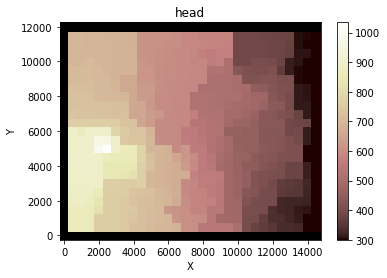

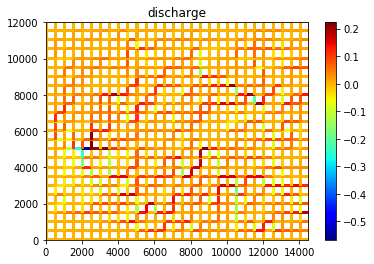

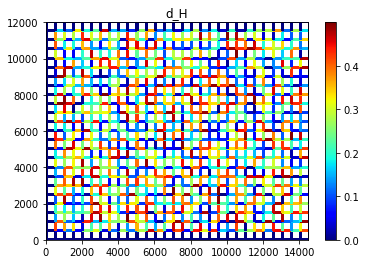

In [9]:
figure()
imshow_grid_at_node(mg, h)
title('head')

figure()
plot_links(mg, 'conduit__discharge')#,logvalues=True)
title('discharge')


figure()
plot_links(mg, 'hydraulic__diameter')#,logvalues=True)
title('d_H')


In [10]:
mc.run_one_step()
pfn.run_one_step()


max ddh =  0.008749349561559835
Number of iterations = 1 tolerance = 0.0015228943378533533
Number of iterations = 2 tolerance = 2.0394080468149283e-05
Number of iterations = 3 tolerance = 1.439764774592705e-07


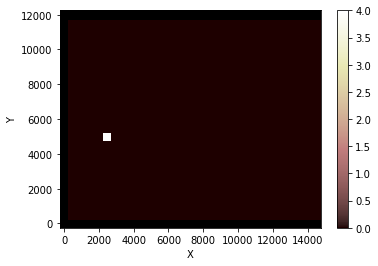

In [144]:
mg.calc_net_flux_at_node(Q, out=net_node_flux)
net_Q = mg.calc_net_flux_at_node(Q)/100. - mg.at_node['input__discharge'] 
figure()
imshow_grid_at_node(mg, net_Q)

In [20]:
mg.at_node['input__discharge']

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [24]:
from scipy.optimize import fsolve
def network_residuals(heads):
    h[mg.core_nodes] = heads
    mg.calc_grad_at_link(h, out=dhdx)
    Q = np.sign(dhdx)*np.sqrt(np.fabs(dhdx))
    return mg.calc_net_flux_at_node(Q, out=net_node_flux)[mg.core_nodes]/mg.dx - mg.at_node['input__discharge'][mg.core_nodes]
#This function doesn't account for inflow at nodes


In [25]:
mc.run_one_step()
mg.calc_grad_at_link(h, out=dhdx)
mg.at_node['hydraulic__head'][mg.core_nodes] = fsolve(network_residuals, h[mg.core_nodes])
mg.at_link['conduit__discharge'][mg.core_nodes] = np.sign(dhdx[mg.core_nodes])*np.sqrt(np.fabs(dhdx[mg.core_nodes]))

print "mean h =", mean(mg.at_node['hydraulic__head'][mg.core_nodes] )
print "mean Q =", mean(Q)

mean ddh =  -5.66192997218e-18
mean h = 166.222550077
mean Q = 0.0865514465643


In [22]:
mg.dx

100.0

In [26]:
figure()
imshow_grid_at_node(mg, h)

In [24]:
figure()
plot_links(mg, 'hydraulic__diameter', autoscale=False, vmin=0, vmax=1.)
print mean(mg.at_link['hydraulic__diameter'])

3.50074727364e+69


In [56]:
figure()
plot_links(mg, 'conduit__discharge', autoscale=True, magnitude=True)
#print mean(mg.at_link['hydraulic__diameter'])

In [10]:
mc = MeltCreep(mg, dt=5000.)
#mean(mc.Q)

In [17]:
plot(mg.at_link['hydraulic__diameter'][200:300])


Grid query results:

{'grid location': {'x_coord': 62.235756386751902,
                   'y_coord': 1.0513915948896004},
 'node': {'ID': 1,
          'column': 1,
          'row': 0}}

Grid query results:

{'grid location': {'x_coord': 62.235756386751902,
                   'y_coord': 1.0513915948896004},
 'node': {'ID': 1,
          'column': 1,
          'row': 0}}

Grid query results:

{'grid location': {'x_coord': 62.235756386751902,
                   'y_coord': 1.0513915948896004},
 'node': {'ID': 1,
          'column': 1,
          'row': 0}}

Grid query results:

{'grid location': {'x_coord': 62.235756386751902,
                   'y_coord': 1.0513915948896004},
 'node': {'ID': 1,
          'column': 1,
          'row': 0}}

Grid query results:

{'grid location': {'x_coord': 62.235756386751902,
                   'y_coord': 1.0513915948896004},
 'node': {'ID': 1,
          'column': 1,
          'row': 0}}

Grid query results:

{'grid location': {'x_coord': 62.235756386751902


Grid query results:

{'grid location': {'x_coord': 19.648267738121763,
                   'y_coord': 0.84814187582238287},
 'node': {'ID': 0,
          'column': 0,
          'row': 0}}

Grid query results:

{'grid location': {'x_coord': 19.648267738121763,
                   'y_coord': 0.84814187582238287},
 'node': {'ID': 0,
          'column': 0,
          'row': 0}}

Grid query results:

{'grid location': {'x_coord': 19.648267738121763,
                   'y_coord': 0.84814187582238287},
 'node': {'ID': 0,
          'column': 0,
          'row': 0}}

Grid query results:

{'grid location': {'x_coord': 19.648267738121763,
                   'y_coord': 0.84814187582238287},
 'node': {'ID': 0,
          'column': 0,
          'row': 0}}

Grid query results:

{'grid location': {'x_coord': 19.648267738121763,
                   'y_coord': 0.84814187582238287},
 'node': {'ID': 0,
          'column': 0,
          'row': 0}}

Grid query results:

{'grid location': {'x_coord': 19.6482677381

In [19]:
#figure()

pfn.run_one_step()
mc.run_one_step()

Number of iterations = 1 tolerance = 0.0031818002267
Number of iterations = 2 tolerance = 1.26436621244e-05
mean ddh =  -6.86035808489e-06


In [41]:
#for m in mc.melt:
#    print m
print max(mc.melt[~np.isnan(mc.melt)])
print max(mc.creep)
#print mc.d_h.mean()
#print mg.at_link['hydraulic__diameter']

3.35041761374e-06
2.12710591355e-06


In [15]:
#mc.run_one_step()

mc._grid.at_link['conduit__discharge']

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])